# Inside the Transformer: A Comprehensive Exploration


Introduced by:
- Jeanfed Ramirez Lima
- Carlos Antonio Olachea Hernández

Disclaimer: This Jupyter notebook, along with the included figures, was authored by the above individuals. When referencing or utilizing the figures from this notebook, please ensure proper attribution to the authors.

---

## Historical Background

Highlights:


*   First appearance in the article [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) by Vaswani, 2017

*   The state-of-the art was recurrent neural networks (RNN).

The problems they came to solve were:

1. **Handling of long term dependencies on long sequences** - Gradients diminish as they propagate back throught time, making it difficult for the RNN to effectively learn and capture long-term dependencies. As the sentence length increases, it becomes more difficult for the model to capture the information in this vector.
2. **Slower execution** - RNNs are sequential models, and computations cannot be parallelized effectively, leading to slower execution, especially on modern parallel hardware like GPUs.
3. **Lack of parallelization** - Traditional RNNs suffer from a lack of parallelization, which limits their ability to take advantage of modern hardware and efficiently process data.


---

Before the tutorial starts, we shall call all the modules used.

In [ ]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.0 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

## The Original Transformer

The Transformer model is an architecture that eliminates the need for recurrent structures and, instead, relies exclusively on an **attention mechanism** to establish global connections between input and output. It comprises both an encoder and a decoder structure, which can be employed separately if necessary, primarily designed for translation tasks.

The initial architecture, as introduced in the paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf), is depicted as follows. However, upon closer inspection, it becomes apparent that this architecture is intricate and multifaceted, resembling the complex web of connections found in electronic circuits, which might appear daunting to grasp.

<div>
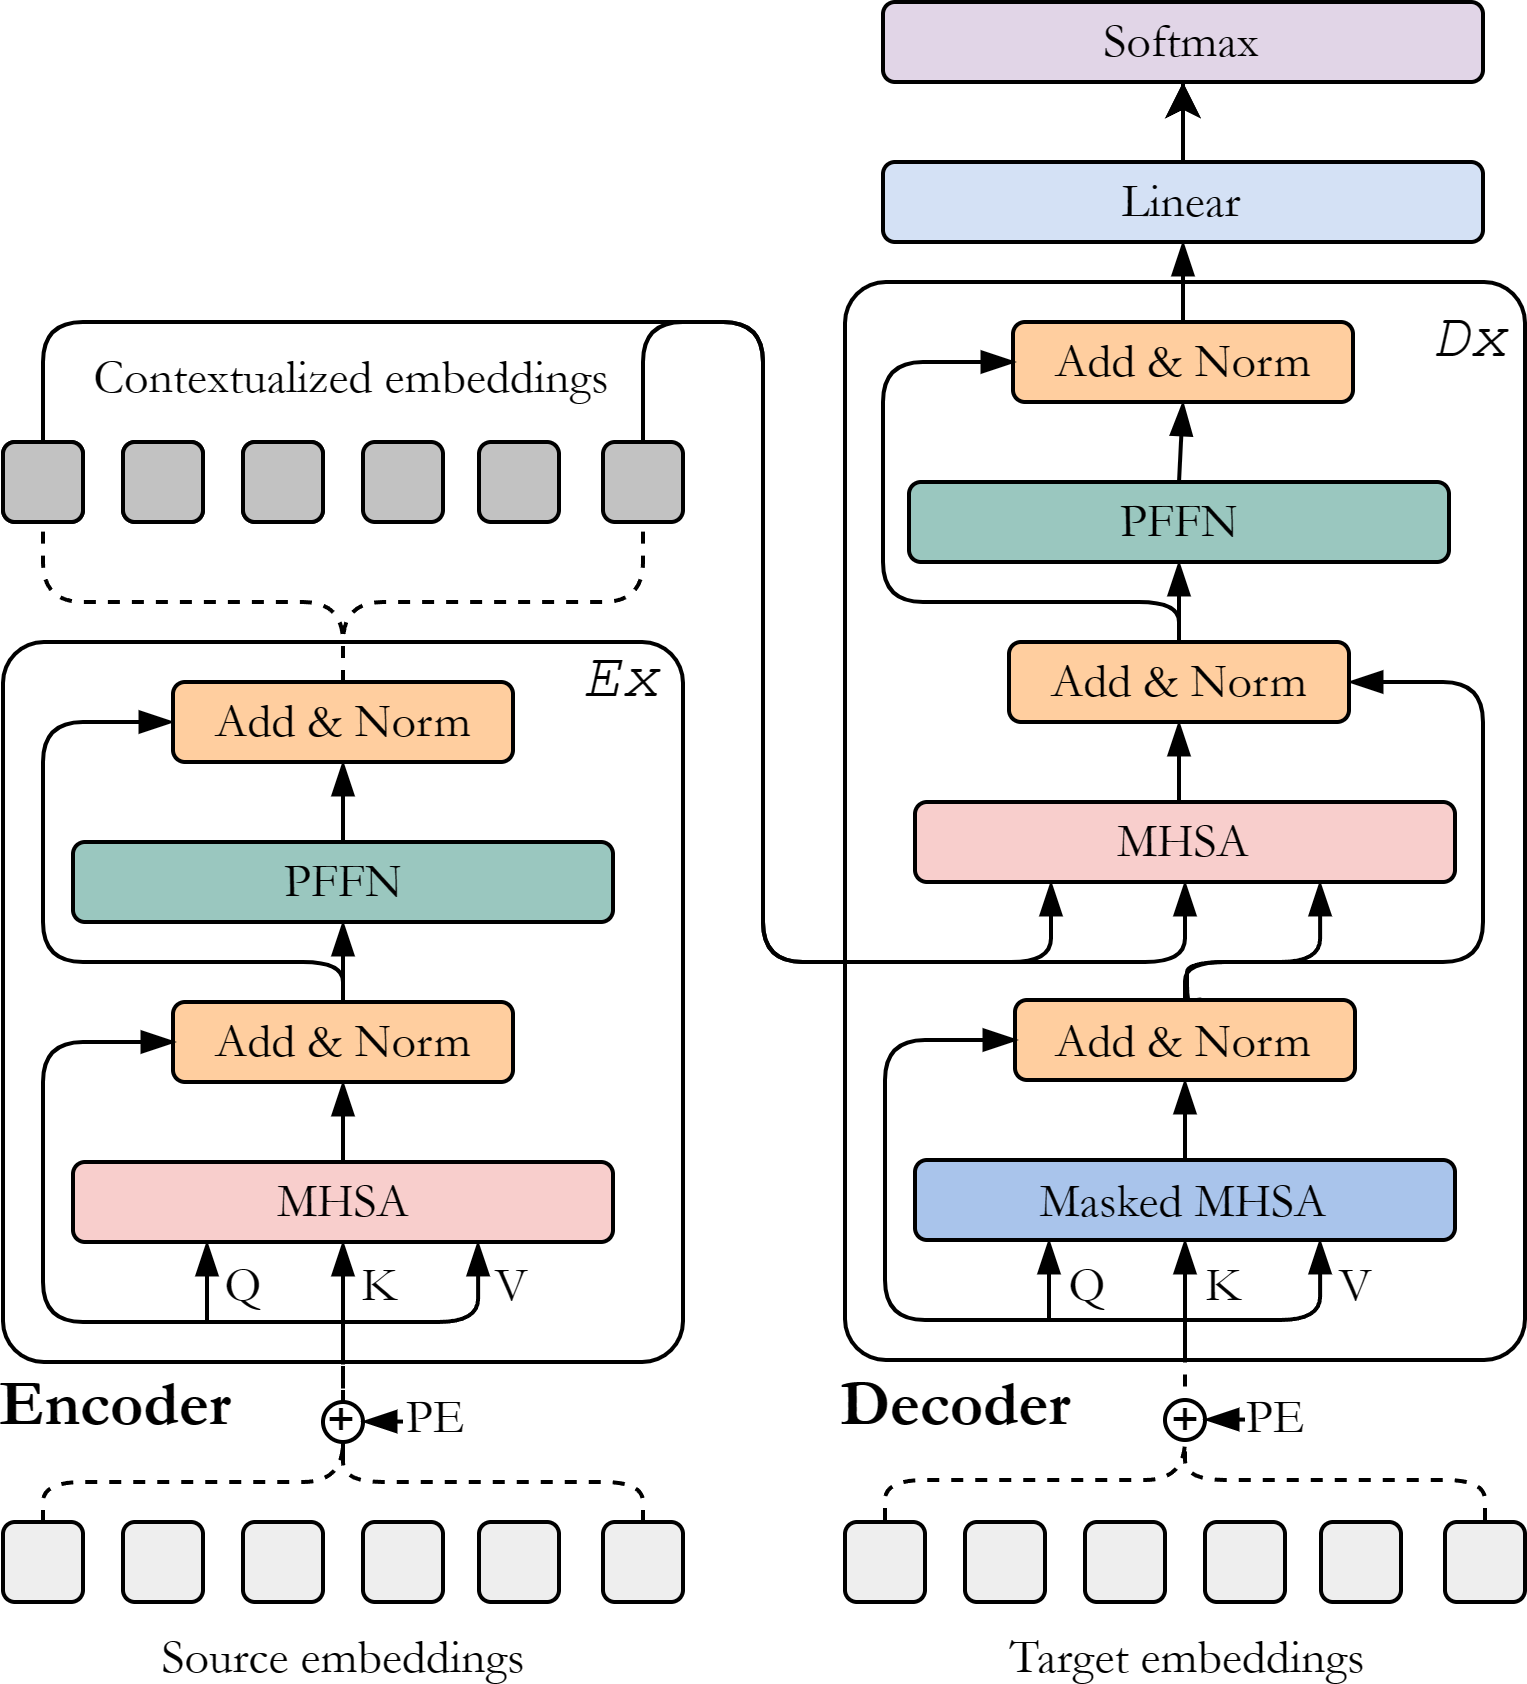
</div>

This transformer consists of two components: an encoder denoted as $Ex$ and a decoder referred to as $Dx$. However, other architectures like **BERT** or **GPT** feature exclusively an encoder and a decoder, respectively.

Starting with the encoder, let's examine the three main blocks within the $Ex$ model:

- **Multi Head Self Attention (MHSA)**
- **Add & Norm**
- **Position-wise Feed Forward Network**

In the decoder $Dx$, we encounter the same blocks found in $Ex$, along with an additional module:

- **Masked Multi Head Self Attention (Masked MHSA)**

A fundamental element shared by Transformer models of various architectures is the *Multi-Head Attention* block. To gain a deeper insight into the inner workings of such architectures, it's helpful to begin by explaining the concept of *self-attention*.

## Word Embeddings

To begin with, let us assume that we have the following sentence:

$$
\text{She enjoyed a delicious cup of coffee while listening to her favorite music}
$$

This sentence can be tokenized (we'll explore tokenization in more detail later in the tutorial) into individual tokens:

$$
\text{tokens}=\left\{\text{She, enjoyed, a, delicious, cup, of, coffee, while, listening, to, her, favorite, music}\right\}
$$

Each of the words can be furtherly converted into an embedding vector.

> An embedding is essentially a numerical representation of a word or token in a high-dimensional vector space, where words with similar meanings or contextual usage are situated closer together.

 To examplify we will *cheat* for a bit and load a pretrained `BertModel` from HuggingFace to extract embeddings from it.

In [ ]:
!pip install transformers -q

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased-whole-word-masking')
model = BertModel.from_pretrained("bert-large-cased-whole-word-masking")

In [ ]:
text = "She enjoyed a delicious cup of coffee while listening to her favorite music"
encoded_input = tokenizer(text, return_tensors='pt')

# Get the tokens for inspection
tokens = tokenizer.decode(encoded_input['input_ids'][0])

print("Tokens: ", tokens)

Tokens:  [CLS] She enjoyed a delicious cup of coffee while listening to her favorite music [SEP]


As you can observe, the tokenizer introduces two additional tokens, which we will temporarily overlook. We will delve into the explanation of these tokens later in the tutorial since they hold a particular significance in the BERT model.

In [ ]:
embeddings = model(**encoded_input)

print("Embeddings shape: ", embeddings[0].shape)

Embeddings shape:  torch.Size([1, 15, 1024])


By now we have a matrix of $NxM$, with $N$ rows, where each row is an $M$ dimensional embedding vector.

To further visualize the embeddings we can apply a dimensionality reduction algorithm to plot the vectors in a 2D-plot.

For this, we can use [T-SNE](https://arxiv.org/pdf/2105.07536.pdf). A really great visualization of how this algorithm works is available in [this website](https://distill.pub/2016/misread-tsne/).

In [ ]:
embedding = embeddings[0]

# Reshape the embedding tensor to (num_samples, num_features)
num_samples, num_features = embedding.shape[1], embedding.shape[2]
embedding_2d = embedding.view(num_samples, num_features).detach().numpy()

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
embedding_2d = tsne.fit_transform(embedding_2d)

# The `embedding_2d` variable now contains the 2D t-SNE embeddings
# print("t-SNE Embeddings (2D):")
# print(embedding_2d)

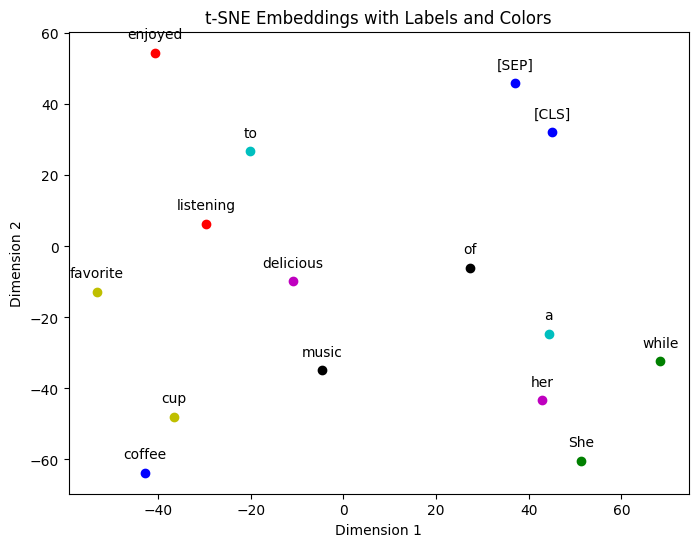

In [ ]:
words = ["[CLS]", "She", "enjoyed", "a", "delicious", "cup", "of", "coffee", "while", "listening", "to", "her", "favorite", "music", "[SEP]"]

# Create a list of colors, one for each point
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create a scatter plot for the t-SNE embeddings
plt.figure(figsize=(8, 6))
for i in range(embedding_2d.shape[0]):
    x, y = embedding_2d[i, 0], embedding_2d[i, 1]
    label = words[i]  # Assuming you have a list of words
    color = colors[i % len(colors)]  # Cyclically select colors
    plt.scatter(x, y, c=color, label=label)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title("t-SNE Embeddings with Labels and Colors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

## Self-Attention Head

The attention mechanism was firstly introduced in [Neural Machine Translation by Jointly Learninig to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). In this case, the most "simple to understand" case of attention is *self-attention*. The main purpose of a **self-attention head** is to compute the attention matrix which identifies the relevant tokens of a sentence.

To actually compute the attention matrix it is necessary to follow the next formula:

$$
Z=\text{Softmax}\left(\frac{QK^T}{\sqrt{d^k}}\right)V
$$

<div>
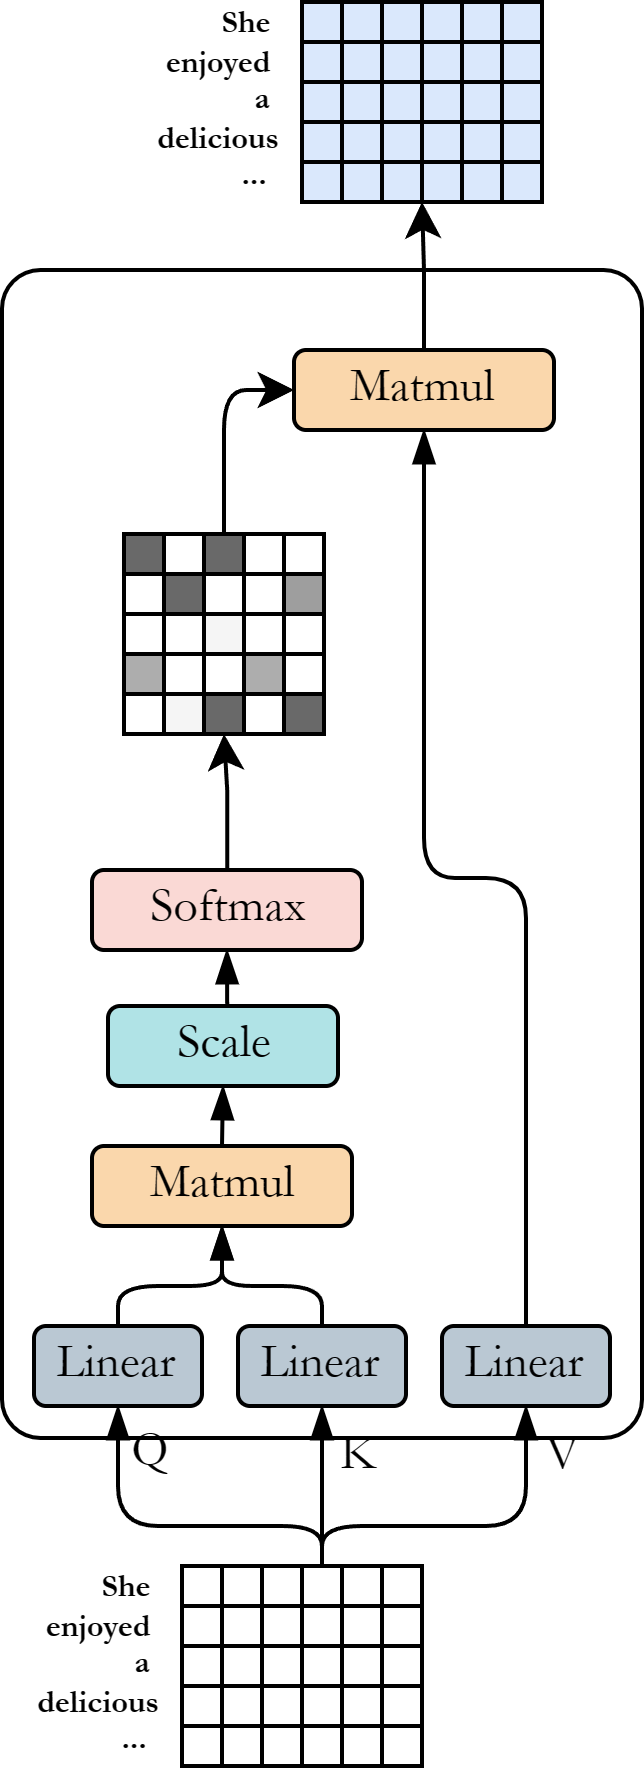
</div>

As hard as it can be seen, lets start by defining the input and output of this block.

- Input: A sequence of embeddings
- Output: A sequence of **contextualized embeddings**, and a square matrix of **attention weights**.

Let us break it apart to better understand what it does.

First, a similarity coefficients are calculated by the dot product, to find words that strongly relate to each other.

$$
QK^T
$$


To begin, it is essential to create a Query ($Q$), Key ($K$), and Value ($V$) matrix. These three matrices will be used to determine the attention matrix between words in two sentences.

As we are computing a representation of a particular sentence, the matrices $Q$, $K$, and $V$ will be derived from the input matrix through linear transformations.

In [ ]:
# Disable gradient computation for this forward pass
dim_inp = embedding.shape[2]
dim_out = 128

with torch.no_grad():
    print("Embedding shape: ", embedding.shape)

    q = nn.Linear(dim_inp, dim_out)
    k = nn.Linear(dim_inp, dim_out)
    v = nn.Linear(dim_inp, dim_out)
    query, key, value = q(embedding), k(embedding), v(embedding)

    print("Query shape: ", query.shape)
    print("Key shape: ", key.shape)
    print("Value shape: ", value.shape)

Embedding shape:  torch.Size([1, 15, 1024])
Query shape:  torch.Size([1, 15, 128])
Key shape:  torch.Size([1, 15, 128])
Value shape:  torch.Size([1, 15, 128])


In essence, the *scores* measure the degree of similarity between word tokens, akin to applying a cosine similarity comparison individually for each pair.

In [ ]:
# Compute attention scores
scores = torch.bmm(query, key.transpose(1, 2))

print("Scores shape: ", scores.shape)

Scores shape:  torch.Size([1, 15, 15])


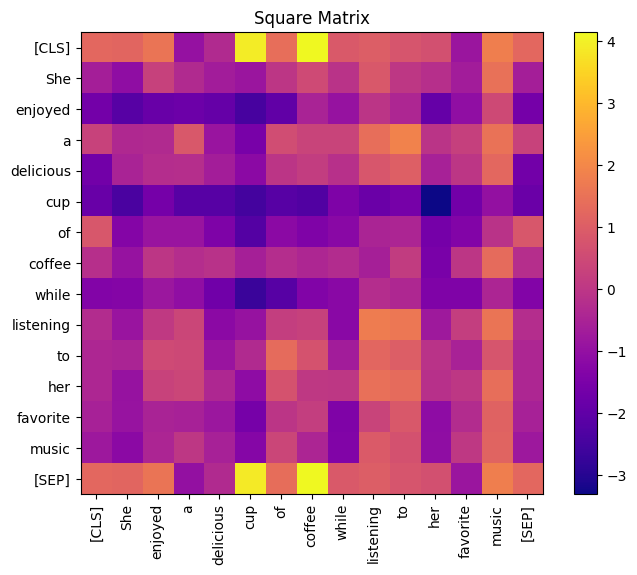

In [ ]:
words = ["[CLS]", "She", "enjoyed", "a", "delicious", "cup", "of", "coffee", "while", "listening", "to", "her", "favorite", "music", "[SEP]"]

# Convert the tensor to a numpy array for visualization
matrix = scores[0].detach().numpy()

# Create a square matrix plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='plasma', interpolation='nearest')

# Set x and y axis labels
plt.xticks(range(len(words)), words, rotation=90)
plt.yticks(range(len(words)), words)

plt.title("Square Matrix")
plt.colorbar()
plt.show()

To avoid grandient-related problems and ensure more stability in training, the matrix $QK^T$ is scaled by the square root of the embedding length. This is also known as a scaled dot-product.

$$
\frac{QK^T}{\sqrt{d^k}}
$$

In [ ]:
# Scale the scores
scale = key.size(1) ** 0.5  # square root of the dimension of the queries
scores = scores / scale

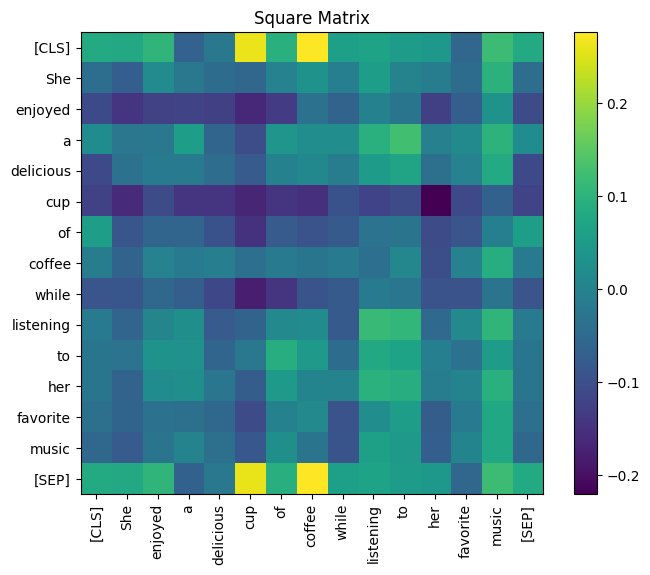

In [ ]:
words = ["[CLS]", "She", "enjoyed", "a", "delicious", "cup", "of", "coffee", "while", "listening", "to", "her", "favorite", "music", "[SEP]"]

# Convert the tensor to a numpy array for visualization
matrix = scores[0].detach().numpy()

# Create a square matrix plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')

# Set x and y axis labels
plt.xticks(range(len(words)), words, rotation=90)
plt.yticks(range(len(words)), words)

plt.title("Square Matrix")
plt.colorbar()
plt.show()

In [ ]:
# Get the maximum and minimum values
max_value = torch.max(scores)
min_value = torch.min(scores)

print("Maximum value:", max_value.item())
print("Minimum value:", min_value.item())

Maximum value: 0.27598217129707336
Minimum value: -0.220269113779068


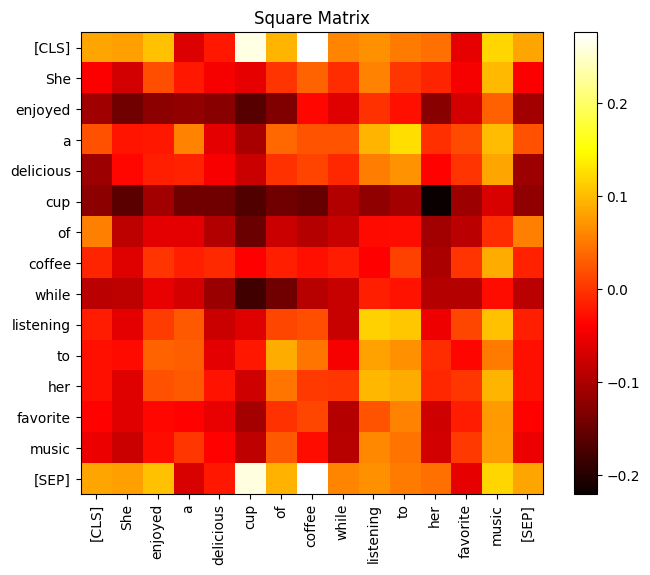

In [ ]:
words = ["[CLS]", "She", "enjoyed", "a", "delicious", "cup", "of", "coffee", "while", "listening", "to", "her", "favorite", "music", "[SEP]"]

# Convert the tensor to a numpy array for visualization
matrix = scores[0].detach().numpy()

# Create a square matrix plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='hot', interpolation='nearest')

# Set x and y axis labels
plt.xticks(range(len(words)), words, rotation=90)
plt.yticks(range(len(words)), words)

plt.title("Square Matrix")
plt.colorbar()
plt.show()

In [ ]:
scores.shape

torch.Size([1, 15, 15])

The score matrix is transformed into a weight matrix for $V$ by normalizing it in a range of 0 to 1 with a Softmax function,

$$
\text{Softmax}\left(\frac{QK^T}{\sqrt{d^k}}\right)
$$

In [ ]:
# Apply softmax
softmax = nn.Softmax(dim=-1)
# Disable gradient computation for this forward pass
with torch.no_grad():
    attn = softmax(scores)

# Get the maximum and minimum values
max_value = torch.max(attn)
min_value = torch.min(attn)

print("Maximum value:", max_value.item())
print("Minimum value:", min_value.item())

Maximum value: 0.08086134493350983
Minimum value: 0.057485125958919525


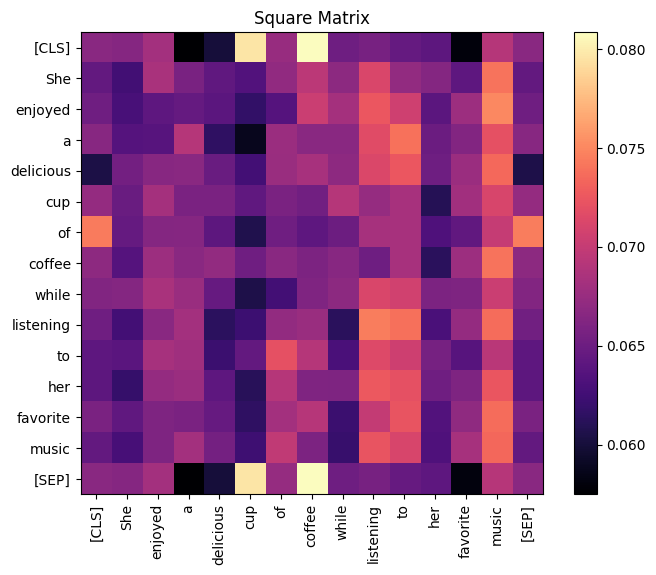

In [ ]:
words = ["[CLS]", "She", "enjoyed", "a", "delicious", "cup", "of", "coffee", "while", "listening", "to", "her", "favorite", "music", "[SEP]"]

# Convert the tensor to a numpy array for visualization
matrix = attn[0].detach().numpy()

# Create a square matrix plot
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='magma', interpolation='nearest')

# Set x and y axis labels
plt.xticks(range(len(words)), words, rotation=90)
plt.yticks(range(len(words)), words)

plt.title("Square Matrix")
plt.colorbar()
plt.show()


The attention matrix $Z$ is derived by applying it to $V$.

$$
Z=\text{Softmax}\left(\frac{QK^T}{\sqrt{d^k}}\right)V
$$

In [ ]:
# Compute the weighted combination of values based on the attention scores calculated
attn_output = torch.bmm(attn, value)

In [ ]:
print("Attention output: ", attn_output.shape)

Attention output:  torch.Size([1, 15, 128])


## Multihead Self-Attention

In certain situations, some confusion among tokens may arise. To prevent this, multiple attention heads can be employed instead of a single one, thus improving accuracy.

$$
\bar{Z}=\text{Concatenate}\left(Z_1, Z_2, \dots, Z_n\right)W_0
$$

<div>
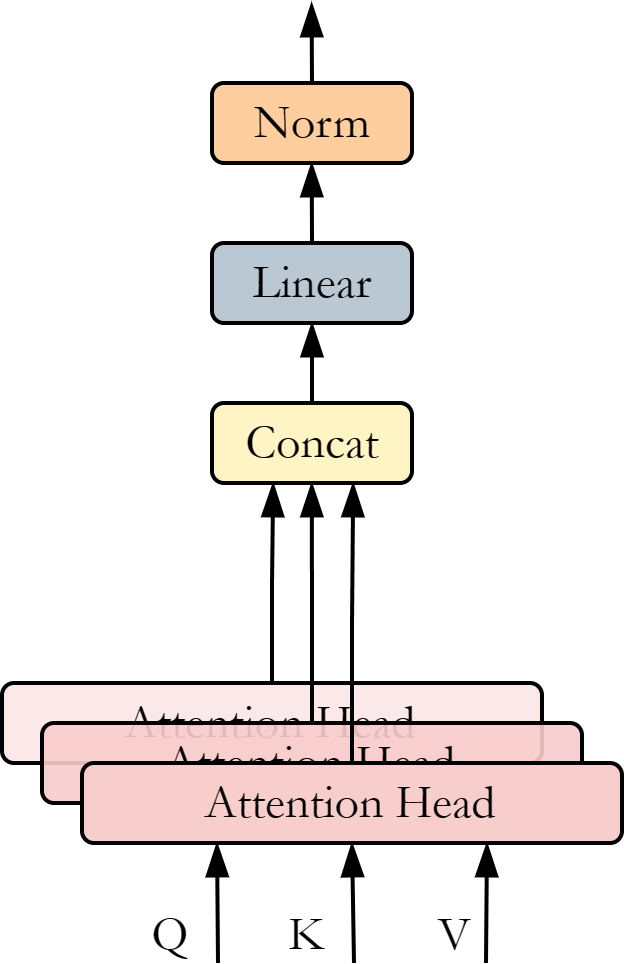
</div>

To implement this block it is necessary to implement two different modules.

- A `SelfAttentionHead` module using all the code previously shown in the previous blocks.
- A `MultiHeadAttention` module that puts in parallel different self-attention heads and concatenates them, reduces dimensionality using a `nn.Linear` layer, and normalizes the output. As described in [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf).  

In [ ]:
class SelfAttentionHead(nn.Module):
    def __init__(self, dim_inp, dim_out):
        super(SelfAttentionHead, self).__init__()
        self.dim_inp = dim_inp
        # Linear transformations for query, key, and value
        self.q = nn.Linear(dim_inp, dim_out)
        self.k = nn.Linear(dim_inp, dim_out)
        self.v = nn.Linear(dim_inp, dim_out)
        # Softmax module for attention scores
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, input_tensor):
        query, key, value = self.q(input_tensor), self.k(input_tensor), self.v(input_tensor)
        # Compute attention scores
        scores = torch.bmm(query, key.transpose(1, 2))
        # Scale the scores
        scale = query.size(1) ** 0.5  # square root of the dimension of the queries
        scores = scores / scale
        # Apply softmax
        attn = self.softmax(scores)
        # Compute context vector
        context = torch.bmm(attn, value)
        return scores, context

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, dim_inp, dim_out):
        super(MultiHeadAttention, self).__init__()

        # List of attention heads
        self.heads = nn.ModuleList([
            SelfAttentionHead(dim_inp, dim_out) for _ in range(num_heads)
        ])

        # Linear transformation and layer normalization
        self.linear = nn.Linear(num_heads * dim_out, dim_inp)
        self.norm = nn.LayerNorm(dim_inp)

    def forward(self, input_tensor):
        # Compute attention for each head and store context vectors
        contexts = []
        for head in self.heads:
            scores, context = head(input_tensor)
            contexts.append(context)

        # Concatenate context vectors from all heads
        concatenated_contexts = torch.cat(contexts, dim=-1)

        # Apply linear transformation
        linear_output = self.linear(concatenated_contexts)

        # Apply layer normalization
        normalized_output = self.norm(linear_output)

        return normalized_output


In [ ]:
mhsa = MultiHeadAttention(num_heads=2, dim_inp=dim_inp, dim_out=dim_out)
with torch.no_grad():
    out_mhsa = mhsa(embedding)

print("Output Multi Head Self Attention: ", out_mhsa.shape)

Output Multi Head Self Attention:  torch.Size([1, 15, 1024])


In [ ]:
embedding.shape

torch.Size([1, 15, 1024])

Now, to get a visualization of how the output changed in respect to the output, lets again use T-SNE to reduce dimensionality of the output embeddings, then let's plot them. As a disclaimer this is just an examplification to see that the input embeddings but is problably not the best way to spot the differences.

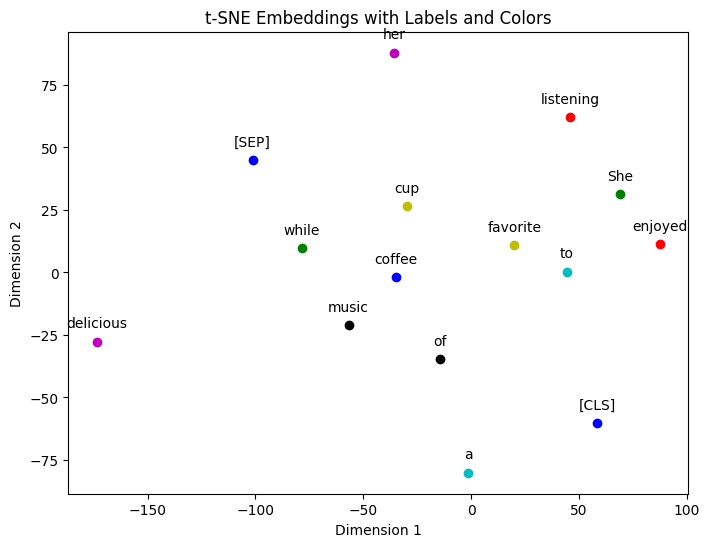

In [ ]:
embedding = out_mhsa

# Reshape the embedding tensor to (num_samples, num_features)
num_samples, num_features = embedding.shape[1], embedding.shape[2]
embedding_2d = embedding.view(num_samples, num_features).detach().numpy()

# Perform t-SNE
# tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
embedding_2d = tsne.fit_transform(embedding_2d)

import matplotlib.pyplot as plt

words = ["[CLS]", "She", "enjoyed", "a", "delicious", "cup", "of", "coffee", "while", "listening", "to", "her", "favorite", "music", "[SEP]"]

# Create a list of colors, one for each point
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Create a scatter plot for the t-SNE embeddings
plt.figure(figsize=(8, 6))
for i in range(embedding_2d.shape[0]):
    x, y = embedding_2d[i, 0], embedding_2d[i, 1]
    label = words[i]  # Assuming you have a list of words
    color = colors[i % len(colors)]  # Cyclically select colors
    plt.scatter(x, y, c=color, label=label)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

plt.title("t-SNE Embeddings with Labels and Colors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

## Building BERT from the Ground Up

To train [BERT](https://arxiv.org/pdf/1810.04805.pdf) we can acquire a section of the [BookCorpus dataset](https://huggingface.co/datasets/bookcorpus). It's important to note that this is not the original dataset; instead it is a copy from the one created by the University of Toronto.

In [ ]:
# Checking if a GPU is available
if torch.cuda.is_available():
    # If a GPU is available, set the device to use the GPU
    device = torch.device("cuda")
    print("Using GPU.")
else:
    device = torch.device("cpu")
    print("No GPU available, using the CPU instead.")

Using GPU.


In [ ]:
!pip install datasets -q
from datasets import load_dataset

# Load the 'bookcorpus' dataset as an iterator since streaming is set to True
dataset_loader = load_dataset('bookcorpus', split='train', streaming=True)

# Shuffle the dataset with a buffer size of 10,000 and a seed of 42
dataset_loader.shuffle(buffer_size=10_000, seed=42)

# Select a subset of the dataset containing 3,400 samples
dataset = dataset_loader.take(3400)

# Extracts the "text" values from each item in the dataset
dataset = [item["text"] for item in dataset]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00


This dataset includes preprocessed content. Each entry consists of a sentence in lowercase from a book, and it retains its punctuation symbols.

In [ ]:
# Explore the first 20 samples
dataset[:20]

['usually , he would be tearing around the living room , playing with his toys .',
 'but just one look at a minion sent him practically catatonic .',
 "that had been megan 's plan when she got him dressed earlier .",
 "he 'd seen the movie almost by mistake , considering he was a little young for the pg cartoon , but with older cousins , along with her brothers , mason was often exposed to things that were older .",
 'she liked to think being surrounded by adults and older kids was one reason why he was a such a good talker for his age .',
 "`` are n't you being a good boy ? ''",
 'she said .',
 'mason barely acknowledged her .',
 'instead , his baby blues remained focused on the television .',
 'since the movie was almost over , megan knew she better slip into the bedroom and finish getting ready .',
 "each time she looked into mason 's face , she was grateful that he looked nothing like his father .",
 'his platinum blond hair and blue eyes were completely hers .',
 'it was only his 

### Tokenizer

There are several tokenization methods available for processing this text. If we strictly adhere to the BERT implementation, we would need to use a specialized algorithm known as [WordPiece](https://arxiv.org/pdf/1609.08144.pdf). This algorithm operates by dividing words into smaller subword units, which are then represented using a fixed vocabulary of subword tokens. WordPiece specifically aims to identify the most common combinations of letters or subwords that frequently appear within words. As an example, the word "Leicestershire" is broken down into "Leicester" and a sub-word "shire" (indicated by hashes).

<div>
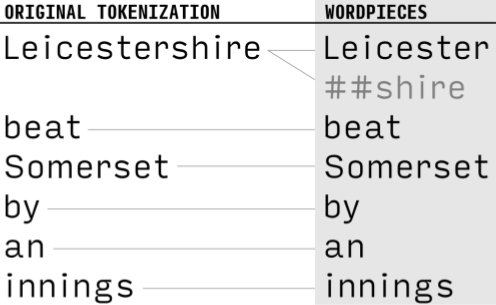
</div>


However, for the purpose of this tutorial, we will utilize a straightforward [WordLevel](https://huggingface.co/docs/tokenizers/api/models#tokenizers.models.WordLevel) tokenizer, which simply divides a sentence into individual *words*. We will make use of an existing library provided by HuggingFace for this task.

The steps to accomplish this task are as follows:
1. Divide a sentence into
2. Add special tokens.

Some of the special tokens we will use, and latter will be defined are:
1. `[CLS]` - this token is used to mark the beginning of a sequence and is typically followed by the input text.
2. `[SEP]` - this token is used to separate two sequences, which is handy when dealing with tasks like text classification or question-answering where you have a pair of sentences.
3. `[PAD]` - padding is used to make sure all input sequences are of the same length, crucial for batch processing in deep learning models.
4. `[UNK]` - represents an unknown token, which is useful when the model encounters a word it hasn't seen before.
5. `[MASK]` - the mask token is used in tasks like masked language modeling where a part of the input is masked, and the model is trained to predict what's hidden.
Additional task-specific tokens - Depending on the specific NLP task you are working on, you may define additional tokens. For instance, you might have tokens like `[ENTITY]`, `[DATE]`, or `[EMOTICON]` for named entity recognition, date extraction, or sentiment analysis tasks, respectively.

In [ ]:
# Import the 'Tokenizer' class and other related modules from the 'tokenizers' library
!pip install tokenizers
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors

# Create a Tokenizer object that uses a WordLevel model with a custom unknown token '[UNK]'
tokenizer = Tokenizer(models.WordLevel(unk_token='[UNK]'))

# Enable padding for the tokenizer
tokenizer.enable_padding()

# Define the pre-tokenizer to split the input text by whitespace
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Define the post-processor to add special tokens and format the output
tokenizer.post_processor = processors.TemplateProcessing(
    single="[CLS] $A [SEP]",  # Format the tokenized sequence with '[CLS]' and '[SEP]'
    special_tokens=[("[CLS]", 2), ("[SEP]", 4), ("[PAD]", 3), ("[MASK]", 1)]  # Define special token counts
)

# Create a trainer for the WordLevel model, specifying the special tokens
trainer = trainers.WordLevelTrainer(special_tokens=['[UNK]', '[MASK]', '[CLS]', '[PAD]', '[SEP]'])

In [ ]:
# Train the tokenizer using the data in the 'dataset' and the specified 'trainer'.
tokenizer.train_from_iterator(dataset, trainer=trainer)

# Configure the tokenizer to enable padding with a pad_id of 3 and a maximum sequence length of 512 tokens.
tokenizer.enable_padding(pad_id=3, length=512)

In [ ]:
print("Vocabulary size:", tokenizer.get_vocab_size())
print("Vocabulary:")
# Explore the generated vocab
vocab = tokenizer.get_vocab()
# Sort the vocabulary
sorted_vocab = sorted(vocab.items(), key=lambda item: item[1])

# Print the first 10 values
for token, index in sorted_vocab[:30]:
    print(f"{token}: {index}")

Vocabulary size: 3808
Vocabulary:
[UNK]: 0
[MASK]: 1
[CLS]: 2
[PAD]: 3
[SEP]: 4
.: 5
,: 6
'': 7
``: 8
': 9
the: 10
to: 11
she: 12
her: 13
a: 14
i: 15
he: 16
you: 17
and: 18
his: 19
of: 20
s: 21
was: 22
in: 23
?: 24
t: 25
n: 26
megan: 27
that: 28
it: 29


The next process is to encode the dataset. Which is just converting each of the sentences into a list of token IDs.

In [ ]:
encoded_dataset = tokenizer.encode_batch(dataset)

In [ ]:
encoded_dataset[:10]

[Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=512

In [ ]:
print("Original sentence: ", dataset[0])
print(encoded_dataset[0].tokens)
print(encoded_dataset[0].ids)

Original sentence:  usually , he would be tearing around the living room , playing with his toys .
['[CLS]', 'usually', ',', 'he', 'would', 'be', 'tearing', 'around', 'the', 'living', 'room', ',', 'playing', 'with', 'his', 'toys', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

### The Training Task (Masked Language Modeling)

One of the tasks in which BERT is trained is called **Masked Language Modeling**. We will not talk about the other task called [Next sentence Prediction], so you can say that this is a mixed implementation between BERT and [RoBERTa](https://arxiv.org/pdf/1907.11692.pdf).


This objective function is based on the cloze task, where tokens are randomly masked and the model has to predict what tokens were before. By solving this task, we make the model redirect its learning to capture the relationships between the tokens that make up the sentences.

This usually performed randomly with 15% of the input tokens. To avoid bias, noise is introduced in a controlled way during masking, a token can be masked as follows:

* 80% of the time it is replaced with the special token [MASK].
* 10 % of the time it is replaced with another word
* 10 % of the time it is left unchanged

In the next figure is shown an example of this masking:

<div>
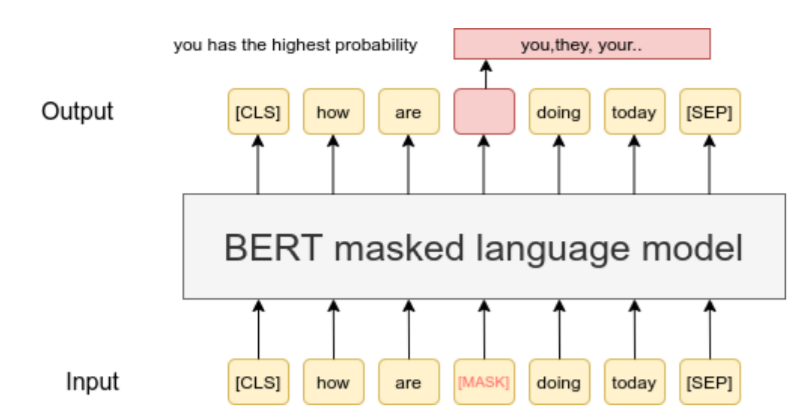
</div>

Figure taken from the paper: [Finnish Language Modeling with Deep Transformer Models](https://arxiv.org/pdf/2003.11562.pdf).

In [ ]:
import random

MASK_PERCENTAGE = 0.15

def mask_dataset(dataset):
    input_ids = []
    attention_mask = []
    padding_mask = []
    target_ids = []

    for sentence in dataset:
        # Compute the input_ids with the masked tokens
        indices_to_alter = [i for i, value in enumerate(sentence) if value not in [2, 4, 3]]
        num_tokens_to_alter = int(len(indices_to_alter) * MASK_PERCENTAGE)
        indices_to_alter = random.sample(indices_to_alter, num_tokens_to_alter)

        sentence_copy = list(sentence)  # Create a new list that is a copy of sentence

        target_ids.append([-100 if i not in indices_to_alter else sentence_copy[i] for i in range(len(sentence_copy))])

        for index in indices_to_alter:
            # tokens.append(sentence_copy[index])
            sentence_copy[index] = 1 # Mask token

        # Create the input_ids
        input_ids.append(sentence_copy)  # Append the new list

        # Create the attention mask
        # The attention mask should have True for tokens that sohould mask
        attention_mask.append([False if token != 1 else True for token in sentence_copy])

        # Create the padding mask
        # The padding mask should have a 1 for padding tokens and a 0 for non-padding tokens.
        padding_mask.append([True if token == 3 else False for token in sentence_copy])

    return input_ids, attention_mask, padding_mask, target_ids

In [ ]:
input_ids, attention_mask, padding_mask, target_ids = mask_dataset([sentence.ids for sentence in encoded_dataset])

In [ ]:
# Create dataloaders for training
from torch.utils.data import TensorDataset, DataLoader

# This receives the output directly from the tokenizer without torch conversion and adding batch
def create_dataloaders(input_ids, attention_masks, padding_masks, target_tokens, batch_size, shuffle=True):
    input_tensor = torch.tensor(input_ids).to(device)
    masks_tensor = torch.tensor(attention_masks, dtype=torch.bool).to(device)
    padding_tensor = torch.tensor(padding_masks, dtype=torch.bool).to(device)
    targets = torch.tensor(target_tokens).to(device)
    dataset = TensorDataset(input_tensor, masks_tensor, padding_tensor, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [ ]:
dataloader = create_dataloaders(input_ids, attention_mask, padding_mask, target_ids, batch_size=32, shuffle=False)

In [ ]:
# Create an iterator from the dataloader
dataloader_iterator = iter(dataloader)

# Get the first batch
first_batch = next(dataloader_iterator)

In [ ]:
inputs, masks, padding_masks, targets = tuple(b.to(device) for b in first_batch)
s_input = inputs[0].unsqueeze(0)
s_mask = masks[0].unsqueeze(0)
s_padding_mask = padding_masks[0].unsqueeze(0)
s_target = targets[0].unsqueeze(0)

In [ ]:
print(s_input[0][:20])
print(s_mask[0][:20])
print(s_padding_mask[0][:20])
print(s_target[0][:20])

tensor([   2,  616,    6,   16,    1,   41, 3584,  107,   10,  660,  115,    1,
         596,   30,   19, 3641,    5,    4,    3,    3], device='cuda:0')
tensor([False, False, False, False,  True, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False],
       device='cuda:0')
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True],
       device='cuda:0')
tensor([-100, -100, -100, -100,   54, -100, -100, -100, -100, -100, -100,    6,
        -100, -100, -100, -100, -100, -100, -100, -100], device='cuda:0')


### The Model

To gain a deep understanding of how a Transformer encoder, such as [BERT]((https://arxiv.org/pdf/1810.04805.pdf), functions, the most effective approach is to put it into practice and observe how information flows through its various layers. While recreating BERT using PyTorch may initially seem challenging for many newcomers, we will demonstrate that it is not as complex as it may appear.

<div>
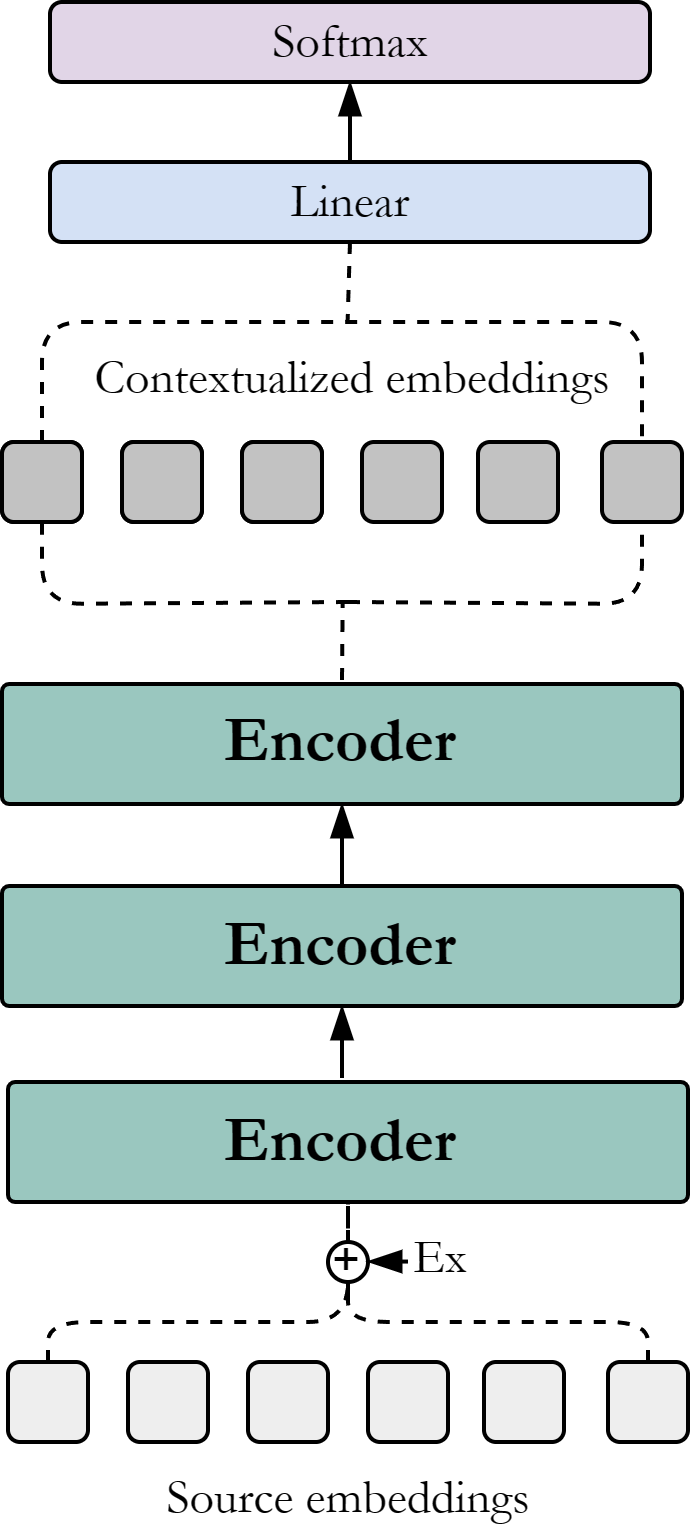
</div>

Let's begin by breaking down the process from the bottom and working our way up to the top. First, let's establish what the input and output of this layer should be:

- Input: A sequence of token IDs
- Output: A single embedding vector with a size of hidden_size

As is customary, we will create a PyTorch class that inherits from nn.Module. Fortunately, PyTorch provides an Embedding module that is readily available. Internally, this module is essentially a Linear layer equipped with a lookup table to map token IDs to dense embedding vectors.

In [ ]:
class BERTEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, seq_len):
        super(BERTEmbeddings, self).__init__()
        self.seq_len = seq_len
        self.token_embeddings_l = nn.Embedding(vocab_size, hidden_size)
        self.position_embeddings_l = nn.Embedding(seq_len, hidden_size)
    def forward(self, input_ids):
        token_embeddings = self.token_embeddings_l(input_ids)
        # Create a range of positions to compute positional embeddings
        pos_tensor = torch.arange(self.seq_len, device=torch.device(device))
        position_embeddings = self.position_embeddings_l(pos_tensor)
        return token_embeddings + position_embeddings

In [ ]:
bert_embeddings = BERTEmbeddings(tokenizer.get_vocab_size(), hidden_size=128, seq_len=512).to(device)

In [ ]:
print("Input shape : ", s_input.shape)
output_emb = bert_embeddings(s_input)
print("Embeddings shape: ", output_emb.shape)

Input shape :  torch.Size([1, 512])
Embeddings shape:  torch.Size([1, 512, 128])


### The Encoder

The Transformer encoder allows to compute a vectorial representation (a.k.a. *embedding*) of a given input; in order to achieve this, it uses the following components and its main purpose:

*   Multi-head Self Attention: To highlight the most important elements of the input matrix.
*   Feed-forward Neural Network: To learn non-linear relationships between the features that make up the input matrix.
*   Residual Conections: Preserve information and prevents the values of each layer from changing too much, which promotes faster training.

Then, we can proceed to work in the Encoder stack itself.
Again let's define what the input and output will be:

- Input: A sequence of embeddings, its attention mask, and its padding mask.
- Output: A sequence of **contextualized** embeddings.

<div>
<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAq0AAAUrCAYAAAF3Fa52AAABhGlDQ1BJQ0MgcHJvZmlsZQAAKJF9kT1Iw0AYht+mSqVUHCwq4pChOtlFRRxLFYtgobQVWnUwufQPmjQkKS6OgmvBwZ/FqoOLs64OroIg+APi6uKk6CIlfpcUWsR4x3EP733vy913gNCsMtXsiQGqZhnpRFzM5VfFwCuCNIcwDL/ETD2ZWczCc3zdw8f3uyjP8q77c/QrBZMBPpE4xnTDIt4gnt20dM77xGFWlhTic+JJgy5I/Mh12eU3ziWHBZ4ZNrLpeeIwsVjqYrmLWdlQiWeII4qqUb6Qc1nhvMVZrdZZ+578haGCtpLhOq0xJLCEJFIQIaOOCqqwEKVdI8VEms7jHv5Rx58il0yuChg5FlCDCsnxg//B796axekpNykUB3pfbPtjHAjsAq2GbX8f23brBPA/A1dax19rAnOfpDc6WuQIGNgGLq47mrwHXO4AI0+6ZEiO5KclFIvA+xl9Ux4YvAWCa27f2uc4fQCy1KvlG+DgEJgoUfa6x7v7uvv2b027fz9le3Khz3FZQgAAAAZiS0dEAP8A/wD/oL2nkwAAAAlwSFlzAAAuIwAALiMBeKU/dgAAAAd0SU1FB+cKChYYF/v7uwMAAAAZdEVYdENvbW1lbnQAQ3JlYXRlZCB3aXRoIEdJTVBXgQ4XAAAgAElEQVR42uydd3gUVfv3vxOQ0BIgEDoYmoKKwIIFSEJ5RAGVjiAqEBQeVKQjKEV6UQhBShCUIFgAIRR9AEEJJEFeFULTHyCBIEV6JITQlMz7R2aX2d2ZLdmZzezu93Ndm8ycOW3uueee+5w5Zw6Qf0Tog0n6H+Yk3noX8xvl4Ng+lW2PCfIgraCTYNOk/5nQH5PKdoEIVlTZPyzb/kV2/IiDiyE62G8qxa9tc/yyg3qZ0//kQJAPAyglC5NvH5L+T7RJ95s3BKumqY8BaKZwG78r267rpmkRAaTblF3OQb26StsHFY6Xk+6GYzZ5yrcftxEwAJwGMB1Ec8oDKEsx6EMwRUAIIcbja5kfqPYzWto3PUjrLN0RT8sVACA5Odlp8zQ6OlrRh/XBtGJycjJcSPssgO35LdflBoIrlfGntAC2eVJuEK2gPlCwFCwFSyhYCtZ/BTtjxox8F+KLaQHEelKuIGuJOENw0IphWtfSEkIIIYQQ/REpApeIoAgMfEXEAtp2dFeJBbTtd2aJtx7hA1Vz2B/rRcF2gPMBCQX1g8HrZkHeb1jyiy++yH7llVcMqwWCIEAURUPXzyxTi2BFI9fYRwQrF26QLz0UClqoO3bscLWOouAr2moUjXWlDoIg6OsVCIKg6U+vPN1h4MCBVvspKSl2cdLT06Gbxp7eMgfVKxp/ToRginHpLmjUqBH2799vpbVt27bF1q1bERUVZSdg/UzB/uU+4W+6KlifaCB8m3zAan/2iq2K2/7WQPDEzXCJd+PWWO3XrBquuK1G5xHz0azvNABA4o59vivY/DxY1Phi8x4cSbSe6LfnULri9r3cXIRE5j0szP/N/LR8LJZtTMETj9awc8ei+uXlX6nNUMux8NbvGEewZgGJouj0BwCxsbFW+0q82r4pAKBq2+G4efsuAKDp47Wtts10GbEA2amLIZhikJ262BJesWze9Nd+HaNw5+6/dvX9akbeRahW8f7M08hGD3nXdqs9vDz2GfnwMmYrhw8vokhhvTLel1sfTZo0Cdj+B/YV0BTQxuqmrRQsBew7gjXbVtpY2lhCwVKwxOWWl1GexgVdD1cfni61vARBwJI9SVRDif5Pt6QpoI3Nx+1GwXpgR9N23n+tPKBpK6t4tvsUrAu807o9ACDzwgW7Y19+OBcAsGRPkmGFa1jBzt+xGQAQVrGi3bFX3h1m2TaqcOkV0Cvgw4vI3BunwLhD1L36a968uSviEgu7IXxDuGHsj6WNNXani1Hrk2/BiqJoyJPxi3deoijit99+03x4uju/Pn36WNl4X7GxPjNgQz7ykQ8vbV1CNhAIBasbhfXMXI8nuNZ56mVidBPs6S1zIKYlGP/prVNrTjdT4AuT5/zOxnKel5u31KlTp1yKy3leMqG5Ms+rRo0alv0TZy8p5sV5XnB/npc8bq2q5RXz5DwvzvPSR2M5z4str8BqeXGeFzjPi6aANlYfbaVgKWDO86LG0sYSCpaC9eOWF+d5uddSc3lE9+20vVRDieBGjWkKaGPd4HpODl4e9a5l/8W336FgnVHUlNcj9vOhQ3bH3pmet7hkaIkS+PqjDy3hmxZ8TME6w2zLn3r8cUtYheiWKGpqgjVbv7e7AOZnQGbWdQrWVa01czF5J26n7UWLJ5rYXYAhM2cBACq3am2oc6BXQK+AXgGRtSY4z8tX53lp8b7KKHnQFNjw7LPPGssr0KrjxJNijJKHITXWfGL16tXzOA9Perls07o6StJwgrV9X3XkyBHVk3Q1DwDo0KGD2/XIyMiw5GEuOzQ01D9s7AWFz5Hkh02bNnl0W5vThoWF+Ydgt2zZoqm3YZ69mB9CQkK8+/DS2i1Rys/dMvxiiJE3Jil7W0jefK3j1N36/fff8dhjj/lD69JrZd28eZOjDfUgNDQ0zxQ8//zz7DDRkOzs7DzBbt68+U2KQ9Nms5U1PyiK4uM0BR4/HFWfkOwezN/vdZ9+uPtKRfkGQScKq2iCoIFmCRRvniCa+sAtK/qiYM2/9bKwQzYn5O7/lxTC8yucXF8VrFljf5GFp6sIDAAmydI4E7CnGmf7YjPXV7Ta1hSclf6fcCKo+d4QrPwt8bp168TBgweLCneabRnx0v8etPSuqKsoil9//bUrgjXzSYE0FnxIti63cEj+HrBpFAVbXiTQaUkRaItfLsLwgUrLyZvbaporyoTu7e3AaZcXEBEUAc0UIU54E87f6fhTWmfpjnhargAAmZmZTh9U0og8u/a5D6YVMzMz4ULaZwFsz2+5Lre8XKmMP6UFsM2TctmkZV8BBUsoWAqWgiVuCnbQoEH5LsQX0wKI9aRcQdYScYbgoBXDtK6lJYQQYmBCAazVMf9IB8dKKWx/yktCnCI60aadNsfSHOzXAxCskK985HgRAPIFZeTb6bB++7tUdqw3gGW+Lmy5YEc5uRCiCxesNwBXPgiWrpA+zE3flHh4VxENBGq42ddrAfxPx5OOcBLH1c8R+ZT34OrtMyqfx/zi9sxPt2FXB8caybZPyLaXIu+VchGFY+kKGioX7jw4HmzsN96D6OLt1cWBwLqoPLGVBOKsTHoP9B6I4b0HQgghzocl3vHBtGpDMT0Z/ulyuQIAMTk52anko6OjxwCYZVuIwdPaDcVMTk4WXUgHKL9pdblcd1peMz24Iwoqbb6GYroiPGflciSMgfoKCAVLwVKwhIL1GcHu86Ccgkqbr6GYM2bM8FSusYE4jNPTYZgcxmnUvgNCWRGqN0VAWRFCaAb84aoY5Ztbahrjze0P/OXiZvD2I3xQ6EkhHxPuLl/XDP7c+9l9B1zeb+gr66UZFkEQ1kMaVB1EoWp4q4tiZwAfmQXbnkJ1zt27dy3bjpZc/fbbb0eaTQG11bXbXHX5V9tjgiAIhfWsiA/cui7HjY2NVUyvsireKV00VhAEiGkJvqGKjfrmO+nZs2dRtWpVZGZmWi1zLQgCxxV4QtWqVQEorx1uCMFm3biluO3LBGl167do0cKluCPnrnY9X1MMPvp8i114pTZDfV+wR44cgSAIDn9A3mBd+b4as4f1gGCKsQhOLkRber/QHNUrlbULP789TjHt6HnfWLartxuhmq83UPUKvvvuO9SrVw/16tVz+vQ0C9Mcz5lwzQ+2Tq1MljD5NgDsOZSOzye/4TAPwRQDMS0BDR+uDgD48PPN+Gn5WADA6S1zCtY9o1fQV3uhqnkFvuCDBsTDi7hoCrRYY9sXtL558+ZITU3VxRTo1qTVxW77UJ+GT5kCaWJbYJsCPW4vPe4EverqExrri15KYV+opC/2F9PdomApWELBGuDhxf4D9x6kLgl21sY1WLKHay664+O7ZArCKpSnRP3Bxl7P/JuC1ZoBTVshNKwMBjRthbSdKarxbt3Iwb///AMA+P7LVRSsK1z487SVTR/erhMAIDc3975gc3JQqHDeI+LEod8pWFeo+GB1q/3YLRvyKht0v7rXLl+GIAjY++NOXLt8xXgPObjQu7X0/+3k00hmqlx5ucoGAlteftjyMj0QgiZNmlBabrS8fOoNgq/0y/qcjfX5d15G1QJ3bkXDaqyRerP86p2XqwPcvPGw8MV3XoVdObGC5tSpUwgODkalSpXox2pJREQEXnvtNZ/SWE5Horvlhy0vf32S63mnckS3N0d0Ez/xCjjPS4Vp06a5bFM5z0vClXle48aNs9gWzvNyItjvvvsOJ06csMzzcvSbOnWqW81Pd+Z59Xj2SdU8zELjPK9A9wo4TitA+gp8slkLzvPSxRRwnhdNAed56VNRzvPST6i+BOd50cZSsISCpWD99+HF/gP3HqQuCTZ9y/9wO20vpQqN53lVq1iREg0EG1vU1ISCdYcNO3bYCU8uxKwbNxD5Wm8rs3T12jU8O+C/FKwjmjz6qKI2FjU1QfNXewMAUleuQFFTE9yT5nyVLF4cJYoVY5PWGUoPSXNY1o0b6DZsOG6n7UVRUxPcTtuL4CJFsH5enPEecnChd+vO/n0g9+8ezvOijQ3QltdvueA8LzdbXl55g6DVy0kj5OFqOV4zBVq8r+I7L4Ur6M5tZOQ8DKOxjnrFXO0xcxQvIyMjX3no3Vvn9be0BfkGuEaNGi5fCJ+xsd6+G1xNP2XKFP9o0oqiiCNHjqBevXqoX78+Dh8+7FFentwBPje5w1UOHz6M+vXre1XDC9zd8sarGG8KtVWrVl637aIj4AeLRSYlJYneBMAdTvnUxxSYggDspCg0Z78gMwcUh3YuoMB1aXUQquWPjEoA/qKI8u26EuLDPKvg+3lCFw3y8BvkggjTOL+AF6yttooArtmERQIYBOBBAEeksMvS/2AARcz9DzYCnidtb/BA6KIvXjDRQVg1lTjy/d8ULgoA9LZJk56Puj1mblqLoihWrlxZqa5NfUGwPVQEmy079rrseFNJU0WZyyG6cDHyczeZ2+IzATR34bnQg8bISSeRvLMIwBYALzsRbHmZQhAFtsh7jlJSUpSE+BLFlD96+erDyxfoSxF4z3MhhNpaICdVUNtqNtccp6WXt7kGl9HuJD4oXKclRcCHhe/LKkh20LbdLd8/4iRjRz+jpX3ThbRwo1xFWQkAxMzMTKeXJSws7FkA220L8bW0mZmZogvpzLJBfst1ZxjnNg9uF59K64rwnJXL6Ug6QcFSsBQsoWApWL8WbKwH5fhU2kGDBnkq11jBjSas4EHz10hpPSlTi/SEEEIMit79uaMcHNunsu3zfuwvBfxUNKls+7xgn5Q0thCANJkGm4darpdpdLoTTZd3Jv/kQJAPAyglC5NvH5L+T7RJ95uegtVj9vdGWA8+tuWCTKNrOfH/BOQNvQeAgwp5lZNdvMsAwmUXzLz9uI2AAeA0gDG02NpTHkBZikEfgv3hJAYBaOdlz8GoXs56L3pI+TknQ18Xb/QaJknPkS0OnlP9bRwH+cO9JYDzsrASChfpdwCfOqlHCRcvbrBUFzVLYa6j2qe1hyNvspGcnlKeNR2Uq5QOAOIAHJe2O6nE2S49j23lKwJoaBN+HoDSInZK4V/ItrtIjyZRod7ZNtezvhQvyhetaxKASW7c6fK5OHJvNF3BqlQBEOGGpRilctzWmy4E9XGPTRUutKMyRRcsrFK6Lg7SiSrn1EWqn5LHf1mlzMsO6pKuUh9RoSVgW79rvmphWyFv1EQ/FcGss7FunWV1k38guqhC3ucAyD9P9rP0/0/ZHX/ehTpWAFBZcluqAbinEq+0rE7m+lcCsFbaTgbwhrRdRvp/FEBXldYPHKR7EEBxF+r+smx7HYA9AJrZKN5UAFVVboyqDtyAorJ6l1c4/qhsu7NNutIAttKlJ0ZilEb+NCGEEEIIIYQQI2A1eDM5OdmjzGbMmIEtW7bI83VGoJV7D0CQl8stiDJ1K9uisJ5maiY3NxctW7Z09cRYrmfl5iLvJYfRytStbM1fHAQFFcwckQAtN8jfy7QtmzOQiE9BhSVUWEKosIRQYQkVlhBvKGxiYqImGUqLcbvcucxy9S+3oM61oMsmxOfgJ2RJgeoVfVhCCKFLQKhXdAmIAYgAcIpiIAR5H8VIoBhIQbmZ7roErWi+icbK6tWXAQmw/vIKIc70hQ13H3ms8UIRw9GSIiC+SASVl/iai0AXgJBAx+lqXzVr1sSJEycoKaI777zzDhYsWOBQN20DuwBYJ4p8mnlsCQQBlKPnMrTVU/mLA1EURSqrVk5sgMrx119/hSAIqj93ZSjJUbRVWJGKSrTgiSeewMiRIy3KJv/t3r3bEi8kJMROic37ttNq5EorUGHpEuj4KHf4tBFFEaGhocjOznYqr/fffx8zZsyY4HMKKwgC/tw8G9UrcmE4j2VpisHevXvRuHFjzfLcvXs3mjdv7tINvGXLFnz33Xdo3rw5ChUqhB49eji99kG+dueKaQlUVq387LQENGnSRNPrExkZqei7TpgwAQDw008/WbkCCxcuRNeuXdGzZ08IgoB+/fo5LKMwLxvxZkOzWbNmdvGCg4Nddp8CYsZBZlYOBFOMwzgrvtuNrBu3XA4HgJDIgQCASm2GOq3Dk69NRunot+zCP/p8CzXdDQylsEqPEukDCh4RVqoEcvctQ9u359gdi5n4Gep0HI2SxYu6FC7njU4tUK/L+yhXpqTTOlQpXwbXkhdBMMVgyEdfWcIjG9WxivfuvDUQTDH4+3qOXR6dhn9s2e4xOh5/X8+7Ee/l5lpuoDMXM6mwzhSsTJkyulUwJSUFsbGx+U4/ZekmS11LlSxusZY3b9/FR59vQcLE13F84yxLfLVwW8Jbv4O5I1/GkcTp+C39HERRxObUQ6rxK5YtZfEb543qBcEUg/Qzl1C1QpiVFf5wyEsQ0xJQJrSE5amw51A6LlzNwobYwZa4d//9F2VCS0BMS0DhJq8DALJTF2Pwh19SYeVcu3bN4jCb+9f+/vtvTSoTFxen2H83fPjwfOVXqc1QjO/fwbK/etablsdy8aJF8O68NRbf6eq1Gw7Dbbly7QZybt0BAPy79zNczcrB84Pnqtblr8vX7Bo8tauVR/V2IyxhZy7ct44p+//A1aQFiscA4Pjpi8rXJ/umf/dsuNOtlZCQgDfeeAP37t0r0F4Com3Xli91abrVS9CvXz++HydsdLnTbeKstU/cs65Knfx+4xJwBJLrREVFISUlhYIoSJeAuC5YQpfA55SVikuF9TmkVRKJRtAl0KFhSH+fFpYQKiyhwhJChSWECkt8Ek3fdAmCgJkbViOsQnlKlgAABjRtpdm8MUEQtFNYQRCwZE8SrxBRVFotuvh8bhIiIVRYFy2EmXdat8fRvWkAgJO//Y60ndYDXBaNHg8AGNvtFbt8bt3IseR36ew5u+O2eREqrMfMSPwaX82eBwC4dsV6FsD8EWPw1qwpAIDL5/6yOvb9l6tQrGQJAMDMDatRvmoVqxsBAI78spcCpsJqS8nSpTB51eeW/cvn7lvK7kPeVk13WWZRr12+DABYsicJ2deuWRQ362omBUyF1Y87t26hbMWKlv2K1aupxn119P25W3LLHFK6NJbsSULS2vW4dvkKheqs4cVeAsJeAkKM7hKIomjXiCBkQNNWms4b45wuneCcLh38V87p0k+wxAAuQcOGDdG3b19KzUVlpeIWsMLu378f586d44VwA87p0tgguOPDylm4cCEGDRpkaXAR+vvekGm+ewnefvtt+SofAcv8+fPzvUoK8aKFJc79WMrUQBaWqHP16lUKgRaWPixlSgtLaGH1v8u4TpdGstRhnS69r71PKSy/wK2P0vqSsaJLQHwKQyns6dOndcmX63RRYXVh5cqVimt1ZWRkeJQv1+miwt53gnVepwsAatasme+0XKcrwBVWz3W65Hna/vID1+nyw0aiO70EXKeLvQQF3UvAdboIG116wXW6tLeuXKeLAOCcLkO4BMR1wRK6BD6nrFRcKqzPwTld2kKXQIeGIf19WlhCqLCECksIFZYQKizxSTRfp+v45u9QTfZVahLYFDU1Me46XbfTuKgEUVZafoGb0Icl1tRu9zxeHf2eosVwtA8AL40YiawbeYO/t6butjq2YccOu/gPtnmOAqfCesaXs2bA9Eg9fL15syXsf8nJbufTNrI5ipqa4PUJHwAAOrVubXV8yMxZ+HP794qKT6iwLlOlQgUM79Mb87/8GucvX8aLb7+D56Oj85XX7bS9+GzyJNy5e9dKMeNXr8G8MaMtccpFRlPwVNj88f8O5U0q/OnLlajxXDt8u3C+5ZizRkRm1nXcvnPHzmUILlIEM4YOscR5s8dLVulGv97PzoUgsoYXewkIewkIMbpLIIoiGw1E0bpqOW9M0/GwRhj/aZS5VEaoR2RkJFJTUwu0DlrrhF9NQjTKp9pZD/3Ox298WKPMpWI9fMSHNRpqc6natGkDQRBw8ODBAq2HnnTq1MnvfWPRFVyNV5Ao1fGHH34QJ0+ebBd+9uxZsVy5cl6rh234mTNndJVFRESEmJGRYRd+48YNsXr16lZhtWrV8olrGxAK66jeep2TI4U9cOCAV2SpprCiKIqbNm0S33jjDVEURfHYsWOiLwBADIh+2D/++APh4eF24bt27cIHH3zg9fo0aNDAanatt9wTOS+++CKuX7+Oc+fO4aGHHvKdtoo7vQSNGjVCgwYNsHz5ckM3vhydy507d1C0aFHdW85G6FHxt6nmbvcS+MPiyMHBwVYXsVu3bkhMTPS7p8qkSZP88mnpd4sjG8WqFEQ9atSogVOnTvlV36utTLkSIh/HPsHHH3+MIUOGxFNhqbA+I08AQtD9fX5pjxhbWQHrN12CIAg5VFxiFGbPnm2lrFYbNlQDcNpfnXe6BMbl6aefxs8//wwAiwC8TYkQQhShedUBTpEhPm0RRABNDWotRFot4oqFXa/SOEuX/q8G8LtK2uJS4+08gPK27RIp3TWFY2b+Jympo8Vmf5d+hVTq/hSAOLoEgWNh16vETZftd7G5QIcVLth5maKKAOQT8stJYSYH1tQ2TAQQL9s/oXA824vymwlATElJURrDKVLxvesSQEEZLsv2qykcVxP0QJVyRABJbirsz07OJ91bsnNlTK5K2maycxNdUNj4QFfUYAALbISm9BslxX9WFlZcCktQsJpKeZipp6B8y2zcBUd1AYAwhfCZ0rHyXvZ5nSrsrl27RBdkrHajyvnEZn8DgCjaW+ItC9vDTQsrDxtN14F45FLZ0qVLF/ZuEJ9RYKIxfHFAZSWESkt8g74UAfEFWgLIcNQYozIbhw8oAuLGE8irNy79MkKdIoQQQvNNClqvzONc7wEIyszM9KjUQYMG4auvvpLn6wyWq3+5BXWuupRt+ZCGp5laanjvHsLDw3OhPKDa7s5iubqXW1DnqkvZmr+aLVSoEFAAr3xZrv+eq7xsjiUgPgUVllBhCaHCEkKFJVRYQryhsEuXLtUkw7CwMMCNzmWWq3+5BXWuBV02IYQQQgghhBA/pb3NfhcfPY9R+UwnuhlODIAI4HOF8CjpWH8X82kK4H3kfQQPAJ6X0su/ITsced+tVUPteByA49J2J4U4owBsh7TgiQzzx+8a2oSfx/0P7TkL/8Lmhi6vkG448j5BKu8eqi/F4wfldCJYdiHUvvTXFEApWbj8E5UDnVgo0YUbB04s/nqV+KNs0jQF8JNCfpdVyrzsoC7pKvUxx/nNQf2uUa20t65yRkr/e8gsJWD9yc4+0v9YABtl4fNt8tkqbZeQ/u8C8Ia0XUahLkrHh+H+p0cdKWyaSrh8e6rNTSk/Huwg3VmZtVa6KUUHBgAyORBiSP95FEXimDqS7yYCaOBD9V4p2/ZkvkchAOs0rJdgUzd3eEWl4SoP38DH+X1B+wrxOsqhoPIrp6Ks5Yzc++KNUVrZNv6lpxetuJfTVfRD4/GPm+EBo6wlAdx1Eud3APtswv4j/T8O4BlZeI5NvCgXlT/HxfpuArBb5ViYC+nPw35d1N+R14XlTrp5shu7vkwWMTbpOkgGYbhN+Ke4361mZpLUC1DExXDbxtgOqSFoW+9PbcIOANjjDy6ArTswUbZ/WPo/HepdNPJwedr9NtZc3ntgm862m2u9TZwGsuPmY2/Ljo9XyXe2bLuFk7hwkG6Fg9b/bJXwYJn8RCe9Ag1kj3tn4U1t4iyUbR+Tbe/VydUxjLLuV3jkxiukU+sSUss7FPYd8Y6U1dYv3aagrErlnZdtD1Oox1cuyGKYC3JTq7tan/Nehfx+kW2XkimlWni8SvldVPI0G5TaNk8Dn3IDbqg0qPoBuGgTVhTAJQ3KLCx1z0S6mS4UQLiLXTvzAHS3sWwlFOKVcpKPWjpPeFAhrJ5K3HoelBMHoAqAo5KSmpVWANARwEP+YF07ybaPuGBNElTChwNYK3MpitjcGOmyfds6KL08MMdZJlOyjQpl15aVCwCtFcr42Y0ngTvp2kmtdtvw8gAiZG5QDWn7OVnccGm7ss3jXil8o0r5rWW+7USFc0l308cnxCskyrbXgFNUiEFJUgjjmzFiSMJwf6wEJL+VEEIIIYQQQgghhBBCCCHEc+TvckWN83MVlqt/uQV1rpqWbRmR9M0336BChQoe5RgdHQ0Ar8H6AwwOT4Tl5rvcJrCfXWGUMnUpW9AqQ5uMBW+dCMs15LnqUnYQAM0ydBeW67/nqkfZXIOA+AxUVkJlJYTKSqishFBZCaGyEiorIVRWQqishMpKCJWVECorobISQmUlxF1lFaRBtR4j5XPdxegs17Nydxu0TN3LfhV5c2U8/WW5WY9AK7exRuWmGrxMI5RNCCFEU7jePSlQvWJvAPGp3gBCCCGEEEICrtVGiB56xQYW8RmorIQQQgghJGBbboRorU/5aWAlUMaE1pUEEh9QBIQ4sLItKQbiAhFGeConKVRCPn8mEMLzc5ObfxGy8Aw/DU+i+2gcMlzwz+ijeUhhikATlkuWQ3DQIBUoJmJ0+lIEhBBCSCA99jPY+iW+gkhflfgKtygCQgIYV/r+zgCoSlERL/AAgH/dVdbHABwGgM2bN6Ndu3YUI9HfcgoWdfwSeZ8ldaqsIgCIIhuzngid8ss/9evXx2+//Wann7aDr8WBAwdS0KRAOXz4sFkHRTVlFQcOHIj4+HhKixgCW4UNkvmoVFRthRywLpDab8eOHW7nt3DhQovCCvfly0c/0c9nnzlzJsaMGeNJw0vgF1mI5pQrV84u7Msvv7RsnzlzxmJtc3JyAACvvPKKJcyWSZMmAcA6ADizefNmkWiH9KQKWNauXSuKoijeuXNHPHv2rGKcwYMHiykpKZb9S5cuic8995xDmQp0Adh1pSUrVqxAnz59XPLfQ0JCcP36dSxfvhyhoaHo2rWrM1fAt6zAokWLtFhXKeB/devW1eX6lCtXzrLdsGFDl55CN27ccCmeT01rKVSoEHJzcyGm8TsbnhIz8TNdngBXrlyxbO/fv9+yvdP5woAAACAASURBVGbNGrz00kuKTyBX6+FTDSwqqnYkTHwdALB9+3ZN833rrbcUXQM1RTW7CkoNKztXwJd8VkEQqKwaci83F0We7I979+55nNfAgQPxySefqB4365hcKc1hpUuXRlZWlkMfVxAEKmvANwZNMT7RGBQEgV++Jr5DQCjriu8crzz+1+VrqNRmqMvhJMCV9fTp07rlPWXpJly4qr7aeuXw0orH1cLNvlXK/j8AAKu3/ZLvx23WDc6A8TllXblypeV126lTpzTN+/jGWZpbyE/W7cS17JsAgLEL1jmNL6YlIKhxP7vw6zlUVp92A2rUqGFR3IyMDI/y6v7uQtVjObfuQDDFYPKSjS6FW7V+u7VCh6Hz8On6ZKRvmuVSXbJSFkEwxViFnb2YadU6r9RmKJ4fPNcqTvw3SRBFES3emGkV3vq/H6LD0HkAgKGzv0LDnhP8uzGoRW9Anz59sGLFCq9U2N3egOOnL6JO9Qr4euvPuJebi1fbNwUArNn+C15q86T1YzotQTXclsdfGo+DqycjqHE/y/Emr0zCzyvHo1CQug1IP3MJdTqOtqRJ3LEPXVo3xpGMvwAA9WpUtiq3bpf3cOzUBas6CKYY5O5bBkEQsGxjCooWeQC92j0NAGj79hxsXTiCvQFyBg0aZLF+jRs3hiiKHv2mTp2qrqBSHHc5d+lv1KleAQDwctun8Nq4JZZjPUYrj91VC7e9wIfWTIEgCEj+7D2LtYwb1cuhogJA7Wrl8eW0/9pZ2Ee6jrUoKgDEv98bew6l42jiDLs8nni0hqW/ss3Tj6JGlXJWN4O/Uji/Wm5WIt0sqAZ5t3hjptUjumTxYM3rGdXoIUQ2rIPaHUa77A70avc0Nu3aD8EUgw+HvKQY51r2TYSFlnQpv6oVwuizqinqxIkTdVFUuaXVgv9bN81q//CaqXhVsq4py95H7Q6j7dKohcuJ6RBp1WC7++89nDh7CZf/zlb3V21a/atmvonnmj5m5d4M+egry/5789fi4YiKTvO6cCXLyu+9ffcf+qwAMHHiREyaNKnAfBy+wdJBpj7ks7qlrAU9TpPKGtjKytetxP981qioKMyePZsSI8b3WY0wVYNugLbETPwMYbWfxJw5c/zLZzWKss4f/SoG9fgPNS2A/FWfVFZzPYg2+NKkRkEQfG9pIV9puXLGcAE2sIh7nDx5kkKgshqb2NhYAECtWrUojEDuDfAV38oXfUJfkCstq45oPYicbgDRjLi4OKv9GjVqUCh0A4zvAtAVoBvgc/z5558UgkZwCXcNkX91hBaVPiuhshJCZSWEykqorIRQWQmhshIqKyFUVkKorCQQ0GzVPK5RxR90WmsLWq6DZV6jasmeJN7+BACwfOosTcdJaOYGUFGJLX3H5X3gTqu1tjjqiujK4t0/om1UG03W2mIDi+jbgg8KQm5uLnsDSIApPkXgGpkXL1EIVFZjM7bbK7h1IwdhFcpDFEUMaNrKcky+bYvtsbULFgMAvv9ylWI63gxUVk3x5Dtb3QYNBACEV6kCU6tovNO6vdXxYiVKUMBUVs8oERrqcR45163XGhg4fRLKlA/HhJ597itrSSorlVUDbuXkAADGdOqBWRvXKMb59x/1hScOptivHTt51ef4+9JlLBo9jgKmsmpD6fD7a0zN3LAaZcqHK8Yr/MADuH3zpuKxZs+3vZ9fufvLAM3fsRkHkndj25erKWgqqzZcu3zZpXhFixd3O+8le5KwdsFipB88TEFTWT3jnzt3NM0v8+JlRYX9cOBgCttZAxcafT5IEASODSCKDGjayuPBLPx8EKEbQAiVlVBZCdGL5VNnYfjw4cZT1qS163l1iBU//W+rZovCafoxYa5RRWzRakqL5utg8Zukrt/YhD6rYeA6WAWorMWKFcPhw3wl6Ayug6XjE8tVn/X69esoVaoUH28uuAB0i/SRq8uWNVSDcZ2BBtfBKkCfNTg4GN27d6fUVOA6WAZxA+TmODc3l91UTlwAugIF6AbIhR8UFIQNGzZQgi7AdbC0I1/9rKIoWqzI+vXr0alTJ0oSXAfLUD6r7YURRRGrV6+GIAgB+StXrhx++OEHapFRfVZyn3PnzqFDhw5IS0sDAEyaNAkTJkygZdXJZ6Wy6tTAokwN0MAijl2jatWqURB0A3zLClCmtKyEvQGEUFkJobISKishVFatiI+PN/ybLXPr1ci/evXq+Zyy+tRqLea1tsS0BJoZD4mZ+JnPdbH5lGWlompHwsTXAWi3RhUtK9GVf/d+hiJPttVkjSpaVqKvW6XhGlVUVkICTVlXfLfb4fG/Ll9DpTZDXQ4nVFbdmLJ0Ey5czVI9Xjm8tOJxtXAgb4RVyv4/AACrt/3itA6CKUax5Z114xa10BeV1dwH2KJFC03zPb5xluYW8pN1O3EtO2/Bi7EL1jmNL6YlIKhxP7vw6zlUVp+2rMnJyRbFjY6O9iiv7u8uVD2Wc+sOBFMMJi/Z6FK4nIHdWqHD0Hn4dH0y0jfNcqkuWSmLIJhirMLOXsy0bN/LzUWlNkPx/OC5VnHiv0mCKIpo8cZMq/DW//0QHYbOAwAMnf0VGvac4NfKqsl41j59+mDFihVeqbC7/azHT19EneoV8PXWn3EvNxevtm8KAFiz/Re81OZJ68d0WoJquC2PvzQeB1dPRlDjfpbjTV6ZhJ9XjkehIHUbkH7mEup0HG1Jk7hjH7q0bowjGX8BAOrVqGxVbt0u7+HYqQtWdRBMMcjdtwyCIGDZxhQULfIAerV7GgDQ9u052LpwhOsKoOKeGE5RPRnPOmjQIIv1a9y4sWUCoSc/NebMmZMvgZ679DfqVK8AAHi57VN4bdwSy7Eeo+MV06iF217gQ2umQBAEJH/2nsVaxo3q5VBRAaB2tfL4ctp/7SzsI13HWhQVAOLf7409h9JxNHGGXR5PPFrD8lq3zdOPokaVclY3g79SOL9abm5k6EVsbCyGDRvmUR4t3php9YguWTxY83pGNXoIkQ3roHaH0S67A73aPY1Nu/ZDMMXgwyEvKca5ln0TYaElXcqvaoUw+qxqijpx4kRdFDUuLs5iZT1VVAD4v3XTrPYPr5mKVyXrmrLsfdTuMNoujVq4nJgOkVYNtrv/3sOJs5dw+e9sdX/VptW/auabeK7pY1buzZCPvrLsvzd/LR6OqOg0rwtXsqz83tt3/6HPCgATJ07EpEmTCszHEQSBYwO0lqkP+axuKWtBj9Khsga2svJ1K/E/nzUqKgqzZ8+mxIjxfVYjDNSlG6AtMRM/Q1jtJzVb+scwPqtRlHX+6FcxqMd/qGkB5K/6pLKa60G0wZemtGi+DhYFbKwbO2AbWMQ9uA4WldXwcB0s9gb4lG/liz6hL8iVllVHuA4W3QDDwnWw6Ab4pAtAV4BugM/BdbC0g19k0RCug0WflRAqK6GyEkJlJVRWQqishFBZCZWVECorIVRWEmiIruBKvEWLFokA+ONPBCDWrVtX1AoAomZjA8xrVN1O28vbnwAA+k+cpOk4Cc2GCAqCQEUldhQ1NcG2bdvQpk0bzxTVF2e3Et8iZ+8vCHnyaU3W2mIDi+iKlmttUVmJz0Bl9RKvjn4PRU1NcD0nR/lxeYurtlBZPWwc2DJmbhwe6dDJsn/24kW8M32Gw7Qvvv0Ovpg1A7fT9mL6kqV2cb/evBllm0dR4FTW/JMwdTKmfrLEKmzwK71QOiTErXwO/fGHZXvmMPv1uOrWrElhU1nzz8WrV/Fy+/ZWyppz6xYqly+Pa9nZmlhpM43q1sWu5cvw5Xf/o+CprO5z6tw5AEBM507Yf/QoAGDK4k8U4y5duw7NX+2NoqYmaPJSTzR/tbfV8T+3f4/N8YtQ1NQEFaJbWh3rNHgIAOCpxx/H6xM+oOAdwH5WFc5fuQIAiB8/DkVNTXA7ba/lEX7y7FlLvHMXL2L6kMEY3qe3Q0va+qkncTttL8pFRiNlXxqiGpsAAB+NuL/AWtnSpSl4Wlb3OXnmrNV+VO8+muR7JTUZV7OuAQD+unQJdR6sbjl2eH0i+k+cROFTWd3jpwMH7ivu1s34blHeGrB37t61Vr5r13DmwgWHeTXo0s2yPWDiZHRq3RoAENm7r1W8sFKhWLnpWwpfBY4NILpT1NTE48Es/HwQoRtACJWVUFkJ0Yv+Eydh+PDhxmtgzR39Lt7s8RKvENG0cWXWL00/Jsw1qogtmk1p0XqmgCGWyzTIwnKsB31Wpxhl/amCroc/Lr7hN8pqlPWnjFIP8+IbM2fO9Btl9ZsFMIyy/hTrod/5+GXXlVEegQVVj0uXLvllY80vlNUo608ZpR4VKlSw2p84cSLdACO6AI4efcnJyWjRogWeeeYZbN++vcDqYRR50A0wCLbrT0VFRSE6OhqiKGL79u2YPXs2Zs+e7dV6XLlyBZ07d7Y63rx5c03Lu3HjhsPjoigqKnO9evV84rpq9mG2gkatju6G61WPa9euiZ06dbLsjx492lDyMPq19fuxATdv3lQ91qFDB8TExBRIva5fv15g3UrHjh1DixYtLPtTpkxhA8sIbN26VfVY5cqV8fvvvxeI/1WQ/Z8PPfQQkpOTLfvR0dFUViPQtm1b1WP79u3D+PHjC8LvwrfffovatWsXmFwmT56ML774AqIoWllZv/BZixUrJh46dIg+q4c+6xNPPGHZ/+ijj3T1H53lDUDs2LGj//msFy5cwOOPP+6T1lWpBdypUyevd+f8888/+Oeffyz7I0eOxPHjxwtstFr16tWxYcMG/+tnNXpfq6v1CwkJwdKlS9GzZ88CrYdR5OG3/azBwcHo3r27T590dnY29u3bhxA3v1flayxfvtzvzskty2rW8NzcXEMOtHbXkhw8eBCRkZHIzse3q4xu0fxtLGu+3mCJooigoCCf8nXUaNCggeaKapQL6y/jAeTka6aAvMGyfv16dOrUCaRg2blzJ1q1amW5Pv5Ivqe1mAXSq1cvu/fdBW1VArEeERERfquk+fZZSeD5iz7rsxJSUAQBeIBTqImR2bdvHwDcEe67oHxs0Q0wrjwBCGY34Mv69etTKsTwDSzQutKyGt2qmn1WWTh9V2I4RW0ob2DBVmEXLVpESRGjKOpBNWUFAOHtt9+GIAiYPHkypUa82uoXBEH+6D+o5rMqkQigM8VIvMQdAEUpBkKIIuwK0AG+biVUVkKorCSglbUQgG2Sn+XoV1AEA9gn1aEULxkRHChlEQM0GJZSWYltC1Y0aOu2qY8pK3sDCsBnvSyzvHLaS/9DpQujNgkrTjq+UuHYBOlYgkraBtLx7QCKSWElbeL0lOIorXu+W/p/jZfZfy2rI181XhaeDeA/AEZL+ytk8TrZpBUV9kvY7Ac7iJ+tYFlFAOaPivaSxX9W4RzWe0mGHW3K/YZq5T03QOlxFq8Sz1YZH5bt1wAwy0k55rAXpe1ysuPtbJT1K5U8xjg47hX5yenbt6+njdNPAHSxCUunqiorUW+FeKOcKFtvJxfImbKeVThu67M6U4J4Lyur5aN1p0+ftvr4mvmjYvnMN15BWemzqmB+tFcBUM3FPMvKrGF+yJH+y7/vc9bNPLy5YlpHAHA00+LQoUOOGl3HUfDdg37bG+DMsqrldV7231F6k8wnNlPNxrKOl/bVPgszyosXX2497X4q1jUdrvVlxwN4Wba/QOW6rA4UJX1e1oBx5aWAWdkWS/ulZHHMjaRBCumftBFynI0/CoUGlfl3Ubb9sIMGIWQ9ACKAGG8pqxklN8CRMjs5j1EuuAG0yEQXZTVz1w3LqqSsXWXbAoAU+qzEFdbmYxGNIpKSCcgbcKzGDQAP2oT1B7BO2n5CUvL5HrQRfAbOENTOuqoLWTZDk9CyFvhNLwgCDh8+rKaoCykiWlYj9qhQxsTnlZbQDSBUVkKorIRQWYmfU4gi0I1dFAEhhHiICKClTVgExUKMqKhKJEnHMiiigicCjkf+B0q4K3IKZPmYw/oWpLLSYhB3SPJ2YVRQorf7ZPzMSUBa2gy9MiaEBpAQQggh9C0I9UoFjroiPoOgseUU9LyzWG6+yy2oc9W0bMsS7ocOHULVqlU9yjEsLAwAmiDvs+ounQjL1b3cgjpXzcsWtMrQJmPBWyfCcg15rrqUHQRAswzdheX677nqUTYbWMRnoLISKishVFZCZSWEykoIlZVQWQmhshJCZSVUVkKorIRQWQmVlRAqKyHuKqsgDar1GCmf3S5GZ7n6l1tQ56pr2Y3h3kK4ar9UN+vBcvUvt6DOtaDLJoQQQgghhBBCCCGEEEII0Z/VyHubEeqDdRcArMxn2lcAdHESvoHqYRy2yrZn++g55PfTj+VUlFUt3G/xlVFXDWTbIwPsRv3HzXAqq4EtUyqA0y7mUVn6f14Wtkfal3/K8TyAtx3kY3t8nqyO9aXt4wBibNJ1AJANYLhN+KdSfDmTAFwDUMTFcDPB0v8dAKYq1PtTm7ADkgyIhjwjKcM1WViabHuWTOHkip0u/V8phcsv8l6FcuRuRgsXjq+wKU9UiSvaKNRhhXBRIayB7HHvLLypTZyFsu1jCufNdSJ0JltSkkkAqtkcS3egrLbh86WLK2eYk7KHuWD15dtNAZRSUQzRwQ3zi2y7lEwp1cLjVcrvopKnWSa1bZ4GdAM0JgRAWQAnABRXUGRX2algOYMBlHCQxtnx/PCgQlg9lbj1PCgnDkAVAEclJTUrrQCgI4CHaAe14Yhse5mKFVGzoNkyX1V0YBF/Vwj72YkV/dmJZW0ntdptw8vj/rLu2QBqSNvPyeKGy/zsLk7CN6qU31rm9kxUOBe5zMKoZsQoJMq21yD/q68QoitKi0SPoliIEQkD8IZs/yhFUvA8JvlssQrHSiCv24vdNdoyA/cn9skZL4WNL4A6VQCwRSp/vUHlNkuqn7eecI2kTgkRrr35dBRf5H0UODSSLvYyF+IOorg0J8GgN5uRjSu8bFyBvO55V41rfuITGf7wEaEXkffy9QCAfi7EX1AAdRzk5ZvI2+WV5q1EiP+R7eHTNVxK30ShWXsa9r3owVL8RwF8Lz3dgwF8JYW/KYs7EsrfxZF72L/CevxjeemczOVWRt4Hn0QAk2Xhj0tha3B/yJWj8qoBWCftl5KVVxnAYBUvb5BN3WZD+d32egXPVUDecC/5QIwwKX07AIVk4aOl9HVs5JyN+++IAaAPgBSbckpI8RrYhG9103N1tbxIKd82kuxLSed1Wgp/EsBFAE9I8cdJ4V+oeK4rVeSWLbuuZp600Q1I3R+242dbKKQvJOWrdK+4G78XrF+DmkkD0BV5A1/qSmH/lfLYoXCe12zk3cJGb7Nlev2FTbx0mj5jG9fxCsZGTm/puEkW1tpBE3i9ykVXq59aszBdwYgJUph5zMQ8J81NpfKecHC+6dIDwswyADNt4lRTSa9kXItLYU2dGDRRwYBVlMKrKRhSEcBaab+dk+vnqnF1tTxI10t0s7ymKvV01C3wlU2agSrltpLCO8jSZbvRzHc3vjmNrZ4XcXC9uyjUPV1FVkq69KdUxzLsFvAub8qebu7SR/qfpXJ8o8wIm7klUzx3qKVwwwHAKoW4tZE3MtL2RgwBME3aPuNmeQBQ2EkauRz6ARgjGfXdANq7eb43nRxPAXAbeaM/o2yOfSD9tz3HHKk+3aT9SU6un6u4Wh6Q95LHEfc00muzQX9Ept+/KsRLkuq4Sdp/GdaDFp3hbnw1ed+V/ldyMY/RADoptAyfAfC8TdiDku6/LvNq19K46s8X0s3ZFNYTO9QYifujS7tL/x924NkCQE8N6ml7U+6R3RyuICBvSPUX0rbZiwx2sTwAOOsgf6WHhXn2WXMAmwFU1UAOPaR6b5TOI1N2fmYvbq70f76TvMzxZ3lYJ1fLc4XLbsavqRI+AHlDkMx68rnU8mjqJL9PpXiNXCzf3fhacQnASaklKCdE0jXYdEeZ/wvSrxb4os3rTJX6cnpKFyFYugjmYVhKUwKGS31mdWVem3xYv9x7tP0BwDsK4V1svJDzUl1qwXq4v1I/6Xc2zSf5sVGy5lp+yntJpax0SUb9JbmZpOPLpXzmI69/VpQ15Vcr1ONbB3Jy9o122ykMWxTijFR46BxV6KtraRNW2QXdcVZetkqf4O8K6dqonPN8G33ajrxJc2GSnM19/aEq3SinFerQ0CZeuEJdT+D+RDzRpivA1fjbFM4nXkFHRclgV1YIN3cFFAJwSOH4eQAf2ni0P0jHXpIZ2c40dYQQYv+QcPZCajXy+pkJIYS4yF7JeDriT2j/RQRCCAkIekqG1twlsB32Q+oIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEJ8C9GAvzieL883n9wz4Pn24HkGxnmbvzzzNaTP6iUnJxvG0icmJiIuLs62rlrA8/Xv830TwKIAON9AOU+fPG9B5tEYqqJmkpOTMW7cOAC4Dvc/UO3Ig+P58nwL8nx3I2/JGJ6nn5634T+WHR0dbd4MDYR+GZ5vwJxvc56nf593EAghhGgOjSshhNC4EkIIjSshhNC4EkIIoXElhBAaV0IIoXElhBBC40oIITSuhBBC40oIIYTGlRBCaFwJIYTGtUC5ePGieTM3EC4Izzdgzvcyz9O/z7uQtPE+gEIXLlxAVFSUoSrbvn17PR4EPF//Pt+eAMoZ/HxL8jz9+7zlXwmPAzDEvDN16lRERkYiKMi7zu3FixexbNkybNmyRR6sx9fMeb7+fb49AKwKgPMNlPP0m/MeDSALBbMGzT0Ae738wOH5+vf5tgGQioJZc+kSgDk8T543IYQQA9NX+hFCCO2VhphdZkIICUh7xXGuhBCiA4V1ync5RUsI8RForwghhBBCCNGcvuBoAUII7ZXmcLQAISSg7RVHCxBCiA7oNVrglPQjhBAj0xLAToqBEEIIIYQQPYgAX2oRQoxLgvTzWeNKA0sIMRp9fd0+0cASQoxGhmSTMigKQgghhBBiGFoG4kl/AOVlEyKoD4SQfKBkTzJoU/InOJHx/Sa+N0hy84Gewfg+FZ8QYkOEzc3zgYcPX76oIIQQB4a2pQvxzd5NEkVHCCGEEEIIIYT4I/JuAk5KIYQQHQysCB+dD04IIUYkg14rIYQQQgghhGiNkM907QH8j+IjhAQASQBa62lcc+Xxk5OTERUVRbET73kCQp76iSK7XYn3eP7557F582Z50JsAFntqXLsAWAcANWvWxIkTJyhpQuNKApbdu3cjMjLSvJsDoKS7xrUkgGwASExMROfOnSlVQuNKiII+AjgEoIErxjUXgEBPlRBCHHPhwgVUqlTJvFsdwBnzTpBNXBGA8MUXX9CwEkIMRXh4OGJiYpzGO3bsGARBwM2bN3WvU8WKFeUtqdMAmit5riLAF1WEEONh7uvMyclB8eLFHcZt1aoVQkNDsXHjxoLqJqgM4LzZc+0A5L20omElRkUQBLkCkwBi0KBB6Nq1q51hDQkJwaZNm6zCkpKSFA3r3bt3ERISYtEjQRBQq1Ytu3i1atWyihMSEoL09HSndZR5sH/JPVfR5iAhhjSu1NPAw9yv+ffff6N06dJWzf+6devmSx/q1auHo0eP4urVqwgLC7OEHzx4EA0bNsTo0aMxc+ZMt/Nt27Ytvv/+ewB4MYiXjhBiZP773/+iZcuWVoYVAGbOnIknnngiX3keOXIEV69eRdmyZVGvXj2MGTMGgiCgePHiEEUxX4YVAF5//XXLJmSeq0i0JygoSG0tKf74K9DfqlWrDH//3LlzRwQgZmRk2B0DIG7evNkqrFevXnZhapw5c0YEINauXVsEIA4ePFiTOpvlW5jPRX2Ij4/HW2+9lffkSuMX8oixWLD6R/Ts2RM9e/Y0dDfL2LFj8eijjyIiIsJRHycA4Ny5c/jqq68wZ84ch3mOGTMGs2bNwtq1a63yGDJkCARBQEpKinyiQP67sdjnqnP/IA0rMSiJO/ah68gFaN68OVJTUw17H/34449o3dr51P5evXrhjz/+wN69exUN8YMPPojr16/j4sWLCA4Odtgfe/bsWVy/fj1fL1DNaWhcaVxJIOupKQZGu/erV6+OM2fO5CvtgQMH0KDB/clS8+bNw9ChQ63ilCxZEv/3f/+HatWqWcJOnTqFGjVq2OX3zTffoFu3bjSuNK6E+L5x9Zd7n6MFCCFEB2hc/YjHuo/Dg+1H5jv9qu9/RkjkQAimGGTduKV5fDmiKOKNyQkQTDGo03E0Dhw77dG5n/rrCgZO+xyCKQaCKQZ37v7rNE36mUto9PIHaDcoFqf+ukIFIjSuejNt2jQIgoCWLVvizz//9Ik6j5y7GsmfvofTF65i5NzV+cqj53NP4fPJ/XWLb2bFd7sR1Lgflo7vCzEtAcc3zsL6pDQ83Pm9fJ9/ROVyWDy2Dzq1MuGx2lVQ9On+qN1htMM0tauVR6+2T2PJ+L6IqFyOik9oXL3Frl27EBERYTUVThAEtGjRAhkZGYap555D6Xi/3wsIK1UCK6cOwJyVW7HnULph5dr1P00AAKFRb1r6+nbuPYpo00Oa5H94zVTk7luGi5lZEEwx6DZqoWrcZg1q4+atu1R2QuNqBJKTk1GzZk07oxsVFYWTJ096tS6iKCJ1/3GElSoBAHi1fVNEmx5Gs77THL6kGDr7KzTrO80q7Pjpi+g6coEm8R1RolgwxLQEhBQvhqDG/fDikDjs+nQMlo6//8WjZwZ+ZGniC6YYrPtxr1tlCIKA7NTFuJq0AOt+3AvBFIMpSzfZxateqSxOnruk2uWRc+uOtTHuOw09RscrdkuYuyPMXSWCKQYXrmZZ4nQbtRCdR8zHa+OWYPHaJIiiiO9SDkIwxSAkciC+3/Mbnn1rNrJu3MLN23fRPGYaBFMM9h/9kzcdjat7rF271s5AGeE3bty4fJ1PamoqatWq5XQQs5Y0evkDjOrTzips59K85vAjXccqpglv/Q7+PH8VPy23sG7nvwAAIABJREFUPl6negWsmz3I4/hqpJ+5BMEUg9krtgIA/to2F1eTFlgMTPqZ+0buh8WjUK50SVxNWgAxLcHi7TqjUJC1SoeVKgExLQEpy97HhPj1EEwx2LXvmFWcW3f+sdpv8sok9J+SgOzUxShRzHo85E/LxyLrxk0Iphirh9e+I6csRjY7dTHEtASIaQmoWLaUJY65X3nl1AEY2K0VBEHAC1ENcHrLHNy4eQehJYpi26KRKFWyGIoXLYLdCWPRqZUJ3d9dREtF4+qYnJwcKyPWvXt3JCYmQhRFQ/2mTp3q0vnExsYqph8xYoRX5Nl/SgJ2fDJa0Ws7mjgDR0+dt/PWzlzMxJVrN9Ds8douleFufDUO/nEGdTqORt8OkRjZu62d8Rv8chvU6Tga9bq8jzt3/8XETzbg8o75Fo/cVcLLhCiGRzasAzEtAR8N7YGW/WdCMMUgMysHAHDijLXnuu/IKdSrUVm1jAFdWwIA1ielWcIqh+fNey9erIhqurBSJXDrtnoXROFChWiRaFzdY8KECRAEASVLlkSZMmWsDJEvLCEzd+5cRSM6bNiwAqvTt8kH0LhehKrxeTiiIt7oHI0J8etx7tLflvBqFcJQvWJZvDtvjUtjG92Nr0a9Gnlfa1++KVXxTf68Ub0gpiXg6KnzKPp0fzzz1KP5LsvRyIWRvdtCTEtAl9aNUbbVIFRvZ/8gfLdPe/z6u3qf+tgF61C9Yll0ad3Y7bplXs9RPVaxXClaJD9C90kE5gG10dHR2LVrV+AIVodJBN8mH0CHofPswsfEPI8Z79yfRTJ+USKmfvqtXbyX2z6Fr6YPlLyufegywrq/9PmoBuj7YiS6v7vQ4u2lLHs/X/HVeHP6Cixem2QXvmJKf7z2fDMAwL3cXDzabSyOnbpgOV43ohKOJE5XzTckciBu3LxjF+5M/lH9pqNDi0Z2XSsA8MKQONz951988+HbKFrkAQz56Evs3HcUv6+dZul++C39HOq/pNyNlJ26GCWLByM57RhavGH9laVBPf6D6YO6ITTqTavwksWDkZ26GJt27UfHYR9bHTu7NRZVypfRVk85iUC3e19X42ou5Pr16wgJCQlIAXOGFjG0ntK46nbvB+ldwMGDBwPOsBJCiC7GNTExMa+JU7IkHn/8cUqZEELjqgVdu3YFAGRlZVHChBiU0xeuAshbVZX4iHG1ZB4UuHMU6tatCwCImfgZtYwYEvN3KC5dukRh6IAuL7S4kFweq1evRs+ePS3762YPQseWjewGuhPiLU/1g8UbsHzT/Q9j80WWDkZVz9ECNK72bN++HZMmTcKePXuQm5tLgRCvEx4ejtdee82rMwhpXGlcicGJjY21zHyjXhEaV94ERGOFBYDIyEikpKRQKITGlRCtDKuZkydPKq55RIhR9JVvVoihmTt3rmJ4zZo1KRxibCNLz5X4mtdqJtC+V0HYLUDjSnQ3rGYyMjIQERFBYRF2CxDiCnFxcS7FY78rYbcAIRp7rWZatGiBnTt3UmjEULpbmKIgRkTpwcyHNvEl2C1ACCE0roQQQuNKCCE0roQQQmhcCSGExpUQQmhcCSGE0LgSQgiNKyGE0LgSQgjJL4ad/lqoUCGuNUUUcee7A8T/WbVqFXr06GE8PZX+G+bDLfHx8XjrrbcAAEv2JFFzCCGqJK1dj6/nfJxve6Pnw99wxtWcloaVEOIKaTtTsPi9CWjevDlSU1MNY1zZ50oI8WlMLaMAALt37zZUvWhcCSGExpUQQmhciZ/z18lTiBsyCgOatsKApq2QefESACAn6zpWxy2whP+y7Ue7tD+sXosBTVth3YJPFPPOzc3FsknT8eWHc63CzHnmXM9WTHfuZAYGNG0FALie+Td2rEm0pEk/eNjpOV3P/BsrZszGmE49cPrYcX6Ym9C4Eu9TuWYEhs77COFVKgMAipUoAQAoUSoUPYYOwpI9SRi5KA6ffjAV73bobpU2ol5dAECNxx5RVsygIPT74H1cvXDRKiy8SqW8MkJDFNNVqVkDIxfF4frVTISGlUHrl7pg4IzJaNy6BT4cONihYQaA0LAyeKFfb7Tq3hnVH67DYV+ExpUYk4caNQAAXLt8xc5DdMQPq74BAAyOnWkVfvnceYfpdq3fhIcaNUBo2TCr8O6D38KSPUmo3aA+hj3XASNf6KqaR5ny4bhz8xYvHqFxJQVLidBQ1WMfDhwMAJj6zRfKzf9796z2RVHEwdSfsGbeIrfqcD3zb8QNGYWzx084jPfu4o8tw/wGNG2Fmf0H2cURBAGXzpzjhSU0rsQY3MrJUTVm5atWUVbAQoXsDFuDyGboOui/uHUjx+WyQ8PKYOi8j5B1NdPuWKFChXDt8mWrsNnfrcOi5G04+dvvGNC0lWUgupm7d+7wghIaV1KwlA4vJzX9L2uW53Ov9ESxkiXcTvfWrCl2YSFlSinGLfzAA1iyJwlTv/kCSWvXY0DTVvj1hyTFbgxCaFwJUeDalUzVY+WrVsGSPUl4Y9I4LB0/2TLagBBP4PRXkm+m93sTp44ctQuv90RjDPt4tmKaxEVLsHXl13bhDaKa4e0Pp6mW9U7r9rhzy/olU2jZMAz7eDaq1KyhmObDgYMVh1/N2/6dQ69425ersffHnXh/WTwvso9gfiAaYegcvy1ACKFx1dG4sluAEEJ0gMaVEEJoXAkhxBrztOvw8HAaV0fUrZs3LXL51FnUGkKIU8Z0yluF4NKlS4aql+FeaAHA6tWr0bNnT8v+wBmT0TC6OYKC6GgTQk/1EjYtTcBP/9tqCTPSB3Zsv0ch5tVPG7TMb9u2bWLz5s3FoKAgS7788cdf4P7Cw8PF4cOHi0bFXE9Deq6E2BIbG4sRI0ZQr4jhMew4V0KcNbUiIyORkpJCoRBD66ounZhjx44FALz66quUNNG8Dys1NRUZGRkUDDG23urhudJ7JVoxd+5cDB8+XPEYdYsEXLcAAPz777944IEHeBMQTb1WOdHR0di1axeFRAKnWwAAChcujBMnTlgK27dvH6VONDOsAJCcnIxTp05RUMSQ6DpwtGbNmhBFESVLlkSTJk0QFBSEf//9l1InTomLi3MpXo0aNSgsEnjG1Ux2djZEUUS1atXwwAMPQBAEVKlSBZmZmbwCRJFhw4a5HLdly5YUGDEchb1Z2J9//mnZnjZtGsqWLWsX56GHHkKfPn1QtWpVVKtWDdWqVUPt2rV5pQIMpX56viQlvoRuL7Tyy+XLl7Ft2zb88ccfOHr0KI4dO4Zjx47h9u3bvFoBwqFDh1C/fn0aV+KbRlXv0QKE5Ifly5ejX79+Vrp4+/ZtBAcH07gSGldCtOKRRx7BkSNHnHYZEELjSogHCks9Jb6iq/yGH/EJNm7cSCEQ3zKy9FyJr3kE1FNCz5UQQgIUGldCCKFxJYQQGldCCAlYClME+lKoUCHk5uZSEBri7GtZxDVWrVqFHj16UBB66an0n6MFNCY+Ph5vvfVWnnDTEigQYigWrP4R78z6Arzv9Xv407jqLGAaVmJUEnfsQ9eRC9C8eXOkpqZSIDSuNK6EaKanphh6rzrd+3yhRQghOkDjSgghNK7EEY91H4cH24/Md/pV3/+MkMiBEEwxyLpxS/P4ckRRxBuTEyCYYlCn42gcOHbao3M/9dcVDJz2OQRTDARTDO7cdb6cUPqZS2j08gdoNygWp/66QgUiNK7eYNq0aRAEAS1btrRaQcGojJy7GsmfvofTF65i5NzV+cqj53NP4fPJ/XWLb2bFd7sR1Lgflo7vCzEtAcc3zsL6pDQ83Pm9fJ9/ROVyWDy2Dzq1MuGx2lVQ9On+qN1htMM0tauVR6+2T2PJ+L6IqFyOSk9oXL3Jrl27EBERAUEQrH4tWrRARkaGIeq451A63u/3AsJKlcDKqQMwZ+VW7DmUbliZdv1PEwBAaNSblhcpO/ceRbTpIU3yP7xmKnL3LcPFzCwIphh0G7VQNW6zBrVx89ZdKjqhcTUKycnJqFmzpp3RjYqKwsmTJ71WD1EUkbr/OMJKlQAAvNq+KaJND6NZ32kO3wAPnf0VmvWdZhV2/PRFdB25QJP4jihRLBhiWgJCihdDUON+eHFIHHZ9OgZLx8dY4jwz8CNLE18wxWDdj3vdKkMQBGSnLsbVpAVY9+NeCKYYTFm6yS5e9UplcfLcJdUuj5xbd6yNcd9p6DE6XrFbwtwdYe4qEUwxuHA1yxKn26iF6DxiPl4btwSL1yZBFEV8l3IQgikGIZED8f2e3/DsW7ORdeMWbt6+i+Yx0yCYYrD/6J+84Whc3WPt2rV2xskov3HjxuXrnFJTU1GrVi2vybDRyx9gVJ92VmE7l+Y1hx/pOlYxTXjrd/Dn+av4abn18TrVK2Dd7EEex1cj/cwlCKYYzF6xFQDw17a5uJq0wGJg0s/cN3I/LB6FcqVL4mrSAohpCRZv1xmFgqxVOqxUCYhpCUhZ9j4mxK+HYIrBrn3HrOLcuvOP1X6TVyah/5QEZKcuRoliwVbHflo+Flk3bkIwxVg9vPYdOWUxstmpiyGmJUBMS0DFsqUsccz9yiunDsDAbq0gCAJeiGqA01vm4MbNOwgtURTbFo1EqZLFULxoEexOGItOrUzo/u4iWioaV8fk5ORYGbDu3bsjMTERoiga7jd16lSXzik2NlYxvTfoPyUBOz4Zrei1HU2cgaOnztt5a2cuZuLKtRto9rhrK+q6G1+Ng3+cQZ2Oo9G3QyRG9m5rZ/wGv9wGdTqORr0u7+PO3X8x8ZMNuLxjvsUjd5XwMiGK4ZEN60BMS8BHQ3ugZf+ZEEwxyMzKAQCcOGPtue47cgr1alRWLWNA15YAgPVJaZawyuGlAQDFixVRTRdWqgRu3VbvgihcqBAtEo2re0yYMAGCIKBkyZIoU6aMlRHq3LmzTwhq7ty5ikZ02LBhBVKfb5MPoHG9CFXj83BERbzRORoT4tfj3KW/LeHVKoShesWyeHfeGpceAu7GV6NejUoAgOWbUhXf5M8b1QtiWgKOnjqPok/3xzNPPZrvshyNXBjZuy3EtAR0ad0YZVsNQvV2I+zivNunPX79Xb0/feyCdahesSy6tG7sdt0yr+eoHqtYrhQtkh+h+wwt82yF6Oho7Nq1K3AEq8MMrW+TD6DD0Hl24WNinseMd7pZ9scvSsTUT7+1i/dy26fw1fSBkte1D11GWPeXPh/VAH1fjET3dxdavL2UZe/nK74ab05fgcVrk+zCV0zpj9eebwYAuJebi0e7jcWxUxcsx+tGVMKRxOmq+YZEDsSNm3fswp3JP6rfdHRo0ciuawUAXhgSh7v//ItvPnwbRYs8gCEffYmd+47i97XTLN0Pv6WfQ/2XlLuQslMXo2TxYCSnHUOLN2ZaHRvU4z+YPqgbQqPetAovWTwY2amLsWnXfnQc9rHVsbNbY1GlfBlt9ZQztHS793U1ruZCrl+/jpCQkIAUMKe/EkPrKY2rbvd+kN4FHDx4MOAMKyGE6GJcExMT85o4JUvi8ccfp5QJITSuWtC1a1cAQFZWFiVMiEE5feEqACA8PJzC8BXjask8KHDnKNStWxcAEDPxM2oZMSTm71BcunSJwtABXV5ocX35PFavXo2ePXta9tfNHoSOLRvZDXQnxFue6geLN2D5pvsfxuaLLB2Mqp6jBWhc7dm+fTsmTZqEPXv2cE0tUiCEh4fjtddew5w5cygMGldC8oiNjcWIESOoV4TGlTcB0UNhASAyMhIpKSkUCqFxJUQrw2rm5MmTqFGjBoVDDKuvfLNCDM3cuXMVw2vWrEnhEGMbWXquxNe8VjOB9r0Kwm4BGleiu2E1k5GRgYiICAqLsFuAEFeIi4tzKR77XQm7BQjR2Gs106JFC+zcuZNCI4bS3cIUBTEiSg9mPrSJL8FuAUIIoXElhBAaV0IIoXElhBBC40oIITSuhBBC40oIIYTGlRBCaFwJIYTGlRBCSH4x7PTXQoUKca0poog73x0g/s+qVavQo0cP4+mp9N8wH26Jj4/HW2+9BQC4nbaXmkMIUbcXq9dg2KwP821v9Hz4G864mtPSsBJCXGHDjh3oOfJdNG/eHKmpqTSuNK6EEK0oampiGO+VH8smhBAdoXElhBAaV1LQnL14EcsS16OoqQmKmprgr0uXnKa5ePWqJX7MuAn4evMW3Lx9GwCQmZWFhV+vQlFTE1SIbomfDhxQbNrdy83FTwcOoE77F1DU1ARvT52OH/b8P6s4w2Z9iM83brIKS9mXhqKmJtj5668uNy/fnDKVF5rQuBLvUrVCBfTr0hnThwxG2dKlUbNte9z95x+HaUbNngMAqFm1KhKmTsbL7duheNGiAICwUqXQsXUrAMBLbZ9Ds4YNFYdaFQoKQrOGDdE2sjkAYPrQwXim6dOW488O+C/CSpVCn44drNJFNTbhYvJOXMvOdnpu3YePQMLUyUhYvwH7jx7lxSY0rsS7ZN24AdMj9XBuxw8oWbw4Qp9q6tBgrZgxXbOyr/z9t2J440cewbQlS1G73fO4c/eu1bFSJUuiU+vWDvMdMnMWvomdg5fbt0fbyOZo2utVLidDaFyJd8nOyUFYqVIAgMspuwAAddq/YBdv+tJP8U3sHJfzvXj1qtM491QmlswYOgS39v2KIg88gFJPN7N0Q8xdsdJpnvuPHsWIPr0t+xs+ngcAaNi1Oy82oXEl3uPcxYsW4yoIAv5K2oEzFy6g2SuvWeKk7EvDkFdfsUp38uxZ1fwA4InHHvOoXoIg4P82bcDttL24nbYXM4YOwXtx81DU1AQPtnlOMY34/9m787go6v8P4K/FAw8Qw/vGo8LSVFCLuFK/amqZV2rlhV/z7vDKSvMo7QLF0sTyl2iWQXmleZcXqGmAlvYVL8Ar8QYFEZWd3x87s87uzl6wC7Ps6/l47AN25jPH5zMz7/3MZ2Y+IwiYF7sCDevUMRh+ZM3POJGRgXejF3CDE4MrFY+/T54y+O7rUwU7ln6DlOPHMWjqezh19hwAoHLFinbNt4yHY3fHCUMG425KEo5v/AWXr1/H/BXfmaR5omcvfP/ZJybD/Rs3xrSRr2PByu/1+SFicCUnB9eTuJGdbTAsNDAAEb17YfWOHVi2bh1CAwOKdZ0qBLQ120Zar2ZNAMD4V18xGD5o6nvYvXyZ2Xl+MHoUGtSujZa9+3Cjk/1nUtLZkXSK5JCZ8gmtUqlR566K7aLnf9uOGr6+AID2A1/FobhVAICkf/6HkMFDFOc1ZkB/5ObdxXcbNpiMi5w8EW+8+qrVZft4eSEu6nN0aN8eQ9+fhvit2wAAP0Z+jt6dOuJ8ZiZ6v/k2Jg4dgld7dAcADH73ffy8fbvJMpN/iseTzZrqvz/9yqv468RJk3TL587BwG7Pc2dQGTU+ocXgSkQMrk4IrmwWICJyAgZXIiIGVyIiQ+czMwEANWrUYHC1xN/fHwDw+qzZ3GuIyCrpAZYrNvRz4dbB9fjx44iLi8PKDRv1T9ms37nT7JM5ROR+NdXXZ83WxwcAqn5UWdCtn2M4cn7bt28XgoODBQ8PD/18+eGHH/f91KhRQ5g4caKgVtJ6qu5WLNKZP38+Jk2axHJkeVg8xiIjIzF58mQeMCrcNgyuKt9AABASEoKEhASWB8sDANChQwfs3r374WknjzMGV7I/kEjS0tLQuHFjloebl8fFixdRv35903Y9Hmuq2195K5bKREdHKw5v0qQJy4PloRhYAWDOHL49QXVBljVX9dfSJGFhYdizZw/Lw03Lo0ePHti8ebPZ8Tze2CxAhQgkkvT0dPj5+bE83Kw8bt68CV+xcxxLeMyxWYCMLFhgW6fMtrQzTpkyBQ0bNkRubq7JuHfffRcajQZJSUmlujzy8/PxxRdfQKPRQKPRWKzh/vPPP9BoNKhTpw7i4uKQn5+vuvKwJbACwLRp0wy+p6amwt/fX18Of1p4UeOdO3fw1ltvQaPRYM6cOSgoKOCB6QCqvc/VXcCO+/zCw8MV5xESEiIAELRardXlSWkTEhJKbXlkZWUJAIRevXopjtdqtULXrl1Vv2/07dvXrvJQMmLECAGAsHLlSovLmjFjhrBhwwYekI7Zdxlc1b6RbOHv7y8AEG7evGnz/KtXry4AEHbv3l3qysNScF22bJmwdetWl943/Pz8BABCenq6zdN06NBBACCkpKQojr9+/bowadIkHngO2k/ZLFAKHDhwAKniq6CrVq1q83T9+vXTNyOUdunp6fD29saiRYsQERGBrl27ut1+snPnTvj7+yMgIECxyeiFF15AVFQUDygHYXB1Y3fv3gUANGzYsNTntXHjxrh27RqmT58OjUaDXr16ueU2P378OLy8vODl5WUw/JVXXsH+/ft5UDC4klxQUBACAwMB6B6HtNXy5csBAKtXry7V5aMVO/3x9PREVlYWBEGAp6cnNBoNvL29cevWLbfaX6T8NmrUCACwaNEirFixggeSKwRX6YrloEGDWMLFJCkpCZGRkXjnnXdsOlDq1KkDf39/t7h159KlSybD4uPjIQgCEhMT4ePjY/WOgtJEo9HgwoULOHfuHNq1a4fQ0FCUL1+eB5GTOPwCFHhRq8TK8MGDB0Lnzp2FZ599VkhLSxMEQRCuXbsmTJs2TfDy8hL27t1bqstjzZo1Nt9V4OXlpZjWy8tLyM3NLXX7htzKlSuFsWPH8kBzpV6xAODBgwcoV64cHD1fd+KohzEEQUCjRo1w/vx5DBo0CCtXrnTr8uC+QcWxbZzW5lq2bFmcOXNGv7Dk5GSWeglu7HPnzkEQBCxfvhzh4eH6m8pLe3traT54d+3axcJQ83ZyVs1VztvbGzk5OdBoNLh37x7Kli3LkmfthOVhp927d6NDhw7cJ9y95ip3+/ZtCIKABg0aoFy5ctBoNKhXrx5u3LjBLUFkwezZs/VnGR06dMCuXbsYWF1EsVYhz549q/9/7ty5qFatmkmaxx57DEOHDkX9+vXRoEEDNGjQAM2aNeOWolIhIyND/zcjIwNnz57F7t27DTq/lvPz82MwZbOAY1y9ehXbt2/HyZMnkZqaihMnTuDEiRP6G96JXJnUg5efn5/+Ex4ejueee46FUwokJiYiNDQUAA6qLrgSma0JsA2aVC4iIkJ6OGek1Ob6NQC88cYbLB0iokKSnnoEsFTeGzFrr8SaK1EhPfPMMzh48CAAjADwrXFX7wywxOBKZKeQkBDs27cPAH4F8CJgeiuWRtqJxYRERGTlR1+Ml4ulwKoUXKUAuy4kJMSmdxgREbmjqKgoeYzUABhnUlO1QH/+denSJdSuXZslSmwWILfWpUsX7NixQ/o6EYDi+9+tPaGlET9RderU0T8p8uuvv7KEichtSGfyGo1GCqxSbIy2FDztFQwg0Xhg165dERAQgDZt2iAgIABNmzblFiHWXEn17ty5g5SUFBw+fBgpKSlYs2YNbt++bZxMf6HK5v3Vgev4AoA2AALEv4242YjIBdwDcBhAivg3SfxL5DYMXllMpGZ8hxYREYMrERGDKxGRWwfXKVB4QVshPn8C+JRFCgCoB2AvAG8WBREBgI9C0AyyYbr1cO+LDeZ+oHy4SzkUL2hRqdiB7QmuALCQOz66MbgyuBJJzQJF8QuAdeL/b8Cx9826oizuUkRU1OD6KICeVtKUAdAFwGpZreO0GISPmjmVPmdlno+IQUwAsASAJ4C2RvOIMzOtfD36isPayeaXJc7PnMoAbotpbwPoJA7vJH7fb2PZBcvWY6g4bK5smFLb9ZMAtsvSrBPzIM/3J9yliVynWcDaZ52V+WkAXDKa5i2FdPGy8VcVxteVjY83sxz5MurJxn1lw/oOMfoBMHZWNv4DM/OItNIsIG/TPmZD+fsajUsyGj8KwGey70+Xkn2whZ374JYSWEdPAH+Ly18GoAGAWgrpxrEpg8wFV0ttrutsrK1NsRK4IC5Hvly56kbjytuRn2525EeebpVs+C4L62YpDz4O/uGKkY07VAr3vU+l/C1ZskSwlY3bxhmk7dHHSroXGVbI3uBqK1uCawMLB0kMCn+hyHjaBjbm/YSFMoGNefAxU2sVxFquM8rRpfc7paB67tw5AYDQrl07W4Psq4VchyAAJ+0I1LYE11UMKe7J0Q8R7HFS7WGB0fff7awNybUzk844YP+f7P/lRuMGFSIP2QAuyr5PtrMGXpppASAhIQGjRo0qfHR+2FvWDwAqWUgaLP44Gf9o7ofuWoK9ypoZPlrc7nJlZE0FVwFUE4dXgq5NPQtAIHcJ96i5DrFhmihZ+l+s1LiEQtRcAdOLNwJ0LwKTk18ok1+YagbL7bkAsEmWZrLCeOMLcJfEA0V+0Bi3Lb+gMJ/bRmk2KqSRLtDNt1ILL1X7nJnTfIufNWvWGNRe//77b2ncSQAhAM6g8A/GTJB9CltztXRN4gtx+mYAQmH5Yiq5oBg45gkt6RNstGOZSxcrpuljIc1thfUtA2CfmfT7jAIeFILvr2amzQLQ0oby2mJm+q6yH4g4K00XGlkt3/hzBro7IuQOWSnzQ6UpuBa2WUAQBOHmzZtSmdwC8Ap03ckVdl+eL/soiYRtba6wsi9IP9ZEROoMrv7+/lJgfMnC8gYCyLchuNpaMbEluG6B7sKscXOXdG+4rzivWdwdiKjYAqwt+vTpIwXFlEKuwwAAd20IroWtCZs7U1M6OznNXYKIHBpg69ata1dQTUhIkAelkSxGIiJlWnkt7s033xT+/vtvQavVCjdv3hR+/PFH+ek/gyoRUSFUgu52Ovn9p1tguU2ViIjsbTZgMZAr4JsIyFXsYhGQK9GwCMiFaq3cb4k1VyIHGsYiICJybu2Vba5EREREpB6xYg01nUVBRFQ0M2F/j19S2pksPiJyR37iZyYcf0uVHwzfFGFp/sMAPCdbH6JSy97eiJjeNdOni0FvJkruyv8wsblhl7g+6VaC8XNm8sr06kw/zM70peZ0j4iIcclDBM/4AAAgAElEQVRBdoG3zhCReoOrS8Yn6ZQrltuQiFSMFUAiIiIiIiIichVsxyAit45X7BWLiMgJGFyJiIohuBag8K8NVnpixxHzGuDE/Dsqv478ML/ML/NZvPl2SrySenQfA2AxANy4cUM1kX/p0qWYOnWq8bo6AvPL/JaG/LrbdnWpfGtkEVtVKyrZuHEjhg4dCgD7AIQ4aLbML/NbGvLrbtvVpfKt+uAKAL6+vo7+FWR+md/SkF93264ulW9e0CIicgIGVyIiBlciIgZXIiIGVyIiYnAlImJwJSJicCUiIgZXIiIGVyIiBlciImJwJSJicCUiYnAtURcuXJD+veoOG4T5ZX6Zz9KRbym4pgLA+PHjVbeyTz31lPRvTQfOlvllfktDft1tu7pUvqXg2hzAwFWrVsHX1xe+vr7YuHEjCgoKSiTyjx8/Xr8eIkf3B8n8Mr+lIb/utl1LRb47A0hEybyb5wqAecVcRswv81sa8utu29Xd801ERERERERERERERERERERERERERERERFT6LAQw3GhYOHRPcnRk8RSLz8TynlJMy2sD4Iy4zD5FTC899UOlALscdJxdAG4AWGY0fA+AquKHnG9qMS/vMIAAB6XXwHnP4xODq8tKAjADwDkAnkbjsgGsZRERMbiS/aaI5XkPwF3ZKd5kC7WUc2JAlmslTldDNqwBgDXicB/Z8LoA3hSHr1OY/yUAQQD2y9ZntDjeE8BtAANk04wX0yTIhknpmsmGDTVKY4mt04eIy+4M4Ccxn75iGQkA2gO4DKCdmH66OPx7M8t9ykx53Fb48WsvDpfXGrcobLtwhenLQOwCT4G96V8FcFpheAqAvuIPuL84bJSY/50K+cwyKu9wGHY2clscPtmo/MLNLJ9IdSbLduhLsuGPicP6mpmuujg+SjasnUJwlZwGsMpomI+YfrZC+gBx3BAr619bTNfAaHhlcfhqB04/BebbG5V+PCD+cCiViaU211VG04w2s9wO4vCesulum5mnVNZ9jJZjT3ppGuPgVl5MG6Qwnz4K637aTFmtU0h7VlzHR3iokqtqYnTAx5gJOsYBQrAhkEgHVIyZeSgFmRgLB6xSusKyZ/o+VoLragcF1z5GeT8N4JAN6ydYSKcULO1NL5XXaTPL7mNjmfUVhxm33d4G0N2GSsBqHq5sFlAbpR1aIr374Qvx71jx7wgz6aULHv9RmIe5g9Ue0vI3WEkXLf5dWMgyKer0cva+LqSJmeEjxdPyA+L3FeJZgbUfmv8T07Wxcfn2pneUKwDSYHp3ijeAzUbDomR/pYtpTWHbXQ9ExWaV7NdfOt1vCOBvAIPNTNNCrFH0lZ36Z1lI3x+GbWe/ympfWQBeFw8Qcx37vmihxiJ9tigsd4tCusl2lI216W9DuU3wH4XpOhvV7KXPQqMfuh1izdEXujbPD6Brv62isH6eeNi2K1+H1kbpaiis6xno2jeN192e9NsV8iPVYo2Ht4Ourd14uNQUUEbc54zHXwLwuVEF4DdxXH9ZkO3NQ5mIyPRHwtoFqXg8vKhJREQ2SBKDpyVnobugSEREdhooBlqpSWAHdLf4ERWJBsBEAH/Kdq5/oLuftAyLx6EqARgnlq/xRZD10F3UKQl1oWvTvQT7L/YVh1ri+p0qxmU+CWABbL97w1x6P+ieRPTl7u8+tkB3cUDpPenSDedDWEwO0wTqfEZ+IB5eRFJjYK0iW7/i4ImH/S0IRUz/gTjsA+7+7lFLvQTguJV0UwFEsrgcztbOSorTEBUHVkD3UEdx//BstXOZW8EOZAqltNzb+jd0TwC1tpLuMwBe3OwOVV6l65Wj8nIrifXLc3J6KkWBdSh094f+H4B8G9KPKYF1XFWKl1eRhxFR6QusUUZ/1eiVUr48IipFgbU2dJ2ZAMCJIsynJnTPTktPxiyA5f4zpRphGbGmLED3yKjSNNYe8dTI5nEK1pszrFno4DLuA137dRZ0vWPZw7hnqiDoeliy1SMAfsfDXp7M3YdZGUCsrAxnFDKvtizPEw/7J2gJ4IiY/itZmjLQ3Vdqbb0B3R0Cn+Lh01M7oHzxVRKKh0+oWbrrorksLymw3gZuT3pfKD8WLO+zeKK4zxyB+Q5g5OX9t5g3c6Q7FC6J//MOHyfqiaJffY6Hrts944PnNnRXl419Ct3jhCtg+Giq8eONEHcC40cNz+HhBRVr3dlpAAySTVtXtn4rxWk72LA8XzzsyGOdUQAIgO5RUOMLPRro+izQyL4L4vrImetoRKmLvE3ietc1Wo6gsA0+hmnXg8bdE0oHnPG0j8ryb+vFK1uXd1wMrAfx8JHhd8RlHQXwPoAl4jaqh4ePzhoH1ylmhg8Xh0crrOOfMHw0uKbC/gNxPYyv2r9l4VixJ728u0q5Z8S0r4rHSBnxR+O00b4rD7wJCmUr33cnisu7bVROx2G9vwcqYm2qKIF1Fsx3qNJGHCd1rFFJFriUejOSemAy7snKXM9PUkAx7nX+cXG4/KKQ1Jep/KD6wsx6W+ppylx3c0q9R+2BaXeExxSmVwqsUu3LOLAqvQUgQUzraVR7Utous6F7gkjS30JeI+0IrLYsrxoe3iKl1Fftd+K4R81s59lmAquSr4z2PWlfVbrr5TCApbLv66B7QEDJMYVl2pN+nOx4kwe2fbLhnmbyL++FTOomsZ1RWqmv4scUjnHjig87j1FxjdVcH6Dy8cY78wUod93nA+Uu+t41s3629hEqkTpQCREPXnM3aL9roTxOWAmslYx+RIxrU4dsDKxSc4m1Z9i/EKc1rhXuMvPjtVhM7y1+v2ph+/WxI7DaujzAfFeFlpan9INmKbBWUtg3zS33tOxMSZrOXB/Axv212ptePo3xfh5rYXsLRseMuW4gpX1pgmyY1In3fFcKTK7exnqoCNM+Lv7dbyHNbjzs0V1yF7q2XVsVmBk+BECymYNcA9Nu/qIAfCPWltpB9/SLPcuDDe1Sd2R/6wDIlY3rqlDDsCTbyvgB0L0dYaDCAfkclF93M1Z2algJuvb1/Q7Yj2xZXnGStkNL8W898e/PCmmbyQJ/uJ3HRXghjqM7Zobfha4bQnvmUcXM+D+Mzpx2icFWEJvgGFidLBMP7wesZ+e0tjySlyX7JS0sc32F1gSgtXNeowDcBPA1zF9ca+LgMu4qtsFtF9v4HKEZgDjoXkcTX4gfCOnU3JEK7Ehr6V5orRP284Y2rmMLO+fbooSO27/EY/e/RsN7icMPGA3vCF177VE8fPBD1Y/Ulobbrd4R/06wMb108eWUDQdJAxtrX4WRBaCxndPEiDtUDoD/FUPZfg1dZ9EtjZoKisJTLPtUAP0spGtrZT7Xxb/POiivbe1Ia+mqvSNrt1JNXnrlj7U7Ro6Jf9vbOH970ztSXfFsZbr4/XUA78H0IpfkCnTvOfMSj8ftDKzOFSMepJNg2nBuTCOefgLANXHH6mkhbSB0bUfO8It4Kmvr1c3JAN4W//cTmyiW2blMc80HVc2cqo+EYftbBQfkO0P8YXhCoalDkgzdhanyVk4nz4m1nKK+WtqW5RUn6RbC92VlBijfKSD3u/h3lo3LsTe9o2igu+B2BA/bTpeK+7Rxm24fo+2bC+Bp8dhkYHWy5tC1tWVYOchOwbDH/HCxFhCikHYRdB2MDFfYKZQCkfT4n/GTSGlm1uUjMcDsV6i5dgUwR/b9VXHdpSfL8sWaWoTC+qVZyP9GGL4CBtDdS/id+L8/HrbDLjI69feFchuaxkKNxDgQJ0DXPt3I6ADyheGtbf1kNTbjduH5soPqNdl21RShqcDW5cFC01AjC+N8YP4JteYKw1YC2Avd/aSSSWL5r1Yo/4Pij8I9AF+Kp/jLFeZrfDHS3vTyH+GKdsSSi0b7wueyH+47VraNdN+q8dnKZlCxqSkGw59lpxSNoGvPk+4eaKZwanoGhvfeHYJpI3kMTO8RlTa40mtR5EFDgK591BO6W1b8Zcu29IqQIDPzXVfI5cFoedKypOVsxcP2POmewrrQvTqmMXQ3u0vTPmUm3zuh/NqRT2D+FTICdPe4yrVQSHNG4WDvrZDuVzFYSt9teZW3teW9rzC+Jx7ew2x87zCge1jD3HaaIu5nWbIfxyfEZc6xcNailFdjyxTSvW+037xpZ/r3zWw3pX30H9kPqfE46YdnsJn5JRo1edQUh+8Rp60nnmlqGO6IiAy1xsP2VbkXxR/8z1hERES2+wKWH1+tDHZXSERks9o2Bk2XDqwe3M5EVIyqyGql5nQC8AOLiojIdsugu8Cn9CTgEKj8HlUiIjXXXGPxsGOjf6DrqIbdARIRERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERkRPlQ/eqhJL+/Mj8Mr8OcFwl+R3DfLpnvheoZAWNP87C/Jbu/A5QYV4LmE/3yLdG/DsIwEoA6NatG957770SrTJfvnwZL7/8snyQxsGLYH5Ld34DASSpNL9aOO6Fee6ST5fLt7RDCwDw9ttvo0+fPqppkwgLC5P+jQPwigNnzfwyvyWZ37EAYpjP0ptvDwBTpW9qWkkA+Pnnn6V/Bzpwtsxv6c5vZxfI72Lms3Tn2wPA+wAwZ84cqE2tWrWcMVvmt3Tnd6ab5Hemm21Xl8q3B4AqABASEgI3wfyWbkFukt8gN9uuLpVvD/0/Hh5utXWY39KbVTfJr4c77seukm+32ypERAysREQMrEREDKxERMTASkTEwEpExMBKREQMrEREDKxERAysRETEwEpExMBKRMTASkREDKxERAysREQMrEREDKxERMTASkTEwEpExMBKREQMrEREDKxERAysRETEwEpExMBKRMTASkREDKxERM4LrFoAuHz5srvkmfkt3a66SX6vutl2dal8ewA4DADLli1zlw3D/JZuK90kvyvdbLu6VL49ALQFgC1btqhu5T755BPp33sOnC3zW7rzO8kF8pvKfJbufEttrLcAICwsTDUruXbtWnnheTp49sxv6c7vPpXntznzWbrzrZGNE6R/unXrhuHDh6NWrVrFunJarRaJiYmYPn26fPAXAN52wuKYX+a3JPI7EEA88+le+c4WV1gtn0FOLhvmt3TnN1Fl+Q1kPt0730kACkpo5bIBTC3mmjzzW7rzOw/AlRLIa4F48HdmPplvIiIiIiIiIiI7DBM/RESMVw4iNewSEbllvGInLEREDKxERAysREQMrEREVHhlnTDP5SxWInIRjFdERERERERERERERERE9hoG9hVARIxXDsW+AojIVbCvACIiV8DASkTEwEpE5H6BNUP868fiJSIGVsfYLX6IiNRuuawySERERERERERERERERET2mAlgF4uBiFQqHcBzrrbS7DOAiNQqVoxPLlf5kwLrMG5DImLFzzH8WGslIhXXVl02Nu0SVz6d25KIWFt1bCZ4EYuI1HQmPZNFQURERERUEp5jERAROZbUgBzLoiAiB1fa3DK++MkybvwhIipKZU3+cduLVLE2/LqYC8TpTO9S6QUVHngC05e69Oko4TeYlFVBYI0QP1T6LS+ms6EMFrVb0rAIiB4a5qDTNjYnERGJ0ovYXLDLaHo/FikRkWm7rK3BUR6U+TQNEZGCmbC9fwk/nv4TEdkeXO2p6RIRERERERERERGRZc+xCIiIHMMPhrdg8S4AIiIHkD8DzhdUEhE5gPGTVUREVETPMbCSK2FvMORKzQHcb8kleLAIyMUsZxEQEREREREREZGKFPUiQFkAXwEYyaIkolLiAoBxADYUd2DdBT5iSETuoQeAzc4MrN8DeE0+YPz48Vi4cCGLnohKhS1btmD8+PFIS0szHtUSwDFHBtbRAGKkL927d8emTZu4BajYaDS6XVUQ+HwAFZ+EhASEhYXJBwmw4TZVWwLrWgC9AaBFixY4evQoS5sYWMmt/PDDDxg0aJB8kDeAnMIG1hwAlQEgMTERwcHBLGFiYCW31bRpU3kTQV+x4mnCUpVWkIKqIAgMqkTk9s6cOYPRo0dLX9cA6GNPjfUvAE+xhkCssRKZWrduHfr06WO2WUCpxhrJoEpEZF7v3r3lNdfb1mqsDQCcA4BLly6hdu3aLEEiIjNkba4GdwsY11jPAcBXX33FoEpEJe7xxx+HRqOx+1O/fv1iWb8zZ87IK6ktlAKr/urU2LFjuUWJqMSdOHECgiBg82bdg0/5+fkQBMHip3Xr1sb3njrV999/L/17VCmwJgLAxo0buTWJSFV++ukn1KtXD+XLl7ea9siRIxg4cGCxrdtrrxk8jNpdHljrSENfeOEFbkUiUpW9e/faVAvNzMwEgGKtsUrrJ9okD6xfAcDs2bO5BYlIddLS0jB48GCr6c6fP4+AgABUrVrVZFzv3r1N2mKHDRtmkObGjRvw9vY2SNOwYUOryw0NDTX4LgXW3gAwY8YMbkFSJWknJ/dz4sQJAEBISIjB8O+//x7e3t4Gw9q1a4fk5GTF+TRt2tRkWFBQkMH3w4cPIyfH8EnVJ5980qb1bNKkifRvT77ziohUbd26dfDy8jIJor///jtatmxp83yioqJw9+5dAIC/vz8EQcCoUaMM0nTq1AlDhw4FAKSnp0MQBGzZssWm+S9atEj69ysPAC8AQNeuXbkFiUh1tm3bho4dO5oMP3LkCFq1amXXvDw9PZGQkIDU1FT069fPZPyzzz6LNWvWICcnB35+fnbNu1u3btK/9T0AtAGAgIAAbkEiUp3du3djw4YNJu2jR44cQefOne2eX0hICCIjI7FmzRpERUUB0D1l2rBhQ1y5cgW3bt1C5cqVi7TOHgACAKBNmzbcgkSkKllZWQB0T4LK71XNz88HoGtTLYzJkyejb9++mDJlCnbs2IEqVargiSeewOnTpx3Wlp8BQDh9+rRAzuHv7y9A98gbP/yU+Gfx4sUuc+xs3rxZ0FUoDaWmpioOt1fTpk0FAMKUKVMcsr6ycoZDVpBMxcXF8UDmR5UfDw8PlziGhg0bJgQGBpoMX7NmjVC9enWDYdevXxf8/Pxsnnffvn0FAEKDBg0EAMLdu3cdFlg1+ujKnqwcKjk5GW3btgUADOsZgthZ/2WhUIk7l3kdjbpP1rUDenigoKBA1evbtGlTDBo0yKZ77GfOnIkPP/zQpljWvHlzXLhwARcvXoS3tzfq1q2rb3IoCqkZgbdbOYkUVBdOHcSgSqrRsHY1CCmxAACtVouYmBhVr29aWpq831OLduzYgeeee85imtzcXHh7e+P+/fu4desWqlSpAo1Gg4yMDGRmZqJ58+YOWW8GVifYsWOH/v/xAzqxQEh1zm7WXQ1Xc4dL0oMBTz31lE3pDxw4gJ49e5odf+rUKXh5eaFTp04mF6k8PT1x6tQps7dhMbCqgHTasiZqPAuDVFtzVbt169ahXr16Nl2lv3PnDgDdY6tKYmNj8dhjj2Hu3LlYv369YppmzZohISHB4DasQjcJgG2sDlemTBlotVo8SPoWZTz420XqpAmIgNqO/ezsbDRq1AjZ2dmFmt44L4GBgUhJSTEY1qBBA5w7d85g2OTJkzFv3jzFpoNKlSrZXqZsY3UerVarC7AMqkR2OXToUKGDqtIz/bKOqA2CrbEjR46YDGvSpIldQZU1VmfXBKQX34kXCYhYY3WvY59VKiIiB2NgJSJiYCUiYmClYlKj4xuFnrZAq8X2A8fQd/Ii9J600OHpiRhYyeX8dfI8rmXlYE/yiUJNf+1mDqJ/2I61O5Odkt5Y0v8y8GS/adAERGDEh0W7yHfn7j1s2HMYVcPGQhMQgbciV9k0zZLVu6AJiMDancm4c/cedyJiYCVDM5esAwDM+np9oaavVa0Ktiya6LT0clHfbcXAd2Pwz+q5EFJi0fmZJ1Gn89uFznulCuXRM7wNjv48BwDw5Y87MP/7bVanGd2vA3p1CECfjoGoVKE8dyJiYHUmqSPdBQsWuMT6CoKA/zz9JLqHPIXdSamqv31myoJ4dGr/hP77gC7tkXk9G3/+k16k+VapXBH9O7cHAEyaH4f1u1KsTnPxyk3u8MTAWpwmTJjgEkF25ab9GNe/Iz4aq+us4us1u1Vftmt3JpkMe+CAnpYGdG2PuE/HAAB6T1qIv06e545MDKyuEGSjo6NVtW6bEv6GRqNBgH8jeFXyRNR3W1Vdlv07t8e1rBz9ekq1xsDmfkWe95nzVzCgS3tEvj0AANB64AzcyM41m75C+XLcuYmBVQ0mTpyoD7Lz588v0XW5lpWDt197+N6fIS8E48yFK7iWlWN12rhtB/UXkDqPiUTaxasOTW+2hj3ndX2TwM4/jyNo6Bxs/WoSypcr67BymTzkeYzs8xwAoFqH8ci/90AxXV6++YtWCYdPImT4x9AERKBht0lYunaPxWWO+3SlfrqqYWNx6Fiawfj47YeQnZMHAJj//TZUDRuLOp3fNmiyOHr6AgJfnQVNQATeW7iaBxsDq3uaNGlSiQbZT2M3IeipZvrv7w9/QT/cnNy8fHiHjEbzxnX1F5B2xEzB2I+/c0h6a8qXK4u183Q9f3Ua9TlSfpyNrkEt9OOv3LgFTUCE/hMcMRcFYv8L9vh6+lD07aTrF7d6R+Xg6qlQYxUEAQ27TcKuP48jcdn7EFJicW7LPLRv0QSagAhcvXnbZJrnx82DVivgo6UbEPbfT5Cdk4epX/6sH38jOxcD343Bhcs30H7wh+j3n7a4/NuXaFK/BnpPWoiYn3ehZf/pOHk2E8mrZiH+szH4NHYTWvafzoOMgbXwli5dimbNmpm8ibEkPkUNssXpyAnDXnrq1XxEF1TW7DI7jV+PyXhnaHe0eqyBwfCtX01ySHqLtdVN++EdMhqtH2uoP11v+bJh8KjpWwXpv0bqfiDefBn7YqcVukOb1ZHjENL6UeTcyYdfj8kmF/bu3TcNtoGvzUb1R7wxY+RLBsNbPdYA7wztjpqd3tTPJ27bQWgCIrDtwDGkpJ5Fl6AWEFJiIaTEYtc3U/W102oddD8kf508j0MrZ6Bh7WrwLF8W+2KnAQBmxKzF0Z/m6H8I+ndujw0L3sKx0xdtOvsgBlYAuh6gQkJC9MFs5MiRij3RuJqQkJBiW1ZK6lm89arp639njnoJOXfykZJ61mTcln1/41pWDt58xbbXBtub3pLQ4R9j7Cff4VZCDBrXq4HJQ55H305tkXk9G6HDPzZIe/T0BfTt1BZTh3W3fWfWaBSbJxKWvQ9/vzrIvJ6NJ/pOsziPk2czcTj1LKb99wXF8VOGdhObMX4CAAzs+jSElFh4VfLEvfsP8HSLJqZNR4O6Yv9y3XJ7hLYyGd/uycbw8TLtRSks4HEAwKlzmYxUDKyWpaWlwcvLC2XKlMG+ffv0w1966SUcPXrU4BW3JfUpTDA9c+YMBEFAQkJCsZXlhKgf8WJYa9ODf4ju4P9o6QbFGiMA+HhVtLmGaU96cxbF/47EI6ew6uPRBrX61ZHj0LR+TSQeOYWpXzw8dZ4Rsw6rI8fZtQzvyhXMjvvfmrmoXc0HqRmXTIK43A9b/gAAtFcIkABQvaoXAJjcylXL1wdVvc13MVe/li+jDQOrc/Tt2xdNmzZFbq7uKm14eDgKCgogCALWr1+PFi1auEzBhYaGIi0tTR9MmzRpUqzLv3f/AbwqeSqOq1zRE60fb6h4H+fp81fsWo696c1ZslrXNCFvS5X8s3ouAODzFZuReOQU3opchZRVsxxaXhqNBv9uj4ZXJU8kHjmFflO+Ukx35cYtm+Z35oJpueTm5Vud7v4D5VvKypTh5Q4G1kLw8fHB2rVrdW1VrVpBEATs3r0bHi7UGXRYWBjS09MhCAL27t2Lxo0bl9i6fLN2D6aPeNHs+EmDnwcA7PzzuMHwZg1qAoD+6rQ19qY3527+fQBQfHTUs3xZnPrlM31zwcCu7Z3SVq3RaHB2k66X+DW/Jyk++hr0VFPdeuZZfsS19eMNC7UO5u5CKOoZAblhYNVoNLh1S1cT2LZtm2Jv3WoVHh6uD6Z79uyBn5+fKtZr9tfrDe4GMNa/czsx3S8Gw0f17QAA+PjbX21ajr3pzenQzh8AMO2rNWYDePTkVwAAw2ctK/RyMq9b7n3e16cyrvz+JQDdo6/GT3sN7vEsAGDV1j8Up5faraMmDGD0oJILrHXq1BFPdcqgoKAAXbp0cYlgmpGRoa9VqyWYSuK3H8ILCm2rcuXLlUVgcz/sTTlhcIoaHvg4/P3q4PMVm7Hmd8Onn5Tal+1Nb86iqYMBAIt/2onPV2w2Gb9y0340qOWLvp3aIjXjEvpOXmR3uWTdvmNTuhqPeOvvOlCqBMR9OgYffvOL4u1Z/d9ZjIieIQaP5Eos1eozr+kCvtLDCtk5eYrDpdptnljbJ9fh1FezfPnll3jrrbcA6O4CKO5bkUqsUJ30apaqYWMVD17j5Uiv3JCrXc0Hx1bPQTUfLwiCgOZ938eJjIdXm70qeWLjgrfRYeRn+mEXt0Wjbo2qdqc35+atXDTsPgk5dwzbIls2q4/DcbP1t1St3LQfQz5YapDmj+8+ULziLtU8lU7r10SNR5+OgWbX5/T5K3j0pamK2+nY6YsIGvYRls8egb6d2uLPf9LReUwkFk4dpK/VAkDL/tNx7PRFhTOG9oj/TPdobbOeU03aZIWUWAx8Nwbx2w8ZDJ/23xcxZ1wfeIeMNiinoKea6e8scNh+ylezOO3Yd2pglRby66+/okePHm5XuHznFal6P2Vgddqx77SmAKnTkooVK7pVUCUiclpgnTBhAgDg1KlTLGUiYmAtqnXr1un/r1evHkuZiBhYi0q6YLVo0SKWMBG5HadcvNJfvHHTRnFevCKX2E958cppxz6foyMiUntTQFKS7ibyChUquG2h1qhRAwBwLvM69zAiBtaiO3jwIABgxIgRbluogwfrnjKauWQ99zAiBtaik/pUbdq0qdsW6rx5uo4+lm9I5B5GqoNInkMAACAASURBVBQx61sAgL+/PwuDgdV1BAcHA1B+vJSoJC2K/13/o3/8+HEWiCsF1uLun1RtEhMf1lY1ARGImPUt21ypxBRotVi7MxmagAi88dn3AIC4uDgWjJM4/HarSpUqIS8vj7dwiEJCQgzelECkBklJSQgMDGRBODqgOut2q7y8PJauUc1VEARMnDhRf7cAUbGfmnp4IDg4GNu3b4cgCAyqrlZjdfeHA8g5QkND9T9SRG5XYyVyVs0fAObPn8/CINZYiYoqLS3N4C4T7lvEGitREQ0dOpSFQC6FgZVcphlAwuYAYlMAURGkp6cr3hPN/YvYFEDEZgBiUwCROiQkJCgOj46OZuEQmwKI7JWRkYHGjRubHc99jNgUQMRmAGJTAFHJ2rt3r8Xx0ivWidgUQOSAZgA2BxCbAojsNGzYMBYCsSmAyJH27NljUzo2BxCbAohscPbsWfj5+dmcnvsasSmAyAreDUCssbLGSsVYE+B+RayxEhG5IQZWIiIGViIiBlYiIgZWIiJiYCUiYmAlImJgJSIiBlYiIgZWIiIGViIiYmAlImJgJSJiYCUiYmAlIiIGViIiBlYiIgZWIiJiYCUiYmAlImJgJSIia8qqeeWaN2+O1NRUbiXSk96CSbR48WKMGTNGnfspVPj66/j4eAwcOJB7DhFZPuX28EBBQYHqfvhVF1iTk5PRtm1bAMCzPZ7HsOlTufcQkYEbl6/g3V4DVBdcVRtYpelfmfQmOvTrzT2IiMwaGdRBVc0CqgysO3bsQJcuXQAA3xzYxb2GiGyuuToqhjki/qnqroDZs2cDAEZ/8iH3GCKyyrdWTVWul6oC64EDBwAArcOCuccQkctSVWDVarW6lfLg7bVExMBKREQMrEREDKxERAysREQMrERFdOvGTdy4fEUV9xQSMbCSS7l3Nx971m3AGx27Y2RQB3w9bTYEQUAV30fwb1o6pr/8GkYGdcCMAUNMgqxWq8XIoA4YGdQBubduK87/Ylq6/qkayW/xqzEyqAPWLPpacRqtVotlsz/GD59HQxAEnDtxCh8PH6Nbj4FDreZJEAScPPwX3ujYHRuWxuLWjZvc0MTASsWnfAVPhPfuiQlfRgIACh480D910iLoacxdvQr9xo9G5rnzeK+3YYc6Hh4eqFGvLgCgchVvxfnXa9IYXV4bgLycXP2wJk82BwA0bvGE8s7s4YHhM99H9vUb0Gg0aPj4o3h/WQwAIPPsOcwbP9FinjQaDR5r0wp1/Bqh5+sRqOL7CDc0MbCSunR5bQB8a9XEjctXkJp02Lh+aHX6p4KDcD8/X1Yjta154cH9+4ZBumkTeFasiBPJh7Fi7ufcMMTASq7t2R7PAwCSd+42GH714iWr0z7WphWqVPPVf7f11PzN+Z8afK9Rry4+XR8PANj36xZsWvadxemr1qjODUcMrKRenpUqFmq6Pes22D3Nb3E/Kw7PunoNlat4Y87P3wMAflkaiz9/M9/JTxXfqtxwxMBKJadqjRoWx6f+mQIACH3pBZvnmXvrNu7euWP3uhz/M9ni+Jr16+lrs0s/+BCn/zqqmE6j4WFBDKykUlcuXMQ/B/9Es1Yt0fDxR22a5taNm1j6wYe4ZqGpQGvUqbEgCPgrcT+O7j9odf4tgp7G6x/NAAB8PvpNXDh1xiRN9Xp1cO9uPjcgMbBSycq6eu1h4NNqsXbxN5j+8iAEdeuCd5Z8aT5Iih3vPDwNfwTtu3SysqyrRjVMDZ58uh28qvrYtK7t/tMB/caPBgB8OGQEbl65apKm4MEDblRiYCUV7VQeHugzdiS+ObALETPes5rW2LM9nkf29Rtmp/GtXdtkWNly5dB10ECD27Mkebk5JsO6vDYAHfv3AQBMfak/8vPucsMRAyupQ8XKlZ0yX0sXkK5evKg4vFVoMDQepm9xrWBmHQdOeAMBz4UCACb36MOnxYiBldQl99Yth85v0NRJZsfVqFdPcXjthg1QoVIlu5Yz+pMP0axVS+Tn5WHKi/1ktdxcblRiYCUqrHeWfAnfWjVx6/oNmx59JWJgJbd3x0x/BHKfrItDlWq+yDx7zmxfBEQMrFQsivPqeX5eHgDT262suXrxX6tpNBoNIjeuNnjSi6iwVPX6a2lavvpa/eSvHZar6FUZ7y79CnX8GilO90bH7voAKalSzRcTvoxCvSaNFadZu/gbbF35o8nwVqHPYtzncxWnybp2He/I2kwlrcNCMPazj8zmSxAEvNmpB2b/uFy1bwAlQ1IvaGp6/TUDKxExsDo4sLIpgIjIwRhYiYgYWImIGFiJiBhYiYiIgZWIiIFVSQ2x0+Qbl69wyxARA6sjDB48GACwYWkstwwRMbA6wrx58wAA+zdt5ZYhIquWz/kMAODv78/AaklwcDCAh09TEBEp2bV6nb4Sdvz4cVWtm6oeaTWeB6DrTb7n6xF8bpuIoNVqcWTvPix5b4Z+WFxcHAYMGKCOgKrGvgLkQkJCsG/fPu5JRGRWUlISAgMD1VNTdVZfAXXq1AEAXLp0qUjzSUxMhCAImDhxov5uASJybx4eHggODsb27dshCIKqgqpTmwKkmmZiYqK+vZSoqEJDQ/U/tkRq5bQaa5MmTQAAaWlpLGVymMTERADA/PnzWRik/po1AyupnXxfmjRpEguE3C+wNm3aFADwxx9/sHTJIYYO5Qv+yMWaBODgNtb79++jfPnycOQ8yc13Utntd4DuQZKJEyeyYEi1+6rDA6t85gysVFTp6en65iU57luk5sDqlCevPDx0s7148SJLmtgMQG7HKYF19OjRAIDx48ezhKlIEhISFIdHR0ezcEi9NVdnNAWwOYAcISMjA40bNzY7nvsWuVVTAADUqlULAPD222+ztInNAMQaqyPcuHED1apVY82Civzrb050dDR/uEmV+6zTAiugu4glCALKlSuHe/fusdTJYc0AbA4gt2wKAIAHDx4A0N3b2rVrV5Y62WzYsGEsBHJZTg2sHh4e+g5ot2/fjnfffZclTjbZs2ePTekWLFjAwiL11Vyd2RQgmTlzJj788EMAgI+PD7KysljyZNbZs2fh5+dnc3o2B5BbNQVIZs+ejYMHDwIAsrOzodFoMHfuXG4FUsS7AYg1Vjt5enoaXMgKDw/Hzp079U9rEVmqCbB2Sq6wnxZ7YJVqrU2aNMGNGzdMxg0ZMgTt2rVDgwYNUL9+fTRo0AA1a/J9V9xhGViJgdVmMTExmDt3LvsVcEPPPPMMevXqhbFjx8Lb25uBlRhYnWXHjh04fvw4Tpw4of9cuHCBW8xNDB8+HN9++y0DKzGwEhVGQkICVqxYoRhIa9eujb/++kvfDMTASgysRIWQm5uLHj16GNzDKtVgGViJgZWoiDp16oSdO3cCAGrUqIGrV68ysBIDK1FRyTvykXA/JVcIrLx5lFTL19cX//77LwuCXA4DK6lanTp10KFDBxYEuVbNlU0B5EqnWNxPiU0BRERsCiAiIgZWIiIGViIiBlYiImJgJSJiYCUiYmAlIiIGViIiBlYiIgZWIiJCWRaB8zVv3hypqaksCAeQnsWmwlu8eDHGjBnDgnDmfgp2wuI08fHxGDhwIAuC1Heq6uGBgoICFoSTfvgZWJ0kOTkZbdu2BQAM6xmC2Fn/ZaFQiTuXeR2Nuk9mcHVyYGUbq5NIQXXh1EEMqqQaDWtXg5ASCwDQarWIiYlhobApwDXs2LEDXbp0AQD9Tkyk1porj33WWF3C7NmzAQBrosazMEi1NVdijdWllClTBlqtFg+SvkUZD/52kUoP/oAI1lhZY3UdWq1WF2AZVIncEo98IiIGViIiBlYiIgZWIiJiYCUANTq+UehpC7RabD9wDH0nL0LvSQsdnp6IgZVczl8nz+NaVg72JJ8o1PTXbuYg+oftWLsz2SnpjSX9LwNP9psGTUAERnxYtIco7ty9hw17DqNq2FhoAiLwVuQqm6ZZsnoXNAERWLszGXfu3uNORAysZGjmknUAgFlfry/U9LWqVcGWRROdll4u6rutGPhuDP5ZPRdCSiw6P/Mk6nR+u9B5r1ShPHqGt8HRn+cAAL78cQfmf7/N6jSj+3VArw4B6NMxEJUqlOdORAyszqbRaKDRaLBgwQLVr6sgCPjP00+ie8hT2J2UqvobvqcsiEen9k/ovw/o0h6Z17Px5z/pRZpvlcoV0b9zewDApPlxWL8rxeo0F6/c5M5ODKzFbcKECaoPsis37ce4/h3x0dg+AICv1+xWfbmu3ZlkMuyBA3paGtC1PeI+1fU12nvSQvx18jx3YmJgdZUgGx0drZr12pTwNzQaDQL8G8Grkieivtuq6nLs37k9rmXl6NdTqjUGNvcr8rzPnL+CAV3aI/LtAQCA1gNn4EZ2rtn0FcqX445NDKxqMXHiRH2QnT9/fomtx7WsHLz9Wmf99yEvBOPMhSu4lpVjddq4bQf1F5A6j4lE2sWrDk1vtoY953V9k8DOP48jaOgcbP1qEsqXc9wLLSYPeR4j+zwHAKjWYTzy7z1QTJeXb/6iVcLhkwgZ/jE0ARFo2G0Slq7dY3GZ4z5dqZ+uathYHDqWZjA+fvshZOfkAQDmf78NVcPGok7ntw2aLI6evoDAV2dBExCB9xau5oHGwOq+Jk2aVGJB9tPYTQh6qpn++/vDX9APNyc3Lx/eIaPRvHFd/QWkHTFTMPbj7xyS3pry5cpi7Txdz1+dRn2OlB9no2tQC/34KzduQRMQof8ER8xFgdj/gj2+nj4UfTvp+sWt3lE5uHoq1FgFQUDDbpOw68/jSFz2PoSUWJzbMg/tWzSBJiACV2/eNpnm+XHzoNUK+GjpBoT99xNk5+Rh6pc/68ffyM7FwHdjcOHyDbQf/CH6/actLv/2JZrUr4HekxYi5uddaNl/Ok6ezUTyqlmI/2wMPo3dhJb9p/MAY2AtvKVLl6JZs2b6AFXSn6IEWcm8lc4/JT9y4pzB93o1H9EFlTW7zE7j12My3hnaHa0ea2AwfOtXkxyS3mJtddN+eIeMRuvHGupP11u+bBg8avpWQfqvkbofiDdfxr7YaYXu0GZ15DiEtH4UOXfy4ddjssmFvXv3TYNt4GuzUf0Rb8wY+ZLB8FaPNcA7Q7ujZqc39fOJ23YQmoAIbDtwDCmpZ9ElqAWElFgIKbHY9c1Ufe20WgfdD8lfJ8/j0MoZaFi7GjzLl8W+2GkAgBkxa3H0pzn6H4L+ndtjw4K3cOz0RZvOPoiBFYCuB6iQkBB9IBs5ciTOnDlTumqyg5936vxTUs/irVc7mwyfOeol5NzJR0rqWZNxW/b9jWtZOXjzlc42LcPe9JaEDv8YYz/5DrcSYtC4Xg1MHvI8+nZqi8zr2Qgd/rFB2qOnL6Bvp7aYOqy77TuzRqPYPJGw7H34+9VB5vVsPNF3msV5nDybicOpZzHtvy8ojp8ytJvYjPETAGBg16chpMTCq5In7t1/gKdbNDFtNhrUFfuX65bbI7SVyfh2TzaGj1clk+FhAY8DAE6dy2SkYmC1LC0tDV5eXihTpgz27dunH/7SSy/h6NGjEARBFR97hYSE4MyZM8V6q9OEqB/xYlhr04N/iO7g/2jpBsUaIwD4eFW0uYZpT3pzFsX/jsQjp7Dq49EGZwSrI8ehaf2aSDxyClO/eHjqPCNmHVZHjrNrGd6VK5gd9781c1G7mg9SMy6ZBHG5H7b8AQBorxAgAaB6VS8AMLmVq5avD6p6VzI73/q1fBltGFido2/fvmjatClyc3VXacPDw1FQUABBELB+/Xq0aNHCpQovNDQUaWlpEAQBCQkJaNKkSbEt+979B/Cq5Kk4rnJFT7R+vKHifZynz1+xazn2pjdnyWpd04S8LVXyz+q5AIDPV2xG4pFTeCtyFVJWzXJoeWk0Gvy7PRpelTyReOQU+k35SjHdlRu3bJrfmQum5ZKbl291uvsPlG8pK1OGlzsYWAvBx8cHa9eu1bVVtWoFQRCwe/dueLhYZ9BhYWFIT0+HIAjYu3cvGjduXCLr8c3aPZg+4kWrzRA7/zxuMLxZg5oAoL86bY296c25m38fABQfHfUsXxanfvlM31wwsGv7IrVzWwquZzfNAwCs+T1J8dHXoKea6tYzz/Ijrq0fb1iodTB3F0JRzwjIDQOrRqPBrVu6msC2bdtw5MgRlyqk8PBwfTDds2cP/Pz8SnydZn+93uBuAGP9O7cT0/1iMHxU3w4AgI+//dWm5dib3pwO7fwBANO+WmM2gEdPfgUAMHzWskIvJ/N6tsXxvj6VceX3LwHoHn01ftprcI9nAQCrtv6hOL3Ubh01YQCjB5VcYK1Tp454qlMGBQUF+reXukIwzcjI0Nes1RBMJfHbD+EFhbZVufLlyiKwuR/2ppwwOEUND3wc/n518PmKzVjzu+HTT0rtw/amN2fR1MEAgMU/7cTnKzabjF+5aT8a1PJF305tkZpxCX0nL7K7XLJu37EpXY1HvPV3HShVAuI+HYMPv/lF8fas/u8sRkTPEINHciWWavWZ13QBX+lhheycPMXhUu02T6ztk+tw6ssEv/zyS7z11lsAdHcBOOP0TpWFKubT0a++rho2VvHgNV6O9JI4udrVfHBs9RxU8/GCIAho3vd9nMh4eLXZq5InNi54Gx1GfqYfdnFbNOrWqGp3enNu3spFw+6TkHPHsC2yZbP6OBw3W39L1cpN+zHkg6UGaf747gPFK+5SzVPptH5N1Hj06Rhodn1On7+CR1+aqridjp2+iKBhH2H57BHo26kt/vwnHZ3HRGLh1EH6Wi0AtOw/HcdOX1Q4Y2iP+M90j9Y26znVpE1WSInFwHdjEL/9kMHwaf99EXPG9YF3yGiDcgp6qpn+zgKH7ad8maDTjn2nBlZpIb/++it69OjhdoXr6MBKxMDqGse+05oCpA5LKlas6FZBlYjIaYF1woQJAIBTp06xlImIgbWo1q1bp/+/Xr16LGUiYmAtKumC1aJFi1jCROR2nHLxSn/xxk0bxXnxilxiP+XFK6cd+3yOjohI7U0BSUm6m8grVKjgtoVao0YNAMC5zOvcw4gYWIvu4MGDAIARI0a4baEOHqx7ymjmkvXcw4gYWItO6lO1adOmbluo8+bpOvpYviGRexipUsSsbwEA/v7+LAwGVtcRHBwMQPnxUqKStCj+d/2P/vHjx1kgrhRYi7NvUjVKTHxYW9UERCBi1rdsc6USU6DVYu3OZGgCIvDGZ98DAOLi4lgwTuLw260qVaqEvLw83sIhCgkJMXhTApEaJCUlITAwkAXh6IDqrNut8vLyWLpGNVdBEDBx4kT93QJExX5q6uGB4OBgbN++HYIgMKi6Wo3V3R8OIOcIDQ3V/0gRuV2NlchZNX8AmD9/PguDWGMlKqq0tDSDu0y4bxFrrERFNHToUBYCuRQGVnKZZgAJmwOITQFERZCenq54TzT3L2JTABGbAYhNAUTqkJCQoDg8OjqahUNsCiCyV0ZGBho3bmx2PPcxYlMAEZsBiE0BRCVr7969FsdLr1gnYlMAkQOaAdgcQGwKILLTsGHDWAjEpgAiR9qzZ49N6dgcQGwKILLB2bNn4efnZ3N67mvEpgAiK3g3ALHGyhorFWNNgPsVscZKROSGGFiJiBhYiYgYWImIGFiJiIiBlYiIgZWIiIGViIgYWImIGFiJiBhYiYiIgZWIiIGViIiBlYiIgZWIiBhYiYgYWImIGFiJiIiBlYiIgZWIiIGViIisKavmlWvevDlSU1O5lUhPegsm0eLFizFmzBh17qdQ4euv4+PjMXDgQO45RGT5lNvDAwUFBar74VddYE1OTkbbtm0BAIN7voils2Zy7yEiA+czM/Fo9xdUF1yl+Ke6NlYpqEZPfYdBlYgUNahdG3dTkgAAWq0WMTExbAowZ8eOHejSpQsA6AuNiMiWmqujYlipq7HOnj0bABAX9Tn3GCKyqeaqRqqqsZYpUwZarRa5SYdQxoN3ghGRdRUC2rLGaolWq9UFWAZVInJhjGBERAysREQMrEREDKxERMTASgQA+GnbdrTp1x8VAtqiTb/++H7jrzZPez0rC4OmvsdCJAZWKj43srPx24E/0OvNt1AhoC3+M2KkTdN1GTkKFQLaolHnrpj11WL8duAP/biz//6LRp27okJAW0z8PBJXrt9QnMelq1cR/d1K/Xx++HUT7ty9qx+fm5eHRp274uUunXF49U+4m5KEw6t/QvTKlWjyfHeb1jNq+Qqs3rED9+7f58YmBlYqHr4+PvhP0DMICwxEtapVkZiSgty8PIvTCIKAvUnJutrkvEjMGjcW/wl6Rj++Ud26aFC7FgBg/jtTULOar+J86tSogeF9egMAnn6qJV57oQcqVaigH/9Ez15I+TnepPerpPg4/Hvlik3527BrNwBgxS8buLGJgZWK1/nMTHwzawYAYHLUPItp47ZswYwxox2yXB8vL8Xhl69fx+Xr11GtalWTcRqNBj07PGd13odTU7Fj6dfwqlQJi1b9yI1MDKxUvB4UFKBHWBi8KlVC7Lr1Fp94+WnbdlQoXx4AULt6daesz/0HDwAAWxP3Ka/DvCir85gXuwJ1a9bEiL59cCIjA5evX+eGJgZWKj7Zt28DABZMfQcAsOSnnxXT/XvlikFtNfPatSIt93buHcXh9WvpmhJ6vfkWor9bafd8BUFAj/BQAMA7w4cDAD5e+n/c0MTASsUnN0930WjQi7pehT5YuEgx3bQvF6KNv7/DlqsVtGbHrfz0YwDAewu+QPWQMGRc/Nfm+a7atBkDu3UDAPj6VEGT+vXxtZkfCyIGVnLqqTcAvD14EHLu3MGuQ4dM0rVv2dK+mnBOTqHX6eUuXfBjpK5XtJw7d+D/Yk8069bD6sU1AIjfus3gotcbr70KQNfuSsTASsXiQcHDwPrh+HG6APupYVePP27ejNH9X7ZrvrXCnsMzr76GJ1/qjQoBbVEhoC2qh4QheNAQBA8agq4jR1mcvnenjshL/hOdnnkaAHDh8mVUCw612DxwI/sWuoWGGAwb8PzzAIDZi2O4salQyrIIqCjKlyuH50OCsTVxH06dPYdHGzUEAOw89Cde6W54/+glM22sN7JvAbDeuXl2Tg5qhT1nMY1Go8GmxV8hNy8Prfr0w4XLl/Hegi/gV68eenfqaJL+82XL8MFow4Dt61MFrf0fx9bEfRAEgS8wJNZYyfluGZ2yR06aBAAY/7GunfNI6gm8ExGhH59+8WKxr2PlihVxessm/cWzd+bNV0y3NykZlStWNBkuBdv1O3dxgxMDKxW/Rxs1RIPatbHnzyTk5uVhctQ8fc21pL3/+ggEtW6F85mZJuMSklPwxmuvKE7XIyxM96OxLJYbmBhYqWRMHDoEADBg8hT8t08vg3GN69Vz6rLX79yJLPEWMCUvhocrDp8ds0R/N4CS50OCkXL8OB9xJQZWcj75M/qS/4qPm/524A+TtlVbrswXRe6dPIs1y+Pp6Yjo3ctknTw8NBbbTycNHQoA+HbtOm50YmAl58m6fRv/O5NmMrx8uXIICQhQfHxUamO9kHlZcZ623maVe+eOfh3kjp0+jXkrvsP+I0dMpsm/dw/rfvsdi6dPMxg+YsZMvP/6CIvLCw0MAAB8+n/fcsOTXVT1MkFpWr76Wn0iY5crPgjQoX17bFmyGACwbd9+1Kzmq38ooGXvPjh19pzi/P7d9Tva9Otv8ujoU489hkNxqwyGrfhlA0bN/tBkHuHt2mLb10vwz+kz6D5mLC5fv45OzzyNlZ98jEeqVMGCld8jdv16HF79M8p4eOB27h3UCA0zmc+TzZoi+af4hzXctDS06dffJJ3SulHJU+PLBBlYiYiB1cGBlU0BREQOxsBKRMTASkTEwEpExMBKREQMrEREDKxKatSoAQCKz3UTETGwFsLgwYMBAB8u+ZpbhohclqoeEJBPz4cEiMia12fNxsoNG+Hv74/jx4+XfEBV6wMCwcHBAB4+TUFEpCQm/ies3LARAFQRVFXbFAAAiYmJ+v8rBLTF67Nms82ViAAABVot1u/ciQoBbTHhM93rgOLi4tgUYKuQkBDs27ePexIRmZWUlITAwED1BFS19xWQmJgIQRAwceJE/d0CROTePDw8EBwcjO3bt0MQBFUFVZeosbq70NBQ/Y8LsTyUjrOQkBAkJCSwMFS2XVRdY3V3Ulvz/PnzWRgsDwNSGcivRxBrrGRFWloamjZtqv/u7mXJ8lA+xgDg5MmTePTRR3nQsMZK1gwV37VELA9rpIdqSF0YWFV82mt86sfyYHksXLjQ4PvBgwd5wLApgKxJT09HkyZNTIa7a3myPMw3A0j+97//oXnz5jx42BRAPO1lebA5gE0BVEzM3T4THR3N8nDz8liyZIni8OTkZB44bAogczIyMtC4cWOz492tTFke1psBJH///TdatmzJg4hNAcTTXpYHmwPYFEBOtnfvXovjFyxYwPJw0/L49ttvLY7/66+/eACxKYDsPe11t9NfloftzQCSlJQUtGnThgcTmwJIMmzYMIfOLz8/H++++y6efPJJaDQaPProo5g5cyYKCgrcsjzYHEDFTdD98DuGo+fnLqRys/aJjo62OJ/s7GzBx8dHiIyMNBmXk5MjeHl5CWFhYaW+PDIyMoTq1asLAIRXXnlFyM3NVUyXlZUljBo1SgAgDB8+XDh9+rTqymLFihU2l4fcgwcPhE8++UQ/7uWXXxauXbtmdjnHjh0TvLy8hNq1awtpaWk8KIu23zKwlrSMjAybDxxLZbt582YBgHDq1CmzabRareDl5SV4eXkJWq22VJdH165dBQBCVlaW2TRHjhwRhgwZour9Q6PR2FwWhw4dMpl+5syZAgBh8uTJVpcVGBgoJCcn86BkYHV94eHhRQ4kp06dEgAIM2fOtLo8Ka2/v3+pLQ9BEIRevXpZDKzLli0Tjhw5Umpq7wCExx9/3GT6/Px8AYDg5eVlEwLGgQAAIABJREFUdVnVq1fnAcnAWvo3kK0aNmxoV/qwsDABgBAfH18qy8NaYO3Xr5+Qk5PjNvtH//79BQDC7t27zabZv3+/sHDhQh58DKwMrIIgCMnJyQIAoWfPnjbPX2o2aNiwoVsFVq1WKzzzzDNu98N78eJFAYDQokULs2m6d++u2uYhV9suvCugFIiKigKge0+YrYKCggAA586dw71799yinE6dOoXx48fjwIEDbreP1K1bF4GBgTh27BguXrxYpNu6yDqHB9Y6deoAAC5dusTSLSaHDh0CAIPOoK2pWrWq/v/Lly+X+jIaOnQowsLCsGjRIrfdT7755hsAwMSJE03Gbdy40W37o3CJwCp18ZaWlsbSLSZnzpxhIViRkZGBzMxMVKlSBfn5+W5ZBgEBAahevTp++uknk7OUqKgoPPbYY9xRGFhJItVU7XmsUX5gyWuvpdWePXswd+5c5OTkoEKFCrhw4YJb7itSrfSzzz7TD8vNzcXrr7/OA4mBleTat2+P/2fvvsOjqPY/jn8SkGAogdB7QFRAEBCBCwkC+kMURCkqWOF6LYhIkXBtKKCiIEhRmuUCliuggpXqVYQEuHQBFRCQEEEiJSRU4ULm98fMJpNla7JJdpP363n2SXZ2ZnbmnLNnvnPmzBnJ+731do7T/4oVK6pMmTJFIp2ee+45/fDDD5KkWrVqacGCBUWurNx///2SpNdffz1z2siRIzOnI0grVkf09N///pfUzSejRo2SpMxKwxdffvmlJGnQoEGFPn0M23gC7du31+HDhyVJd955p5544okiV16GDRumU6dOaeXKlZKk9PR0fkR5Ue4UwO5R58+fp8tVAXSnadOmjSHJ+Oqrr/zq9xoq3WuUi+5WycnJl3x24cIFIyoqypAUErf4BrJb46lTpzL3+6uvvjKOHTvGDy7A+VI80LX0ZZddxqGqAKxevVply5bVvffeq5MnT3qcd/HixUpOTlZCQkKR7V5TrFgxpaWlqW3btlq1apUaNmyoHTt2FIl9L1WqlG644QatWrVKFy9evORhjQjCpgBJCg83V+upvxwCKywsTCdOnFD58uXVrl07t/MdOHBAXbt21Q8//OBXv9dQdPbsWUnSmTNn3M6zZs0adezYUTt37lSZMmW0b9++IlFeXnrpJUlS//79+fGEQlOAYRjGgAEDDElG9+7dOTcogFO9pUuXGpKMGTNmGBcuXDAMwzASEhKMJk2aGHfddVdI3l3jT3rIzX30hw4dyjbflClT3M778MMPF9ry4RDMA/GE+u824ANd2yOovFhvUYpAA5F+Q4cO1eTJk1WrVi3t378/ZE/9KU9ZfvjhB3Xs2FEdOnTQihUr+LEEYTnNs1taq1SpIkkaMmQIqV2AJk2apFmzZun3339XeHh4ke2/WZgkJSVJkmJiYkiMYK1g8ypiTU1NVYUKFYgygiRCO3HihGrXrq309HTdf//9+vDDD4lYKRsItYg1Ojo680tKlChBihewsmXLKi0tTZ999pk++ugjhYWFqX379kX29k4gL+Xp6FYXLlyQJP3vf/9T586dSe0g0KtXLxmGoQsXLqhbt25q2bIlIxqFYEQ0e/ZsEqMoNgU47Ny5Uw0bNpQkPf300xo7diypzuke6ZGLNIiJiSky3cJCNY/yvGKVzHuRHf3moqKilJaWRg5QkZAeOdh/ykRo5FO+DHQ9evRorVu3TpJ5X3JYWJjGjBlDLgBe1K1bN1ukSqUaGvLtCQKtWrWSYRiZF7JGjBihsLAwdejQQRkZGeQEILMr1ejRoxUWFqawsLDMrlWjRo3i9D+UItf8aApwlp6ernr16ik1NfWSzx588EG1bNlStWrVUs2aNVWrVi1VrlyZU19OsQpFeiQlJWVWlklJSVq5cqXmzJnjdv5Ro0Zp5MiRFIAQK6eSdE6Scfr06QK5BWzGjBlGzZo1/XrELy9ehfk1atQo7g0tBLe0/ldS64SEhKAYlOPbb7/Vjh07tGvXrswXdwuhsIiJicm8Y8rxPxFp4YtYi0vaLKn1li1bgqJi7dSpkzp16kQOgaYRhKxwSVskafPmzaQGAAQiEJDUXNLmMmXK6MSJE6QIiFiBXJbTzIjV26jzAAD3nnzySce/7zj6BvwlKWLjxo1q0aIFKQQiViCHZVTSZY4bBJ6QVCSfWAkAAXbBUbH+S1LmbacAAN917drV8e8Kybx45fC1pNtiY2N5aiNoCgBy1gwQ5lyxSgVweytAxYpQ1qRJE/3000+S9G9J90uXDsIy3an2BQC4sXr1akelKkel6qpizbx6dfPNN5NqAOCB7W7Vx+3TXQ0bGCaZ9+xPmDCBlAMAVxVl1pn955JmXlKJutBU0o+SNH78eMXHx5OKCIpCTBsrgqxSPS2ptMvo1I2hkiZK5sAoy5cvJzVBxYoiLSUlRdWqVfNah3p6gsAkSc0czQJc0AJQlE2fPt1eqW7zFJh6ezTLVvvCYWFhQTG0IADkl2+++UZhYWH2O1MnyGwuVU4rVnu4O10yuxeEhYXpb3/7mzZt2kSqAyiUXnrpJYWFhalbt272ybUlDfelwvTX15Jus08oU6aMevXqpebNm+u6667Tddddp8jISHIGAUMbK/LK3r17tXnzZm3ZskWbN2/WsmXLXM0WJ2m1z+U1F9vzD0nTJEWQNQAKoYWSBko65HcgEKANaC7peuvvddbfEuQLgBCwX+a41Jutv9+QJAAAIEccjxYGgl44SQAAVKwAQMUKAFSsAAAqVgCgYgUAKlYAgK8VqxGA125Jn0mKIUklSU9J+oRkAIq26pJelHQylxXsW0U0/a6Q9IpTWnxOsQoobhBAyPrcqXLY48My0bb5ZxTxHz0VKxUrcEkb6+EcrCNV0ntFPB3DxChf+ZHGPMYCIVmxZuRwPU+QlDov6SjJQMQKBKpXwHlJi0lOpZMEAIrnYtlyko5bf9MldSU5AeDSiPU3P5Zt4+d3hUna7rRcH5ldtQxJ8yUV82N93SStsp0ibpT0iA/LNZa0yLbcZkl9/fjeYjJ7UPxsLZ8sKd76rKRtvipe1lPW2mfHdnwrLw8os8Ra80dZ77+xtqESxRkITsPle6+ANU4/cFeqy2x/Tbats42kLnLfZetuL9s4zZovTVJLq8Je7rSOaBfL1bV9vtza7ghJM23Tn/Py3WNt834jKdJ6fSL/egWstubZaS1fw5ZGJyWVcpo/UlJ/Ze8OFyXzkRH27yzMaGNFoalYfXlF+fBjsL9mWX/nWctGu6gg3D2JcI/1+Q4v37XO6bM422cfuVj2XtvnU9x89xTbPJNcfB7vY8WabIuUnR2xLW/vZXDIRTq+7GdehKJPPZS7DEl38JNFUaxYnSstw6oknE/5SznNc6uL9Xxv+7yUi8/H2T5fY5se4eP2Gk5Rtd1NPkaG3ipWe2Tb1Ev6L3L67Cqn9R+RVN4Wxe4oROVwiZ9lsHEBbGN72/fXl1RLl3YHi7TyqT9VCxWrr00BA/2IkjxVWq7mcX5ud3PbZ1s8fM+/rIq7rG3aBB8rxaW2eXZ4iCSXeljHEQ8Va6QP2xHrYR7n5e8v5Kf8Rr9+/Qx3EhISnCvXsfm8nWE+Nk+0kdSTqoWK1deKNcqap0aAKtY9HipWe6U32899OuLj/sxw0xxR1Uul724fnCvWBwNwNmD/rFZhrlR9NXPmzIKsXH1t9+1G1VK05KYfa3oA1mGXavu/tNNnnW3//+Xneiv6OJ9zj4grrb+NnKbvzeH+tXER8Xh7eeoXW7OQlcUMSapevboMI3td1apVK4WFhen333+/ZKHHHntM27Ztc7x9OoDNAs8HcN++pqqhYvX3dOj3PNiuyh4+qxqgytuZc7tvCetvOafpV+Rw/VUpbm7da5UlHTx40O+FmzRpopkzZzrebs/FdryuwPY+uFlSGbKXijW3Vkpa72Wecrn8jrhcLBvt4bM6Tu9/d/rr0DqH353i5fuKsn9Lskeefnvsscfsb/3pLTBevjXz5EQPmRcXQcWaYzGSbtClXZ2cpeVg3T86ndpf5cey632MNqu6qQi3emiW8MenTu9HUPwk2brWNWnSJFcrSkhIcPzrbWQxe2Uan0f7VUFSdxfT68rsv2wo+xgbbaxpM+XfjTIIAf5cvHLm6Gt5o4vP7OuM9VABuht+8H5d2mXLnd5OlbfzzQju2C88vev02Q6ndcT7sA+fe0kHw0sELS/LF5YrzWMlGYMGDTIMwzAWLFjg1wU+Zx7yeYL8u3D4vB/54UpZL+XtkFM5jrLKLopAxepLW1N5qyJzzF8uhxWCp4rVXnE7XskujuyOSnSWczBjW66bmyYCx+cndWl/xOYu0mWw0zyPOH2+w4pa7B53sZ4rneax30lWvAhUrL9KMrZt25YXFesbyvmg7YskDbVeOalYJWm03HdHdPSvdoTZr1L9FC51rEphnQLzmBbn0yHnSCFNZudqu+uc5tmgS7txhcn1HUiGi2Vd+V7ubxnd4UMUGe/Dd6e5mObc73aeD+txtY0TXJxNRBaC8pchycjIyHDbpaply5aGJCM5Odlr96sAlWFfgwtvn0fLc3fEmtbyP1MNFT6BLIB7nU5tPM1bwofvv93F9t7jYf57vOzr9XL/+Jn3fUirZm6WXWlV/OutytVbv8XOHvbBebyCWj6keyj3aT0hyTh+/HigK9bL5XoMB19fqyVNtF45rVh98by1DpoBAATMEknG3LlzA12x2pVU9pHE8qON1dkiF9Pqy+xa6Dgbqk9xABAId0gyGjRokJcVa04q2UBWrJV16a3QEcp+EfQza108fgZA4Jqjclux9uvXz1HRferj90bIfZt3oCrWYjKvDcxwmuZq0JwjKlyD6QAoQJslGT179jRyQ7lr8ywhaa4PFau/3bYcr4FOlbG9d4erdvQ2FAsAAYlaExISclupLgnAtlwm74OeA0DQezSnlWv16tWLylMUAMBvUx0VpC/NAtu2bfP3ZhYAKNqRq6zeAnPnzjWOHz9uZGRkGNu2bTMGDRrk6jEtAAAvNsu3i0L3klQA4J87lP0ZWL/KHLglkqQBgNyhHRUhI5wkAAAqVgCgYgUAKlYAABUrCrWRJAFCCUOUIRQYlFkQsQIAFSvAmRVAxYqiJsn6G0NSINgVJwkQIn6wKtckkgIAAABBgVN+AAggx4Ar9F8FgABEqY5KdZ8P83cgyQDAe5Tqa6U60jZvDMkHAO4rVl+j0Bhd+jSBFSQjgKJyeh8jqZ88t5nm9LR+pHx7oGA/6zs6EOGisOtnRRmGDxHLCrl+5hHzh9b8/fKwPI30sanBl4qY+UN3/n2SZqsA2+AL8gaBFW52nGiicEmy/f3BeuWV0R4+m2MrWzGUs0J/ltTPehW526E7WJVrP8oBgABXrLPl20XQkDWbfAYQZEK2j3SMeLImgOCzT7536ws6dIEBEOxBX0idUe+jUgXAGXXeRKsAEKxGhlKTQIdQDLEBFEkh29YKAAAAAAAAAAAAAAAKC/qwAijS9VU46QoAVKwAQMUKAFSsAICAVqw75P55M768HIxcvh7PpzTYEYBtNdhf9reA97eo5WvI1Fe9gyRj7K+LeZgh7C/7Wxj2t6jla0jst+NBWy0kbZSke++9V1OnTi3QMPrAgQO69tprHW8zJBUL8Fewv+xvYdjfopavIbPfYbYwWOPGjdMjjzwSNO0U0dHRjn8HSJoRwFWzv+xvYdjfopavIbPfYZI6SVouSampqUHVAOx0JAjUY2zZX/a3MOxvUcvXkNrvcFlPK3z//fcVbGrWrJkXq2V/2d/CsL9FLV9Dar/DZDa4hh85ckTFihULuo21hdeBOvKxv+xvYdjfopavIbXf4dYrKDcyj7C/7C/7yX7n/UYCAKhYAYCKFQCoWAEAVKwAQMUKAFSsAAAqVgCgYgUAKlYAABUrAFCxAgAVKwBQsQIAqFgBgIoVAKhYAQBUrABAxQoAVKwAACpWAKBiBQAqVgAAFSsAULECABUrAFCxAgACUbEekaQDBw4UlX1mf9lf9pP9zvOK9UNJGjt2bFHJGPaX/WU/2e88FWb9NSQpNTU1qDZu4MCB+vjjjyVpp6SGAVw1+8v+Fob9LWr5GjL77WhjXS1J0dHRQbOR7777rmMjlQeZw/6yv4Vhf4tavobMfjsq1jjHlOjoaA0cOLBA2jAuXryor7/+WtHR0Xr66acdk/vkwVexv+xvYdjfopavIbvfiVaYHSyvFnmcNuwv+1sY9reo5WvI7vcbkg4XwIZdtBKrUz4ffNhf9rcw7G9Ry9eivt8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD5rI+kn2U+uuFnSX1JknxTRVK8pN35+J3XSJps5Xdu5o+RlCopmmwEspSSdEhSmNP07ZIOkDz5oqykk35UcrkVIWmcsp6BlJv5X7CmvUA2AlkOSaroYnpYPv7QIY0ugPRe6ud3LqVMFG7hJEFAVLVeR118Zkj6giTKN6cK4DvP5vH8oGItki6z/nZx83kPkgigYoV/frf+LpJ58QQAFSsCoI/1d7zMCyh1fVimmKTXZbbPGlbFXD6A2/Sl9be8pB2SXnL6PELSdNv3r5XUzMV6ykv6zprne5kX6vzhy/IRkoZb/zeR9KM1/zSn9Jrv43ZUkTRW0jZr/m8lVfYwfztl9eZ4z8N8DW37sllSTy/77s/80ZLauJg+y/b/U5LSrPQp70N6b7P2zR1HD4VD1v/F+Ckj2PRS1hVfQ1Kyhx9/H6sCdv58jVV52CuTntb6Pneafp2k9dZnUU7rGShpj6SmTtvk8IL1Y3IIs1Ww1W3TX5WU4LTuk5Lq+5gmvi6/w6pY10nqZk37p7U92yU9J2mmVQHXsNLWcJF+w91Mf8iaPsnFNm5wOtOobG2jqx4ezlftB8t9rwB/5nekv3PF+jdr3nutA0Ux66Cxx0VeOSreBBdpay8DT1nf51z+drip2IECFyZpuVNBjncRxRjWX1fLGzK75djtcapYHdo4VayOSsGQ2c1rkpvozJB0lQ/RluGighktab8PaeHL8hVs25vgYh0fWJ9d6SadRrupWF2ZZn3W3DZtlFWhONsi6V3b+88lbXSz3p9cfKc/8z9hKyv2im21bXqEm/0fbptWwprW0mnepi7yu6eLbY7wIQIHClQpW1RlWNGsw0arMnFnqYsKaZeXijXSxQ/bXQWzQ75191lhRcTOplvLlwng8s6VhHMFEOXiM1cHG08Va6SLyN/d9+6x5VGkizz0lNb+zm9fxjlinG1tiyuGpBkeDrIOUdb0obZp7a1pE/mpBh5trHnntKTakl603tsLcAs3UZLDF7bTQPupvydnnN6neJi3gaS9PuxDB0kLXUwfYDuVzMvlA82RRk2svzWsv5+6mLe+reJvb/1d7+P3+Du/q/xz+EvSFX6uo6ybz/9r+3+ldeAbalWw7/OTpWINJS9bp3S1/VjmsPW3WhBs/8V8XL60h88y8mDfavu4jY39XG/jAsqrrdYB9R9O07tb09c6Tb9RZnvtdkkPWhUst9RSsQaNnpLKefj8SxfTLvMwv6Mt7Oc82t5TfkRB1+fyu/xZ3tNV+0BGt45Ta8fFu2Ze5v/J+tvKx/X7O38gVZd5YXSE9f4RSc/q0otc9oP4tdZBLV3m9QFQsQaF0lbhdaeRsnfhed3Lj7mvzPbZXbZpqW7mLZeD7X3b+nu3l/k2WfOUyGG65Hb5QHPccvyc9TfJ+jvJy3LfWX9H+fg9/s4fKGEyL7j9qKymp3dlNv0YLoIBexv+aUmtZTZTAUFhvFVw41x8FiHXXXcOSZriYv52bk7JXnARtZWXdMSav4Gyt8POkPuLOI72TVdX28co66pyjLK6jTm38U704Ufoz/KGpI9drMPRBujq4tURmRf67BwXr1z1uFgis23R7ilr/s9cpNE620FhijXfHBfrXe4irf2dv5w17UYXB0F3+XhA5sUtezk8KfdtrHZtXJS/ijL7UgNBobGy+oAul9mFKExmN6udcn/h6Rtr/iirAp7pZX57L4OTVtTruBK8VGab4WvK3tXL8UpzUeEnu5ivmYt9c55nr3y/ScDb8s+5+Px2q3J3np5sLfOWi8/sFet6a38fsp0x7JX0ipttjHexvm9czDfLxXzPKesqvyFpkJ/zP+cmv9q4mOZoGkpw8ZnjwPOAm/UlOuVtZWv6SmvZGlYTRhg/ZwDIrpmy2lftulkH43EkEQD4boo8375aSgxXCAA+q+pjpUnFmg/oFQAUDmVtUak7N0n6N0kFAL6bJdc9MCTzBgD6qAJADiPX2crqpfKzzIFqGA4QsBSTOZDHSmWNmTlDZlck+6ArUTKHEBwns1uRo4vNNklPyv/xU4G8FqXs3c7sL08jbI12mrcoPHyxlrKGB3V+fS7XfbyRpbikp53qRsdreCHaz+Fuyoi331Rer78o/maBIiNM5u3ejv77e6zANczPddxrOyMcTrIiiF0pc4x3Xw6AMTIHgDsi88a06CJYP0wgaM2xCGUN81yY68brlH2M+54FuP6i/psFCq3etkDziBV45kZ1mU+ImkHSIsjNyMMDbGHTk6A1V4YXgaDV+UpGzxBbP+BScZIgKJSyzkDvs97vlTmqxtpcrvcPXTpsUmHWX+bw/+PZv5A7wFalGgAAeMLtrQUvWtIntoD1lMz+V2tJGr80lfn4b/YPAACCVgRYCZk3T3WxTfta5sD38N2VMi8vX8P+waaUzIfR3khSAACQO21k3mhlv7OyfwEd3ONl3vyVJvOhMS1l3rQgmZdveynr6U1L5P1Zp3bRMp8y5eh/5xgVYbXc3416UtKrtm1wpbyynhLl7bVG5gNJnNW0AptUSR/KfDJXMevVwdrnNCt9nIc26enD966Xefd3ZUn/8bK/E3K5fw/LvzvMZ3hYn7e+kmGSOst8CMz7Mp86FiZzWJinldU3e4qXPHSUL3/6xzkehLTL+g2584ItbbdJ2uDmtdvF/r/s5fvvlflgpZ0yn43ruLmkssxnOhyS2Z+8oQ+/D/v6kq3la1vTi8l8wt1Y67OTyn4XfF70aQ30/jn66g+3lesJ1u/KXflLVvbHn3byUl8YMm/2qenD9tj7tB6xfqP9JdW1/cYjZQ68+Y2ynhiYbJW7CB/TMTd1i6f1nbTq4JuUNYqMcx39h+036Guf07xcv6+/Wecy41hvLZmPgfVUZjbIt2dl28v3BqucOfazhlW+k23HunbyfiN0hMyHgR2R+YTHGm7W95PMq2ZASHIV9ORnh3ZHMGnIvBM0zodlIpT1WNJDVuXiKaicaKv0d8p8Ol4PD5VAhKRpfh6U7cHXUB/3PUZZQ4lN83Igut/ah/1WRe5KfWV/8t8nHra7p5V2D8m3USFysn/2EyJfA5u7fUx3xwFluaQqbua5VVmPFZ4tz89F9zVojZA0xHaw3OPhANhG0nbr4OQtjbvY1umtTD9llYU98vxsnGiZj8E1ZA6eG+Hlt+Tr76+hpM15GLQGcv86WUGB/QQuwTrZCfNStgxbcLROUqyHbeloK+tHrLLna9Dq641Y9u06aaVTftUtccq6U9+Xk8AwSaP8OK7k5fr9+c06ToTtZWaVpPckVfKwPe1s+X/SCq7duclKa0Peu1vZy8kEK6h/RNJia39es+a7StJGHxqdnANxgKDVD/YhS3ZY7/1pibEHlm+5CEocLRXLbfN9rOzjy7pTVdIKa5ldVquvr0GdL+lnr2S8BVSSVE7Sl9b8WyRd7ePBzVUA1NuqACP8SO+c3Fl/tbWt/gQ2vgS6L9iCg24e1mUfW9Tb9/sStEZIai7pTVtri7sDoKMlr7ofJ22G9X+0Dy23B+RblwP7ScBoD0Gfv60vw/MoaA3k/lWwysfyHASI/XOwf/a61NtvOqejBzgP8zQ8H+qW+20n/f7cgOk8tm9PL0FzXqzfn99smMyrCyOUfQSdW3NQZt7yoU50XAHzNW9OSrrdh7I3y8+6HQgpLa2gLL+7BzgHCW/lYB1NrYOtt+22B0K+VOLO2+fpzDwnB6ES1nYYuXh5a+20t6AZVutSS6tCa52DtM7JQTYnLa32ZXI7TFqgg1ZXQbwvZcPdSVe87WDtSyvnjVYwl9My49w9xT7gur9pnRdDXgV6/xwezEHZzcn++VPeczPk1TO2ZZ2DzEDXLfYgy9+y7stvKq/Xn9Pf7Aw/T56cy8yMANWJzvt4t5v5Skn6yCkf90p6TmZ3GgQQN2IVrI0y+znatfYxsMuNRpKa2N4n52AdSTL7Ajp09qESKCfp8jzYn3p+Btttrf83KKvvoD+vSV6+45ykwVZr0wIrIFpvBUk/5vH+ORyWlJ6PZTlC5ggY62T2i4tVcA4iHifpF6tVqbSkyVaZSPSyXA9bUPbPHJSZtpIO2n4H9j7hvwVBugRy/+xOFbI6+1fb/2Wcynig65amtnKSagVxgZTX68+tGtZvJVC2Sdpk/d/EOg56UlVmVw/J7O61yM18p2W2WEdLesOqd+tJGiPpT2W11M6QeRUIBK0hy5B5s9Eq27Tb5L5vU6CkWj+i3AhzKj9pks4GQZru9/J5cWXd9HCZfOuukFNXSroo8wlnOyUNsoL93nm4fw6VlfeDzpeyKuY0SfNl9uNrLamvzJtmUoPotxZjnSAmyLyxKdHKn6GSzvuwvH1M69IB3rbaQZA+ebl/uTn5Ssnnky9/nHQq43lZt+T1WMZFYazk01ZdPFxmX/wPZfaHdhfQz5Z5r8Jwa7nTXtZ/XOYVnHLW8bG4pDtlXoUoLfNqZKrMEYPCBILWEHXQauX40npfUebNS9cFaP2VJX2l7H2DdklaaHvfPAcVbBtbq0KypDk+Hvzz2gUvn/8i8wYdWa0M8Qp8y3aEzD6VMVaAOt86qx9uVV7zrOCpfh7sX35wdH84JbOfV0dJ3Z1aamoqOFpaHV0BtlsngynWAchx84YrN+rSkRz+o6wetozFAAAgAElEQVRWw36S2udim9KUvWX3/wL4e8+pQO5fKCnm5/z2S9sLrbo0r+qWdTKv0EhmX9neAQ528nr9wchxU1VFK3/eUfbL+mkyR8W4SVJXma3pjscm++uizCttsVas5ej3PUCe7wcAQWvQS7UO+l1ktsg1kNlqFZ/LSqS3pK3WwWil02evWEHUKUn3yLyT3VcNZbawVZTZr7W7i/Xnxv+U81Zbb61E6TL7Gm2x3j8s8wYxXwOsK73kS2/rDP1VK1h1rizrKKvLwJYc5LGvrWD2A2gteb8sFSbpeklXeJkv2jpYD5LZ1eFOW1rmVxDqa73l3BXgTetEYr6HZZpbAfl6p+kLZV76k8yW0XnyvcW8mMy7ju03FE6X9G/r/wYyLz32LsA6KND7Fygllbfdpa72Y/3drIBekl636tC8rFv2W4FOivV+mKRPA3gymNfrz8lvNqfOSjrqZZ7nlDVSQweZQ6RdqezdM8pZJ60TZbac+uJ2qy5s7iVYnmR951/WMQ4oNMpbB9pD1o/sfetM2BeVlX0MRG93YEbLvEHIcTOFp7uYS8nsA3jSCog6eziIVbe+92Ons9hZMjvNR7tYpoEVBE1Q9mFv1lsH1J4yxwF1Zr/Zw9ebvZxvlnKMwzheZquXo+U50mp1+tBKy+eUdXdomMzLTN1k9nly3NjzvcxLQY2U/U7SSGvd02zzOvo7vauscRwDsX+OAGy7skYyGKGsfouO9H7Bai2aYOWn87jBzjdP2G94cDXqRCWrvM5S1o09e2S2xjqCmzG2tLvZRX5/b813nbLG9a0r6S4rnexpt9cqk7fa8sx5VABvN1oVkzm+4xJ5v5vfPjyQ47VcZuttddvBr7akJ6yT0JUe1uc8xNNJqyzZx8h07P8jVtoccfpttFPg7lgO1P5FWtu1xun3/4G1H42dTtYc+9jX2kd72btfrru6RMi82vOMst/JftLa5kfk+kaY4U7797abesWhphVsGJKWKqufY17WLc519GdO69tpBbi1bekYZa1viqR9VmOIY/6X5H54urxYv7+/2SiZD08Z7FQHrbfyt6mLujHKqj8ecSozadYJYbxTOavptJ+HrAaEeKtVNcaqH/39LTluOj0pczzlUm4C93irTuxFiIPCLkLSDdYP4luZHcpPuggudsu8AeBD6wfSVP5d/iprHZzmK/uA68nW98YrZ/3S8ivQH6esQZwd6bFI0gNuKhJ7pTNKZj9M++DVP1qVazMV/GWz3OxfEytQTrYtN83FfrWUOQbhQx5aW8Ks1qa9tgBhk3VS4Xxi1Vrm4OxpthOWuoXkN1lM5hUG59/KISsN+3oJhFzlb7zMS7aO3/bP1kHWOfjqaeXlIkkvWgfuCkG0fxWs31QVBefl5uEyR0wp5aLe+9mp3ltkBVI5vQs8kHVLmHUi8G/bb/mQzK4mr1ufFbMFdAut3+bb1m+6kZeALK/XH2zH1DFy/eCRn+X+ATDugtIIK/CdbgWwabb0+07muL7chAUAAACvHDeOJsj/p1LZh8nzd1xzAAAAwCePK6sbVm76SDu6lgwnSQsGN2IBAIDCqo3Mm8xKyxxnN6ej3JSQ2QXiqMx+7wAAAEDAhMm8H8Ddo7V90VBmt4KcDlUIAAAA+CRC0kCZIyMYMm+O6y/z5tBitgC3isyRDSbLvOF0m8zhy0qRhAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAILSF+THv05LuknSlpNKSwotIGmVIOiVpt6RPJY0rpPtJ/pK/5G/o6iTpFkmtJV0lqUIRyOMMScck/SppnaSlkr4lP8lP8rto5vf9ktIlGbxcvtKtNApV5C/5S/6GrhaSEslHt69EK43IT/KT/C5E+e2qpXWypMGuZr711lsVGxurq6++WpUqVVJ4eOE+EcjIyNCRI0e0a9curV69WkuWLHE36xRJQ0Jkt8hf8pf8Dd387S1pHvnrV/72kTSf/CQ/ye/Qz2/noDVdUln7hCFDhqhnz55CloULF2ry5MnOk09IigryTSd/yV/yN3TzN1FSLPmbo/xdLSmO/CQ/ye/Qzm970HpOUgl71P/ss8+Sgh689tprzmcH5yVFBOnmkr/kL0I3f3dIakD+5ip/d0pqSH6Sn+R36OZ3MevNRkm1SFD/tGvXTikpKdqzZ49jUjFJ3SS9E2SbSv6Svwjd/H3D2i7yN3f5W1HmlYjl5Cf5SX6HZn47Wlovynan2qeffqoqVaqQaj74888/ddddd9knZVgHv2BC/pK/CN38PSypEvkbkPw9Iqky+Ul+kt+hmd+OA122Hr8kqO9cpFUw9p4mf8lfhG7+ViJ/A5a/lchP8pP8Dt38DidZAAAAEOwIWgEAAEDQCgAAABC0AgAAgKAVAAAAIGgFAAAACFoBAABA0AoAAAAQtAIAAICgFQAAACBoBQAAAAhaAQAAQNAKAAAAELQCAAAABK0AAAAgaAUAAAAIWgEAAEDQCgAAABC0AgAAAAStAAAAIGgFAAAACFoBAAAAglYAAAAQtAIAAAAErQAAACBoBQAAAAhaAQAAgAAHrRkZGaSMj0Ixrchf8hchlVYZ5G/A8jeD/CQ/ye/QzW9H0HrCPjUxMZHU8pGLtDoRhJtJ/pK/CN38XUv+Bix/15Kf5Cf5Hbr5HWb987SksfZPPv30U1WpUoVU8+DPP//UXXfd5Tz5GUnjgmxTyV/yF6Gbv50kLSd/A5K/N0v6lvwkP8nv0MzvYtY/qyU1kNTYnqhRUVFq2LAhqefCwoULNWzYMOfJ8yQNDcLNJX/JX4Ru/v4m6bCkruRvrvJ3gKT55Cf5SX6Hbn6HOU28X9KHznPeeuuteuihh4r8mcGff/6pWbNmacmSJa4+fkDSR0G+C+Qv+Uv+hm7+tpC0Xk73IpC/XvM3Q1IrSZvIT/KT/C6c+T1ZksHLp9fkECwf5C/5yyt087e3pIvkndfXRSutyE/yk/wuQvk9V9I5EjDzdc5Kk8KC/CV/yd/Q9bikHeRr5muHlSbkJ/lJfpPfAAAAAAAAAAAAAAAAAAAAQMCFhch2GiG63QAAAMRXARBOfgEAACDYEbQCAACAoBUAAAAgaAUAAABBKwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAJA7YSGynUaIbjcAAADxVQAwTisAAACCHkErAAAACFoBAACAohK0Jjm9jyHrAAAAcizGS6xF0BqgoBUAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAKDoiSEJ8kcHmc/Jdbz2WdMAAADgneH0Io7KQ/1cBK4AAADwbJ9TDNWPJMl7IwlcAQAAchywziZJCi5wpYkbAAAguw4u4qWRJEv+iyEjAAAAXJotGviCLnBdQbAKAADg0kjRlRIAAAAAAAAAUCTFKGvEgZFikF0AABA6McxIMVZ9kdBBl3ZIdh46a5/MjssUBAAAUBCBaQcrOF3hQ9xCvFIECkQ/HwqDkYP1Gn689rF+1s/6c7V+x4nmCus123qNVNG+OdOx/470cKSPI72c0zHGz/Xv8zOvWT/rZ/2BW/++olq/FS+iFXqSpDnWy9XZTXvr/yTieyDoT0Dl5qCQJGl0EU2XDrS+ACFrjsyGtTmSVkr6gSQxhZEEAApR0Or4W0fSfhcnpt7ss5YZHST71tc6eNXNQdDa3koD2U7Anf8CAAAgxLi6JJffl+H6edgOAAAAINtdue76kcXk0feuEH3XAAAAkMNg0l2rZ78ArL9DPgfHAAAAKOTBa16Ni2gPjGeT1AAAAAAAAAAAAAAAAAAAAAAAAAAKsxhlv1nLwfHY1NniCVUAAAAoYM7jrI6UOSyWfRqjAwAAAKBAxcj9QwkcrxiSCQAAAAXN09O0+pE8AAAACAYxopUVAAAAIWCFi4CVvqwAAAAIKjFe3gMAAAAAAAAAAAAFJCzItqe5pBqSqkmqav2t5vS+BNkGAAAQEOclHZKUYv095PT+oKQtRTVorSapi6Su1t8IygsAAEBIOCdpsaRF1t9DhSlojZX0jKTbvM1YpkwZtW3bVtWqVct8Va1aNdv7yMhIigsAAEAAnDlzRocOHcr2SklJyfx/zZo1OnnypC+r+kbSWEmrQylorWUFqQPczdC6dWt16dJFXbt2VYsWLSgxAAqNsLDs1aphGCQKgEJj06ZNWrRokRYvXqx169Z5mnW6FcT+HoxB63hJ8a4+iI2N1TPPPKPbbruN3AZA0AoAhcg333yjsWPHavVqt42sEyQNL+igtamkDyRd6/zBtGnTNGDAAHISAEErABQh06dP1xNPPOHqo22SHpS0NT+D1qGSJjpP7NSpkz744ANVrVqVHANA0ErQCqAIS0lJ0YMPPqhvv/3W1cdPSZrkz/rC/fz+ppJOOQes48ePl2EYWr58OQErAAAAVLVqVS1fvlyGYWj8+PHOH0+0YsqmeRG0LpT0o6RSzsFqfHw8OQMAAACX4uPjXQWvpazYcqEv6/Cle0B/STPsEzp16qTly5eTAwAAAPDbzTff7KrbwOOSZrpbxltL6zTngDUxMZGAFQAAFGnnzp3TiBEjVK5cOYWFheXba+bMmYUi/ZYvX67ExETnyTOs2NPvoPUj2cZabdy4sQzDUGxsLCUVAAAUabt379aSJUuUnp6eb9/Zpk0bdevWrdCkYWxsrAzDUOPGje2TB1gxqM9B69eS7rOvdPv27ZRQAAAAmY15mzZtkmEYma/XX3898/OJEydm+yynr8WLF6tixYqSpNtvv101atQodGm5fft250bR+6xY1GvQ+r1sj1zt0qWLq+ZbAAAAWFJSUrR48WJJUqtWrdSzZ89cr/P8+fP65JNPdPToUV1zzTW69dZbC236JSYmqkuXLvZJt0la4Slo/Yekjo43rVu31qJFiyiJAAAAHixfvlw//PCDJKlHjx6qU6dOrte5YcMGrVq1SpLUsWNHNW3atFCn4aJFi9S6dWv7pA5WbHpJ0FpcTp1fp02bRikEAD843zQBoPBLS0vTggULJEnNmjVTjx49PM6fmpqqPn36qGHDhlq3bp3b+WJjY7V3714ZhqG33nrLp23Zv3+/Wrdu7dNNXR07dlRKSorbdX3wwQc+3yA2adKkgKSli9hzmhWjZgtap0mKcLwZOHCgWrRoQUkEAADwYO3atVqzZo0ks9/p1Vdf7XH+KVOmaP78+crIyFB4eHhAt6VOnTpat26dMjIyNH78eJUuXVqSOdD/vHnzsvWXXbFihceHQj344IMyDEOnTp3S4MGDM9d1/fXXa926ddnWNXTo0IBsf4sWLTRw4ED7pAhJU+1Ba3NJjzo+LVOmjM8RPQAAQFHl3O/UW1/Wo0ePZrauNmrUSFdddVWebFdYWJji4+O1d+9e3XLLLUpJSVGfPn3Url077dmzx6d1JCUl6ZZbblHp0qU1ZcoU9erVS4cPH9aGDRvUqlWrPEvTt956S2XKlLFPekxSc0fQer39k169elEKAQAAvLD3O/3555/VrFkzj5fRK1WqpGXLlkmS2rZtq6ioqDzdvsqVK2vJkiWaN2+eqlatqsTERF155ZUaPHiwzp0753KZJUuWqGHDhqpbt662bt2qyZMn68KFC5ozZ44qVaqUL+nqIha93t7Smql58+aUQgAAAC+++OIL/fbbb34vd8UVVyguLi7ftrN3795KSkrSoEGDJElvvvmmYmJiNH/+fEnSxYsXNWHCBJUrV05dunRR6dKllZiYqEOHDmnw4MEqVqxYvqbrdddd5zwpMzj9ryTD8UpISDCAULR8+XLjqaeeMmJjY41KlSoZ4eHhhr1s8+LFi1dhfoWHhxuVKlUyYmNjjaeeespYvnw5B4Y8tHPnTqNZs2aGJKNfv37GuXPnPM5/5MgRo3PnzoYko3v37kZaWlqBbPfu3buNuLg4l2Wob9++xuHDhws8bRMSEpy37b+OoPWc/YPTp09TEhESNm7caMTGxnKw4sWLFy8vr9jYWGPjxo0cOALotddeMyQZFStWNBYvXux1/u+++86oUaOGIcl4/fXXC2y709PTjQEDBhilS5fOVkZ69eplHDt2LCjS9vTp085l+FxxK2gtYW9/jYyMpL0fQW3+/Pnq06ePy8/63R6nbjc00/WNYlSjcnkVC/CdmQAQrC5mZOjg4ePa+EuSvl71o+Z8lfVwoNWrV+v6681bWObNm6fevXuTYLmQkpKS2Te1ffv2Pl3qL168uEqWLKk+ffro0UcfdTvfggUL1K9fP506dUqvv/66hg8fHpBt3rp1qx5//HGtXbtWknTHHXdo6tSpWr16tYYMGaIFCxZo2bJlGjlypIYNG1agw/a5iEVLOLbGsE81DIPSiKAVFxen1atXZ5v21tP3a2Dvm0gcAHBh6vzv9OS47I9zj42N5YmXufDBBx+ob9++ksyGlLvvvjsg6z1z5owefvhhzZ07V1dddZU++ugjtWzZMsfrMwxD06ZN05gxY5SSkqKoqCiNGDFCQ4cOzdZP1TAMvfHGGxo9erROnTqlBg0aaOLEiQX6FC7noJkmKISUhg0bZgtY+90eJ2PzbAJWAPBgYO+bZGyerX63Z7UGrl69Wg0bNiRxcsD+MIHOnTvrxhtvDNi6t2zZkjkkVocOHTJbx/115MgR9evXT+Hh4XryySdVs2ZNJSYmKi0tTfHx8ZfcWOUYImv//v3q1auXdu7cqS5duvg1RFZeI2hFyBg2bJh27tyZLWCdPeofJAwA+Gj2qH9kC1x37typYcOGkTB+sj9MoHv37qpYsWLA1u0YjaBGjRrq3bu335foV65cqSZNmqhy5cpasGCBBgwYoPT0dG3YsEGxsbFel4+OjtZnn32m1atXq3Hjxj4NkUXQCjj58MMPs70f3b87iQIAfnKuO53rVnhmf5hAmzZt1K1bt4Ct++DBg5lXE//2t7/53C3g3LlzevXVV1WuXDl16NBB6enpmjt3rk6cOKFp06apbNmyfm9L27ZttX379szxXd98801VqVJFEydOLLBupPRpRchwPts0Ns8mUQAgJ/XpdX8Xx33vvvrqK9133306depUvn+3t36yTz75pKZOnerz+mbMmKH+/fu7/Xzt2rV64IEHtHfvXp/W1717d82ZMydPH47gfNwnaAVBKwAQtJIoCPrjPt0DAAAAEPQIWgEAAEDQCgAAABC0AgAAoNArThIAweX8/y7osTHva85Xibq7UyvNGvWQSl0ekS/f/fufqeoVP1Ubft53yWfdO16nOaMfVlTpy4N2/aEq/dRZ9Rv5nr5YsfmSz0pHRugf3W/QmCd65aocPPPmpxo3Z7HX+frf2VEznnuQHyKAoMPoAQidwlpERg9wftzii4/eUSBj0hqGoeGTP9EbHy7Nk6Ayr9fv7Nz5Cxr9zhd6a95/1CCmmkb376HObRvr3PkLmr98vca897WOpp3Ui4/eoaH33Vygz9yWpPnL12vI+I+Vciw9M3gd+Wh3DXugc8C2bfjk+Vq1+Vd9Mm6A6lSrQCVTlOpTRg9ACB736R4An4wZM0YdOnTQlClTtH//fhIkj3y/YYdWbNihua/1V8VypSVJ0z/5Tl+v+rFAKou2TeuH7Prtft2foti/j9Frsxap2w3NtPK9Z9Ul7loVCw9XZMkS+vvtcdo6/yV1btNEwybO022DJys1/XSBloXObRqrVeN6me9PnTmn4ZPnq/rNQzV/+fqAfEfl8mUVWbKEIkpw0Q1A8CNohc9WrlypIUOGKCYmRmFhYZmvDh06aPLkyUpKSiKRchlYTf73cr325J3q07m1/tm3iyTpaNopjX77S/26P4VEyqEvf9iiTTvM8pmaflpn/jp/yTylLo/Q9Y1iJEm7klK0a/+hAm9hCA8P04IJA5Uw6zk1iKkmSUo5lq4+z8xQw57PKfHH3bn+ntNnz+l/Fy5SSAAQtKJoBLNDhw5V3bp1swWz7du316RJkwhmfQwcXnr3Kz1+V0ddVaeqJOmJ3jfpnltaS5I27UjSC9M/1+mz50isHIhrfqWuqFlZkrRs7U96+KVZLltSDx8/IUkqU6qkosuWDopt33/omOKaXakdC1/VvLGPq2oF8+kzO5MOqd1Dr6rdQ69qz++Hc7TuK2pVpnAAIGgFVq1apaeeeuqSYPaGG27QpEmTtG/fPhLJMvGjZbq6TlXdGntt5rTIkiU06rHuatEwRpL0ybfrNfGjZSRWDrS5tr7eHtFXtaua/Ta//GGLrrnz+WyX2Wd8ukIzP1uhBjHVNPP5vro6pmpQbPsFWyto75tbKWnRBA26p1PmtMQfd+vKO57Wk+M+8vukplrFKBmGoQN/plJIAAQ9OjIh3yUkJCghIUFPPfVUtulxcXHq0aOHunfvrnr16hWZ9Ph61Y/atCNJs0b+45LPrqpTVc8+1FX9Rr6nU2fO6c2536rZ1bXV7YZmOfouwzA0d+k6vfTulzpz9rwe7dVBD97WVrWqRCvDMLQ7+U/N+SpRHy/5r46fPK3K5csG1fpz46ZWjbTyvWfU98X3tGrzrszL7H2emaHSkRHqeeP12jb/ZdWtUcntOs6dv6CjaSf1896D2v37n/p1/5+SpD2//6nDqSd0OPWk3nr6Pt3evnme7UdEieKaMvxejXz0Dj36yhwt+G6jJPMGvqnzv9Ogezrp9cF351k/1R93JevZtz7T0jXb1fKauup/Z0d1jWuqKhXK6mJGRrY8lqRB93TS43d19Hnkgx37/tB9z7+j1o3racZzD+piRoYmfLBUr7z3lU6dyQrK77mltd578SFFlixxyTr2/H5Yfx/5niqWL6M5ox9W6cgIfbzkvxrzr6+1K8l1N5vSkRF6uHt7jR10lyJKFNeBP4/r+WkLtPD7jdm+165BTDVNHNYn28kmgLzD6AFeHD58WFu3btXhw4d17NgxHT16NPNvamqqjhw5kvn+r7/+IsHyQFxcnLp37674+PjsAVIhGD3g1/0pevzVD/TKEz3V5tr6bgNB+132rRrX8/tu73PnL+ifUz7Rm3O/VYOYanr3xb8rrtmVPgUPW3aaN955urs/r9efW6fPntMn327Qe5+v1G8Hjuj6RjHa+EtS5p35kjTk3ps1bvBdKnGZ+2DvcOoJvTD9c72z8Idswc4Td9+kFx65PaBDkzmGwWp7bX0N73ur2/n2/H5Yj74yRys27Mi2Tb6MNOAYguyZv3dVzxtbeNwe+2gGvgbGiT/u1iMvzdbOpEPqddP1emdEP0VHlXJZfuYvX6dXZ32TGVT2v7Ojrr2ylpat3a6pTz+gyJIl9OGiNfrXF6t0+uw5jerfXQ90bZttPQf+PK5n3/pUHy1eK0m6OqaqIktGqE/nVnri7ptc5o8jwHX0D65YrrRKR5bUkHtv1sA+N6lY+KUXJI8cP6mHX5qtr1ZukSTFP3iLxg/pHVoHf0YPQCiUU6f6q8i3tG7btk1Lly7V6tWrlZCQoOPHj1NKgkxiYqISExML3X6dPntOL0z/XN9v2KG2/cb4vNz6n37TqLe/0NvP9/UYYDmkpp/WAy+8o8WJ23TNFTX07zGPqelVtbwu17Budd3TuXVmUFlQ68+pA38e15AJH2vBdxtVtUKUnn+4mxJnPZdZCdoDbUma/PFyLV2z3WPAXTm6rJ59qKs27UjSph1Jed6q6Yv6tSrr+7f/qTVb9+ixMXP0056DmSMNvPHhUk0efq9639wqx+t3Pmka9sAtGj/kbp+G3YprdqVmjXpID4x4Vwu+26gfdyXrw1ceyXaCduav89p38IguXMxQ9UrlM4PWmZ+t0NhBd+nzN57M/K7B93bS4Hs7ufyuM3+d1+HjJ1S29OUqHRmhU2fOqWHd6l5PhOrXqqypzzyg+55/Wz/vPaio0pGXbKOzSuXLaOoz9+vQ0TRt+Hmf/rPuF+1KSgmaLiVAYVWkgtYTJ07o7bff1ptvvqkDBw74tEzlypXVsWNHNWnSRFFRUSpbtqzKli2b+b/jb+XKhfuGhjFjxmjEiBH59n2uugoU9LiZgTbxo2U6dfYvHVsx1WXrk7OVm3bpwRfeVXLKMc35KlEtGsZoYO+bvC43Ze63Wpy4TZLUrvlVPgWUDr7cqJPX6/dXavrpbJfN7+vSRm8/3/eSVjbHZfYn+/xfZkub4+Ymd62C585f0EvvfKnLIy7T7i/HqX4e3sgUVfpyVa0Qpd8OHvFp/rZN62v7J69kaxF1dIEYNfMLn1q/XVn4/Sa9vWCFJLO7Su+bW/n1W2xzbX31uPE6TfhgqfYeOKznpi7Q3Nf6Z95QFlmyhK65ooauuaKGGtatpgdGvKu9Bw7r9vbN9VivDj5/V2TJErquQR2V6tNJa7bu0Y+7kn3exuioUi67GXhSttTlqlG5vDb8vE8nT/+l1BOniCgAgtbcGTdunJ555hmP89SsWVP9+/dXp06d1KpVK0pFPmrXrp26d++uHj16qG7dukVmv79e9aM+WrzW7eVSV9q3uFrPPtRVj7/6gSRp/PtL1KR+TbVvcbXbZdJOnsl28K7nob9mTuT1+v2Vfuqs/vHSrMwnS3W4voEmDO3t8bJ9/VqVtepfz+qND5dp9Dtf6NSZc1rw3Uat/nF3tlbKP46k6aFR/9Lf72inWaP+EbRlq/fNrXR3p5aa9sn3GvPe10o5lp4ZjMc1u1KzRz98SbB94aL7Ia/+s+6XzD6dUaUvV9WKUX5vk73V8oeNO7Vm6x6v3REOHU3TyTN/qVyZSL++K/LyErqseDEqV4CgNTTs3btXXbt21a5duy75LCIiQvfcc4+GDx+uRo0aUQLyyQ033KDu3bure/fuRSo4deXX/Ska/faXerj7DR4DTlceuqOdNu1I0nufr1JyyjG9NusbXXNFjcwHEXiTnHIsT/ctr9fvzS+/HdT23VlXURrEVMts0fMkLCxM8Q/eoofuaJfZSutopfx4yWIda1sAACAASURBVH/V9Kpa2rHvD338an+fTzIKUlhYmAb2vkmP9GifrQuEY6SB3je30vRnsx7Vuv8P9/lWOTr3N8vZg+Ialcv7HYjm1MHDx3Xi9Fm/+klHR5VSzSrRVNpAECo0Q14ZhqEXX3xR4eHhql+//iUB66BBg3T+/Hn99ddfmj17NgFrHganjuGsDMPIfNnHci3KUtNPa+gbc3VFzcoacPeNfi9f4rLiGv7grZnDYC1b+5PGzVnkdv5yZSKzXRL+z7pftDmAfUjzev3+ql21QrYga3HiNq3ctMuvgOWz8U9kG8z/q5VbNOPT79WjY4sCCVgzMowc3yTj6AJxbMVU9brp+szp85evV52uw/TC9IW6PMLzZfH7bv1bZnnbd/CIftpzwK9tOPPX+cyWb0m6NbZJjropAEChCFoTExNVvHhxvfzyy9kq97i4OP3xxx8yDENTpkzRZZddRo4HiP3BAc7BqeOpWcju9NlzGjT+3/rjSJpeerxHju80dwyDVTrSXH7OV4keH/M64O4bdV+XNpLMAem7PjkpYI8BzY/1+6NG5fJ69qGumS3PySnH1OeZGZr1ZYJfgV+FqFKqUbm8GtWrLsl8Ktl9z7+dq4H8/ZV+6qxSjqXr8PETOnE6dyOTOILx35dM1B0dzOG4Tp05p/e/Xq1Vm3d5LW/zxj6uuGZX6mjaKY2dvVgHD/t2w6phGHr9/cWau3SdJOmffbvonRH9fLqBsKD878JFnTl7ngoLCEIhP+RV165dtXjx4mzTJkyYoGHDhpG7AZScnKzatWsXbGF1uiEjFIa8MgxDh1NP6rv1v+jld7/SzqRD6tiyoR7t2V7XN6qryyMuU8VyZXy++/zMX+d1LP2Udif/qSde+1A7k8xHjZaOjFD/Ozvq/i5t1bh+DZfD9Nhv0HEsc2vstXqsVwe1uba+IkuW0MWMDCUfOqb/rPtFc5et0/bdv+tomnmDSctr6uqNp/qo1TX1XG5vXq/fH0l/HFX/Me9r2dqfsk1veU1dPXRHO3Vu01i1q1VQsfDwzG1atvYnfbhojcqWulzjh/RW4/o1JGUfhcChbdP6GnxvJ3Vu00RRpS/XufMXtGbrbr294AfFVK+osYPuytF2nzt/QQcOp2rDz/u08PtNWrJ6m0pfXlL/17qR6lSrqIZ1q6lhveq6omblXA0N5jzM0+uD7/Y4rJbDFys2K37SfP2Zmq5/9u2if/bt4javVm7apYHjPlTSH0f14G2xeu3JO1W21OUuy/S+g0f0465kLV2zPXO4Kknq2LKhml1VSw3rVleFcqV17ZW1VL1SOZc3TTnycezsxdmGJOvYsqG6xF6rZlfXVrvmV2Xb3mPpp7T+p9+08PtNmrdsXWbf3af7ddGAu29UrSrR2eodwzC05/fDStjyq75ZtVXfrvspc5km9Wvq9vbN1adza11zRfWgv3GUIa8QEkGq0+8oZIPWtLQ0Va9eXWfPns2cVr58ef3yyy+qWpVhR4pC4S0M47QWhOMnTutfXyTo0/9s0C+/mcMjNapXXQ3rVlfnNo11R4fmmZfYF36/SUPGf6wmV9ZU68b19LcmV6hFoxhViCpdYOv31/Y9B/ThojVa/eNu/bz3oNJPmXVGrSrRujqmqto2vVI9b2zhNti3O332nL5e9aM+/36zNu9M0p7fD6t0ZIQa1auhW2Ob6B/db1CtEOoPufXX3/X4qx+oR8frfApa7ceIn/f+oXnL1mnFxh2Z6Vo6MkJ1q1dSq8b11KPjdfq/1tfky3BgjpO58LAwv04Ci3R9StAKgtb8cfbsWVWvXl1paWmZ0x5//HFNnz6dHCZoBQAQtKIQHvdDrk/rhQsXdMUVV2QLWIcOHUrACgAAUIiFVNBqGIYaNWqkQ4cOZU7r3bu3Jk6cSE4CAAAQtAaHPn36aPfu3Znv4+LiNG/ePHIRAACAoDU4HDt2TJ988km2aXQJAAAAIGgNKmPHjs32/vbbb1eTJk3IQQAAAILW4HDhwgVNnTo127Tnn3+e3CtqhdVpOKKLGRkkCgD4ybnuDA8PJ1FA0Boon376qf76K+uJMJ06dVKrVq3IvSKmTZs22d5/+cMWEgUA/ORcdzrXrQBBay7s3buXHxg0cuTIbO97xU9VcsoxEgYAfJSccky94qd6rFsBgtYABq316tUj54qgTp06XXLzXZ0u8Zo6/zsSBwC8mDr/O9XpEp9t2vTp09WpUycSByEhJJ6I1a5dOyUmJma+T0hIUFxcHLlXRG3atEmtWrVShlO/rH63x2l0/+6qXbUCiQQAMltWR878QnO+Ssw2PTw8XOvXr1eLFi1IJARvkBqKj3GtXr16tgcK/PHHH6pWrRq5WcTNnz9f99577yXBKwDAtfDwcH388cfq3bs3iQGC1vzYaJ6RDGczZszQm2++qZ07d5IYAGDToEEDDRo0SI8//jiJAYJWglYAML3xxhuKjzf7DU6YMEHDhg0jUQCAoBUAgsdvv/2mK664Itu0vXv3cvMoAAQg/mNEYQAIkL59+/o0DQDgP4JWAAiAiRMnZhvlxCExMVETJ04kgQAgl+geAAC5tG/fPq9dAH777TfVrVuXxAKAHMZ/tLQCQC750gWAbgIAkDsErQCQC5MmTVJCQoLX+RISEjRp0iQSDAByiO4BAJBDvnQLcEY3AQDIWfxHSysA5FC/fv3yZRkAAEErAOTIpEmTtGrVKr+XW7VqFd0EACAH6B4AAH5KSkrK9SX+ffv2KSYmhsQEAB/jP1paAcBPgRgJgNEEAMA/BK0A4IfJkyfnqFuAs1WrVmny5MkkKAD4iO4BAOCj/fv3B/ySflJSkurUqUPiAoCX+I+WVgDwUV5c0qebAAD4hqAVAHwwZcoUrVy5MuDrXblypaZMmUICA4AXxUkCAPAsOTlZp0+f1iuvvOJ13hEjRmR778syp0+fVnJysmrXrk1iA4Ab9GkFAOorAAj6+pTuAQAAAAh6BK0AAAAgaAUAAAAIWgEAAEDQCgAAABC0AgAAAAStAAAAIGgFAAAACFoBAABA0AoAAAAQtAIAAAAErQAAACBoBQAAAAhaAQAAAIJWAAAAELQCAAAABK0AAAAgaAUAAAAIWgEAAACCVgAAABRqxUmC3Pn222+1dOlSrVu3Tr/++quOHTumjIwMEgaAJCksLIxEAIqo8PBwVahQQVdddZVat26tW265RZ06dSJhclqfWn8N+0TDMIK60i/I7du0aZMGDx6s1atXU3oAAECOxMbGasqUKWrRogWJ4WP8R9Dqo/nz56tPnz4uP2vb9RZdG9dWMQ2vVrlKFRUeTq8LAACKuoyMDKUdOaqkHbu0LXGN1ixa6nK+efPmqXfv3iQYQWvuxcXFXdKyes+wQep4Zw9KFAAA8MuKzz7X3DfezDYtNjZWiYmJJA5Ba841bNhQO3fuzHzftust6jfiaUoSAADIlTmvjMvW+tqgQQPt2LGDhHET/3Ed24Nhw4YRsAIAgDzRb8TTatv1lsz3O3fu1LBhw0gYd0Gs9ZeWVhcqV66sI0eOZL4f+8V8RVepTKkBAAABkfrnYT3TPas/a6VKlXT48GESRrS0+sUesEoiYAUAAAHlHFs4xx4gaAUAAABBKwAAAEDQCgAAAIJWAAAAgKAVAAAA8FlxkgBAfjn42z6998LLOvjbvlytJ7pKZcU0aqCmcW3VvH07lSwV6XK+HRs2ae3iZTqUtF/HjxzViWOpPq2/Wt06KlGyZLZpJ1OPK/XP7MPQ3NS7l3oPGZiv37X5hwTNfPZFl+uqUa+u7okfrKuaN81x2v6+e4/mvDxOv+/e43G+SjWq6x+jnlO9xtdQsAHkC8Zp9eN731m7ghIDBJBhGPr+k4WaP3lq5rT2PW7Xff8c6naZc2f/0n/mfarlH8/X2VOnJUmXly6l2x7qq//rc+clv1u73376Wf8a9aqOHPxDktT/tZd0XYd2fm932pGjevfFl1WqbFn9/YVndHnpUgX2XadPnNSHYydo84pVmdPqN22ifiOeVuWaNQKSTwd279V7o15Rmy6d1fm+PhRcIMAebdOxQOKcoA9SGacVQDBVSHWvaaBKNapnTks/lpoZjLoScXlJdf37A3pj8eeKve1WSdLZU6f16ZvT9e4LL+nc2b/yfLvLVaqojnf2yJc08vZdpcqW0fU3ZT/g7dm6XSPuul8znxup0ydO5nobIsuWUYmIkioZGUmhBVBgCFoBhKTil12mPk8N0vU3dcictvG7H7Tso7lul0k7mprZ8plb19/UQQPGveyylTW/vyu8WDE1uyFObyz+XDfe3TNz+uYVqzS08+2aN+ktXfjf/3K9HX+dOUPBA0DQCgD+iri8pOo0vDrbtJPH04pkWpxIPa6LFy6oz9AnNWnZV7qu4w2Zn33/yUIN7XyHlv97fo4uO15eqpTKVapIgQNA0Aqg6IosWzZXl52dg9QqtWvm2bb++/VJWvbvefmSLv5+V8bFi8rIyJBkdhno/+po/XPmm6pap7Yk6dzZs/ps6kyNvKefft2y1b+gtXQpRVWI1tGDhyiwAAhaARRNJSIiVKx4zgYy2Zq4RmsWLc183/HOHurQK2/6mv7208/6Zf1GnTtzNs/TJFDfVb9pE70073098vKLKlshWpKUsj9ZEwYM0Yt9+mrP1u0UQAAhgyGvAAQVw8iQIc+XsI/+cUifTJmmH1etliTVaXi17o0forqNGvj1Xe6GjvIkp90P8vO7nLX8v466/qYO+s+8z/TNrPd19tRppexP1uv9B/k80kDFGtW0d9vPOnvqtNu+tQBA0Ar8P3t3HhdF/fhx/L3kgUfikaaYijeelQdmkkdlmZahlZh5oF/zyLIMLUvN28w80zDT0tK8yjIrs/zlAVipoWbeByB4oqgoCJiyvz9YNnaBZReWS17Px2MfMLO7M7Of+TC89zOf+QwKjZhLl5UQd0MuBhf99dtW7d0epDMnw8zjlpapUF6VqrqrXrMH9Ozg/8m9pofNYa5scWQYqvjYOC2dPF3/3rypW//eUpGiRfLtutJjMBjU8cUX1OF5H3378acK2vCTEuPjzSMNNOvQVn1Gj1SpMndTCQEQWgHAmvkin8OW811LlZR31y7y7tolf2xn6VJq6/O0dvy4Sf8mJjolSDprXWXvKS+jjLp68aLK31vJ9kG/aFH1eGOYugzoazG+656tgdqzNVCP9uiu518doiJFi1I5ARBaASAjRmOSjKYLinLa9StXHHp949at1Lh1q3y/LnukXKwVfe68VnwwWwd37paUPNLAjh9+1jP/66eOvXpYtGLb03UDAHIKF2IByFduXI9VTHR0rqzr7nLlcu1z5ea6HFGhSmW9PndGuiMNvNOtp/76bZv5tSldNwCA0AoAyBqjUUlJWW8FTW+kgcsXovTp2Ima+NIAXYm6SBkDILQCQIoSpUvl21bJ/Orqpcs6deSYrl2+ku1ltXy8gz784Rv1G/OWObyeCQ3TlrXfUtAA8hR9WgHkuvjYOJ05GarQA4d0aNdfOvnPQfNzFyJOa+28j9W4dSvVe+B+VbzPPVsXBcXHxunimbM68Ocu/bnxF4vndm/eovL3VlRFd3eVcivjlM+VW+uKi7mmc+GndGzffvO6Nq9co6Mhe1S5Rg3dU6WyqtappbIV75GLi2PtEwaDQW2efkoPd+mkzSvX6ofPvlBifDwVF0CeSulhb3FOKSu3+cvRjbQazia3ts96vZ/+sZUaA6DQufXvv/pl+Srt3/GHBk+bmOkIBQAcM6h1hzzJOfk+pFrlMEIroRUAABBa831opU8rAAAA8j1CKwAAAAitAAAAAKEVAAAAhFYAAACA0JqfC8dqbMOkXLofOgAAKByss4Wj4yoTWiFJat26tcX0vsAdFAoAAHAa62xhnT3wH8ZptWHz5s164oknLOZNX7+GgbUBAEC2Xb4QpdE+vhbzfv31V3Xs2JHCEeO0OqRjx44KCAiwmDfax1dbv/mOwgEAAFm29Zvv0gTWgIAAAqutEGv6SUurDSEhIfLy8krT7+ThLp3U9eX+tLwCAIBMXb4QpQ2Ll+r3nzZZzHdxcdGuXbvUvHlzCslG/iO0OmDNmjXq1asXF2QBAIBsc3Fx0cqVK+Xr60th2JH/CkT3AFdXV4vphISEPNkOX19f3b59W0ajUQEBAfL09KRGAQAAu3l6eiogIEBGo1G3b98msDoSYk0/83VLa6NGjXTo0CHz9MGDB9WwYUP2HoB8Z9asWRo5cqQkaebMmfL396dQACArIbUgtrTWqlXLYjo0NJQ9CSDfCQ0NNQdWSRo5ciTHKwBwEkIrADhJv3797JoHALhDQ2vt2rUtpk+ePMmeA5CvzJ49W8HBwWnmBwcHa/bs2RQQAGRTgejTunPnTj300EPm6TJlyujKlSvc6gxAvhAWFpbmjJC10NBQ1axZk8ICAHtDakHs09qqVSu1a9fOPH3t2jUtWrSIvQkgX7CnCwDdBAAgewpMU+Xo0aMtpmfMmMHeA5Dn5syZo6CgoExfFxQUpDlz5lBgAJBFBaJ7QIr7779f+/fvN0+vWbNGPXr0YC8CyBP2dAuwRjcBALAzpBbE7gEpPvroI4vpnj176tixY+xVAHnCz88vV94DAChgobVdu3Zavny5edpoNKpRo0Y6e/YsexJArpozZ44CAwMdfl9gYCDdBAAgCwpU94AU06ZN05gxY8zTJUqU0JkzZ1SuXDn2KIAcFx4enu1T/GFhYfLw8KAwASCjkFqQuwekePfddzVkyBDzdHx8vMqXL6+PP/6YPQwgxzljJABGEwAAxxTYgU4XLlyod955x2Leq6++qvvuu09Xr15lzwLIEXPnzs1StwBrgYGBmjt3LgUKAHYqkN0DUouJiVHz5s3T3CVr8uTJGjt2LHsYgNOcOnXK6af0w8PDVaNGDQoXAKxD6p3QPSA1Nzc3nThxQj/++KPF/HHjxslgMKhFixaKjIxkzwPItpw4pU83AQCwzx1zH9QuXbrIaDRq9uzZKlq0qHl+SEiIqlevLoPBoFdeeUWJiYnsdQAOmzdvnrZv3+705W7fvl3z5s2jgAEgEwW+e0BGYmJi1LdvX23YsCHd511dXdWrVy/5+/urYcOG1AQAGYqIiNCKFSvsOjZad0uaMmVK5gdig0G9e/dW9erVKWwASHVsLBShNbXTp09r5syZWrJkieLi4jJ8XdmyZdWqVSs99NBDeuihh9SqVSuG0QKQrYPsnXY8BQBCay5btGiRPvjgA4WFhVErgALK1dVVxYsXV7FixdL9WaJECVWuXFn169dXnTp1VK9ePTVo0EBlypQhtAIAobVgCwsLU1BQkAIDAxUYGKjjx49Ta4BCcnCsW7euWrZsKS8vL7Vs2VLNmjVT8eLFCa0AQGgFgKyLi4tTYmKiEhISlJiYaPFISEhQVFSUwsLCFBoaqrCwMIWFhenYsWNZWtfDDz+sV155RS+99BKhFQAIrQCQd/7++2/t3btX27dv1+rVq5WQkJDha11dXbVo0SL17duX0AoAhFYAyHuRkZGaP3++Pvzww3Sfb9q0qdavX6+aNWsSWgGA0AoA+cO6dev0xhtv6PTp0xbzH3zwQe3du5fQCgCEVgDIPy5evKg2bdrYvGCT4ykAOCe0ulAkAJA1FStW1LFjx7R161YKAwByOsSmNAbQMgAAWffnn3+qdevWaeZzPAWALIZUWloBwPkeeughzZ8/n4IAgBxCaAUAJ/H29qYQACCH0D0AAJx5UGXIKwDIkeMpLa0AAADI9witAAAAILQCAAAAhFYAAAAQWgEAAABCKwAAAEBoBQAAAKEVAAAAyGFFKALcSTZv3qxNmzZp586dOnbsmKKjo5WUlETBIM9YD44N5CQXFxdVqFBB9erVU6tWrdSpUyd17NiRgsGdcTw1/eSOWCiQQkJC9Prrr2vHjh0UBgDY0KZNG82bN0/NmzenMFAgv/QTWlEgrVmzRj179kz3Ob+u3nqm7QNq0dBDVSuV010u9IIBUDjcTkrSmagr+utQuH4I3KdlG4LTfd3q1avl6+tLgYHQCuQkb2/vNC2r89/urVd9H6NwACAdC9b8ptc+WGExr02bNgoODqZwQGgFckKDBg105MgR87RfV28tnfA/CgYA7NB/wmcWra+enp46fPgwBYMCEVo5b4oCw9/fn8AKANmwdML/5NfV2zx95MgR+fv7UzAoGCHW9JOWVuR7lSpV0sWLF83TpzbOVPXKFSgYAHBAxPlo1eg80jxdsWJFRUVFUTDIfyGVllYUVKkDqyQCKwBkgfWx0/rYCuRXhFYAAAAQWgEAAABCKwAAAAitAAAAAKEVAAAAyEQRigDIX27+e0uDp36hZRuC1aOjlz6fMEClShTPlXVHXris50Yu0O6DYWme8+nQTMsmDpRb6RL5dvkFVUxsvPzGL9H6rXvSPFe6ZHH9z6etpg57Llv1YPRHX+uDZRszfd2Q5zto4bt9+UMEkO8wTisKTmW1Gq/NuGfpHfk5rW+3+N6gZzVxiE+ub4fRaNSouWs1a/mmHAmVOb18a4k3b2nip+s1f/X/ydOjiiYO6aYnH26sxJu3tObXXZq65Addunpd7w16ViNeeiJNfctta37dpTc+XKnz0THm8Dp+kI/8+zzptG0bNXeNAvcc09oPXlGNKgwhV6iOp836i//7KGj/9+keAIdMnTpV7du317x583Tq1CkKxMm27D6srbsPa9X7Q3RP2dKSpIC1v+mHwH15crB4+P46BXb5qR07dV5t+k/V+5//pGfaPqDtS95RZ++musvFRSVdi6l/V2/9vWaSnmzdRP6zV+vp1+fqckxcntaFJ1s3llfjWubp2BuJGjV3jdyfGKE1v+5yyjoqlSujkq7FVLwYJ90A5H+EVjhs+/bteuONN+Th4SGDwWB+tG/fXnPnzlV4eDiFlMVgNferX/X+a8+r55Ot9Fa/zpKkS1djNXHR9zp26jyFlEXfb9urkMPJ9fJyTJxuJNxM85pSJYqrRUMPSdLR8PM6eupcnrcwuLgYtG7mqwr6/F15elSRJJ2PjlHP0QvVoPu7Ct53PNvriYtP1L+3blNJABBaUbjC7IgRI1SzZk2LMNuuXTvNmTOHMJtJcJi0eIOGvtBB9WpUliQN831ML3ZqJUkKORyucQHfKS4+kcLKAu8H66r2fZUkSb/8cUADJ32ebktq1JVrkqS7S7mqfJnS+WLbT52LlvcDdXX422laPX2oKldwkyQdCT+nRwZM0yMDpulEZNZuwVm7WiUqBwBCK5AiMDBQb775Zpow27ZtW82ZM0dhYWGFvoxmr/hF9WtU1lNtmprnlXQtpgmDfdS8gYckae3mXZq94hcqVBa0blpHi8b2M9++8vtte9Xo+TEWp9kXfr1Vn3yzVZ4eVfTJmH6q71E5X2z7rVStoL5PeCn8p5ka/mJH87zgfcdV99m39doHKxz+UlPlHjcZjUadvnCZSgIg36MjE/JMUFCQgoKC9Oabb1rM9/b2Vrdu3eTj46NatWrd8eXwQ+A+hRwO1+fj/5fmuXo1KuudAV3kN36JYm8k6qNVm/VA/ep6pu0DWVqX0WjUqk07NWnx97oRf1ODnmuvvk8/rGr3lleS0ajjERe0bEOwVv78p65cj1OlcmXy1fKz4zGvhtq+ZLT6vbdEgXuOmk+z9xy9UKVLFlf3R1to/5rJqlm1YobLSLx5S5euXtfBk2d0PPKCjp26IEk6EXlBUZevKerydc1/+yV1bfdgjn2O4sWKaN6oXho/6FkNmrJM6377S1LyBXwL1vym4S921IzXe+RYP9V9RyP0zvxvtOn3f9SyUU0Neb6Dunjfr3srlNHtpCSLfSxJw1/sqKEvdLB75IPDYWf10phP1apxLS18t69uJyVp5pebNGXJBsXe+C+Uv9iplZa8N0AlXYulWcaJyCj1H79E95S7W8smDlTpksW18uc/NfWzH3Q0PP1uNqVLFtdAn3aaPvwFFS9WRKcvXNGYj9fp2y1/Waw3NU+PKprt39PiyyaAnMPoAZmIiorS33//raioKEVHR+vSpUvmn5cvX9bFixfN0wkJCRRYLroTRg84duq8hk77UlOGdVfrpnUyDIKpr7L3alzL4au9E2/e0lvz1uqjVZvl6VFFi9/rL+8H6toVHvYeSb7gztbV/Tm9/OyKi0/U2s27teS77Qo9fVEtGnror0Ph5ivzJemNXk/og9dfULGiGYe9qMvXNC7gO3367TaLsDOsx2Ma93JXpw5NljIM1sNN62hUv6cyfN2JyCgNmrJMW3cfttgme0YaSBmCbHT/Lur+aHOb25N6NAN7g3HwvuN6edJSHQk/p+cea6FPx/qpvFupdOvPml93atrnP5pD5ZDnO6hp3Wr65Y9/tODtPirpWkzLf/pdn60PVFx8oiYM8VGfLg9bLOf0hSt6Z/7XWrHxD0lSfY/KKulaXD2f9NKwHo+lu39SAm5K/+B7ypZW6ZKueqPXE3q152O6yyXtCcmLV65r4KSl2rB9ryRpZN9O+vAN34L1z5/RA1AQ6qnV8avQt7Tu379fmzZt0o4dOxQUFKQrV65QSwqIWcs3yadDM3NfxYImLj5R4wK+05bdh/Ww31S737frQKgmLFqvRWP62QxYKS7HxKnPuE+1MXi/GtWuqq+mDtb99apl+r4GNd314pOtzKEyr5afVacvXNEbM1dq3W9/qXIFN40Z+IyCP3/XfBBMHbQlae7KX7Xp939sBu5K5cvonQFdFHI4XCGHw3O8VdMedapV0pZFb+n3v09o8NRlOnDijHmkgVnLN2nuqF7yfcIr618Orb40+ffppA/f6GHXsFveD9TV5xMGqM/YxVr321/adzRCy6e8bPEF7UbCTYWduahbt5PkXrGcObR+8s1WTR/+gr6b9Zp5Xa/36qjXe3VMd103Em4q6so1lSldQqVLFlfsjUQ1qOme6RehOtUqacHoPnppOetxmwAAIABJREFUzCIdPHlGbqVLptlGaxXL3a0Fo3vr3KWr2n0wTP+385COhp/PN11KgDtVoQqt165d06JFi/TRRx/p9OnTdr2nUqVK6tChg5o0aSI3NzeVKVNGZcqUMf+e8rNSpcJxQcPUqVM1duzYXFtf6q4CtWvXtnjOv0+nAl2Ws1f8otj4BEVvXZBu65O17SFH1XfcYkWcj9ayDcFq3sBDr/o+lun75q3arI3B+yVJjzxYz65AmcKeC3VyevmOuhwTZ3Ha/KXOrbVoTL80rWwpp9lf6/m4uaUt5eKmjFoFE2/e0qRPv1eJ4kV1/PsPVCcHL2RyK11ClSu4KfTMRbte//D9dfTP2ikWLaIpXSAmfLLertbv9Hy7JUSL1m2VlNxdxfcJL4fGiW3dtI66PdpMM7/cpJOno/TugnVa9f4Q8wVlJV2LqVHtqmpUu6oa1KyiPmMX6+TpKHVt96AGP9fe7nWVdC2mZp41VKpnR/3+9wntOxph9zaWdyuVbjcDW8qUKqGqlcpp98EwXY9L0OVrsSQKgNCaPR988IFGjx5t8zX33XefhgwZoo4dO8rLy4takQceeeQR+fj4qFu3bqpZs+Yd/3l/CNynFRv/yPB0aXraNa+vdwZ00dBpX0qSPvziZzWpc5/aNa+f4XuuXr9h8c+7lo3+mlmR08t3VExsvP436XPznaXat/DUzBG+Nk/b16lWSYGfvaNZy3/RxE/XK/ZGotb99pd27Dtu0Up59uJVDZjwmfo/+4g+n/C/fFu3fJ/wUo+OLfXx2i2auuQHnY+OMYdx7wfqaunEgWnC9q3bGQ959X87D5n7dLqVLqHK97g5vE2pWy23/XVEv/99ItPuCOcuXdX1Gwkqe3dJh9ZVskQxFS1yFwdVgNBaMJw8eVJdunTR0aNH0zxXvHhxvfjiixo1apQaNmxIDchlbdu2lY+Pj3x8fApFOE3PsVPnNXHR9xro09Zm4EzPgGcfUcjhcC35LlAR56P1/uc/qlHtquYbEWQm4nx0jn62nF5+Zg6FntE/x/87i+LpUcXcomeLwWDQyL6dNODZR8yttCmtlCt//lP316umw2FntXLaELu/ZOQlg8GgV30f08vd2ll0gUgZacD3CS8FvPPfrVpPnc14v1Uqn/2L5VKH4qqVyjkcRLPqTNQVXYuLd6ifdHm3Urrv3vIcrIF86I4Z8spoNOq9996Ti4uL6tSpkyawDh8+XDdv3lRCQoKWLl1KYM2FcJoynJXRaDQ/Uo/lWhhdjonTiFmrVPu+Snqlx6MOv79Y0SIa1fcp8zBYv/xxQB8s+ynD15e9u6TFKeH/23lIe5zYhzSnl++o6pUrWISsjcH7tT3kqEOB5ZsPh1kM5r9h+14t/HqLunVonieBNSnJmOWLZFK6QERvXaDnHmthnr/m112q0cVf4wK+VYnitk+Lv/TUQ+b6Fnbmog6cOO3QNtxIuGlu+Zakp9o0yVI3BQC4I0JrcHCwihQposmTJ1sc3L29vXX27FkZjUbNmzdPRYsWZY87WeobB1iH05S7ZiFZXHyihn/4lc5evKpJQ7tl+UrzlGGwSpdMfv+yDcE2b/P6So9H9VLn1pKSB6Tv8tocp90GNDeW74iqlcrpnQFdzC3PEeej1XP0Qn3+fZBDwa+CWylVrVRODWu5S0q+K9lLYxZlayB/R8XExut8dIyirlzTtbjsjUySEsYjf56tZ9snD8cVeyNRX/ywQ4F7jmZa31ZPHyrvB+rq0tVYTV+6UWei7Ltg1Wg0asYXG7Vq005J0lv9OuvTsX52XUCYV/69dVs34m9ywALyoQI/5FWXLl20ceNGi3kzZ86Uv78/ezcHREREqHr16nlTWa0uyCgIQ14ZjUZFXb6u33Yd0uTFG3Qk/Jw6tGygQd3bqUXDmipRvKjuKXu33Vef30i4qeiYWB2PuKBh7y/XkfDkW42WLllcQ57voN6dH1bjOlXTHaYn9QU6Ke95qk1TDX6uvVo3raOSrsV0OylJEeei9X87D2nVLzv1z/FIXbqafIFJy0Y1NevNnvJqVCvd7c3p5Tsi/OwlDZn6hX7544DF/JaNamrAs4/oydaNVb1KBd3l4mLepl/+OKDlP/2uMqVK6MM3fNW4TlVJlqMQpHj4/jp6vVdHPdm6idxKl1DizVv6/e/jWrRumzzc79H04S9kabsTb97S6ajL2n0wTN9uCdHPO/ardAlXPd6qoWpUuUcNalZRg1ruqn1fpWwNDWY9zNOM13vYHFYrxfqtezRyzhpduByjt/p11lv9Ome4r7aHHNWrHyxX+NlL6vt0G73/2vMqU6pEunU67MxF7TsaoU2//2MerkqSOrRsoAfqVVODmu6qULa0mtatJveKZdO9aCplP05futFiSLIOLRuoc5umeqB+dT3yYD2L7Y2OidWuA6H6dkuIVv+y09x3922/znqlx6Oqdm95i+OO0WjUicgoBe09ph8D/9bmnQfM72lS5z51bfegej7ZSo1quzt0sVqeHE8Z8goFIaRa/R0V2NB69epVubu7Kz4+3jyvXLlyOnTokCpXZtiRwlB574RxWvPClWtx+mx9kL7+v906FJo8PFLDWu5qUNNdT7ZurGfbP2g+xf7tlhC98eFKNal7n1o1rqWHmtRW84YequBWOs+W76h/TpzW8p9+1459x3Xw5BnFxCYfM6rdW171PSrr4fvrqvujzTMM+6nFxSfqh8B9+m7LHu05Eq4TkVEqXbK4GtaqqqfaNNH/fNqqWgHqD/n3sUgNnfalunVoZldoTf0/4uDJs1r9y05t/euwuVxLlyyumu4V5dW4lrp1aKbHWzXKleHAUr7MuRgMDn0JLNTHU0IrCK25Iz4+Xu7u7rp69ap53tChQxUQEMAeJrQCAAituAP/7xe4Pq23bt1S7dq1LQLriBEjCKwAAAB3sAIVWo1Goxo2bKhz586Z5/n6+mr27NnsSQAAAEJr/tCzZ08dP37cPO3t7a3Vq1ezFwEAAAit+UN0dLTWrl1rMY8uAQAAAITWfGX69OkW0127dlWTJk3YgwAAAITW/OHWrVtasGCBxbwxY8aw9wpbZbUajuh2UhKFAgAOsj52uri4UCggtDrL119/rYSE/+4I07FjR3l5ebH3CpnWrVtbTH+/bS+FAgAOsj52Wh9bAUJrNpw8eZI/MGj8+PEW08+NXKCI89EUDADYKeJ8tJ4bucDmsRUgtDoxtNaqVYs9Vwh17NgxzcV3NTqP1II1v1E4AJCJBWt+U43OIy3mBQQEqGPHjhQOCoQCcUesRx55RMHBwebpoKAgeXt7s/cKqZCQEHl5eSnJql+WX1dvTRzio+qVK1BIAKDkltXxn6zXsg3BFvNdXFy0a9cuNW/enEJC/g2pBfE2ru7u7hY3FDh79qyqVKnC3izk1qxZo169eqUJrwCA9Lm4uGjlypXy9fWlMEBozY2N5h7JsLZw4UJ99NFHOnLkCIUBAKl4enpq+PDhGjp0KIUBQiuhFQCSzZo1SyNHJvcbnDlzpvz9/SkUACC0AkD+ERoaqtq1a1vMO3nyJBePAoAT8h8jCgOAk/Tr18+ueQAAxxFaAcAJZs+ebTHKSYrg4GDNnj2bAgKAbKJ7AABkU1hYWKZdAEJDQ1WzZk0KCwCymP9oaQWAbLKnCwDdBAAgewitAJANc+bMUVBQUKavCwoK0pw5cygwAMgiugcAQBbZ0y3AGt0EACBr+Y+WVgDIIj8/v1x5DwCA0AoAWTJnzhwFBgY6/L7AwEC6CQBAFtA9AAAcFB4enu1T/GFhYfLw8KAwAcDO/EdLKwA4yBkjATCaAAA4htAKAA6YO3dulroFWAsMDNTcuXMpUACwE90DAMBOp06dcvop/fDwcNWoUYPCBYBM8h8trQBgp5w4pU83AQCwD6EVAOwwb948bd++3enL3b59u+bNm0cBA0AmilAEAGBbRESE4uLiNGXKlExfO3bsWItpe94TFxeniIgIVa9encIGgAzQpxUAOF4BQL4/ntI9AAAAAPkeoRUAAACEVgAAAIDQCgAAAEIrAAAAQGgFAAAACK0AAAAgtAIAAACEVgAAABBaAQAAAEIrAAAAQGgFAAAAoRUAAAAgtAIAAACEVgAAABBaAQAAAEIrAAAACK0AAAAAoRUAAAAgtAIAAOCOVoQiyJ7Nmzdr06ZN2rlzp44dO6bo6GglJSVRMAAkSQaDgUIACikXFxdVqFBB9erVU6tWrdSpUyd17NiRgsnq8dT005h6ptFozNcH/bzcvpCQEL3++uvasWMHtQcAAGRJmzZtNG/ePDVv3pzCsDP/EVrttGbNGvXs2TPd5/p0fUZd2j6i5g0byr1SJd3lQq8LAAAKu9tJSTobFaWQQ4f0U2CQlm/4Id3XrV69Wr6+vhQYoTX7vL2907Ssznn7LQ317UGNAgAADlm4Zq1GfDDDYl6bNm0UHBxM4RBas65BgwY6cuSIebpP12e0eMJ4ahIAAMiWlydMtGh99fT01OHDhymYDPIf57Ft8Pf3J7ACAIAcsXjCePXp+ox5+siRI/L396dgMgqxpp+0tKajUqVKunjxonn6+MYfVa1yZWoNAABwisjz51W389Pm6YoVKyoqKoqCEd0DsrXehD1/UYMAAIBTuTZrkSc5p6CFVroHAAAAIN8jtAIAAIDQCgAAABBaAQAAQGgFAAAA8loRigCAM12Ijlbv0e8oKGSPzde9N3SI3n15oNPWO23xEk1a+InN1wz17aE5b78lSXpt2vta/M06u5Zdt0Z1LZ0yRS0aNbT5uhEfzNDCNWvtWqZvpye18L1xKunqmua520lJ+vTrb7Rg5So94FlfA5/rrlZNm6qkq6sSb97UP8dPaNn69fr6l18VExur++69VyP69tEQ3x5Ou430tt27NWDceCXevKlPJ7ynLm3bUrkB5CmGvHJgvQx5BWTd7C++1LvzPjJPly5ZUvPfHa0XO3fO9rJ/CgzUoAmTFH31qnnZiydOULfHHrXr/acvXFDPkaP018FDkqSuHdpr8cQJcitdOsvbFBMbq5fHT9CGrdskSU+3a6slkyaq7N13Z/iem//+qzHz5mvp+vUaM+hlvdGnd5rjkLWtu3Zp0IRJijx/XqtnzpDPo49muzzPRkWp77tjFbwn+YvH/fXrafn776ueRw0qMpADGPLKvhxG9wAAuWb0/waoa4f2kqTYGzf03oIAbd21K1vLjDh3TvO/WqUaVaqY51WtVEkeVd2zvMx7K1TIVmCVpKJFiqhE8eL/HWxdXGwGUKPRqFGzZmv+ypXq88zTGtG3T6aBVZI6eHlpxfRpqnXffU7ZRzf//VcTAj5R76e7yLfTk5Kkv48e06SFnyguPp5KDCDPEFoB5IqwM2dUt0YNLZ44wRxcI8+f1xvTZ2hvqtslOyIuPl5jP5qvfs8+o+ef6Phfq0XxYirlWiJPP29JV1eVcSD4nomKUsjBg5Kki5evOBQQWzVtqoHPdVeVe+7J9nbPXPaFPKq6y8/nWU1+7VW1bNxIkvTN5s2at+IrKjIAQiuAO9eNhARdi41VqZIl5Fa6tD557z118m4jSToaHq5hk6fq+KkIh5c7b8VX8qxVK00Xg+txN3TlWkyBKqMSxYurXBk3c0Bs288v037Bqb3Zr69aNW2arW34KTBQJyIi9Eaf3pKk6lWqaOzgwapQtqwk6eNVq/VTYCAVGgChFcCd6d9bt+Ticpe5JbC8WxkFjB0j72bNJEl7Dh+W/4czdfHyZbuXuWrjRp2+cEEj/frly88cExurC9HRdr++Qtmymvzaq2pUp7Yk6eCJk+r48iC5Nmuhrq8O199Hj+Xo9h4/FaHPv12vdwYOtLg47Mk2D2vYiz0lSdFXr2rqosVZ+oIBAIRWAPne9bg4XYi+ZDHPvVIlLRw3Vs0aNJAk/fr77xrxwYd2nRYPCtmjH7Zt15TXXlOxokWdvr3XYmN1IyEh18vpAc/6+mvNan3w5giLPrW//v67Wr3YS67NWujetu01es5chwJ+ZuLi4zX5k0/0/BOPq26N6mmeH/ZiT3OXjj2HD2tiwEL6twIgtAK489yIT5BrseKqeu+9FvPr1qiuj8eNUX0PD0nJp8VHzpylm//+m+GyzkZFadHarzVx2DCVdyuTI9t7LS5OEefO6fSFC4qJjbXrPbeTknTu4kWdvnBBpy9c0LmLF/XvrVsOr9tgMOj13i/pQuA2Hflhg156uotKlyxpfj4mNlZzl69QtcefkGuzFmrff4B++3Nntj7vvBVfqZybm3o+9VS6z7uVLq13Xh5osZ8Wrf2aig0gVzFOK4Acd+VajBJuJqb73IOenpr2xnDzkFVLv1uvqpUqacygl9NcPR8XH6/xAQs1uMcL6bYIpjAajUpKsn/ImNu3b1u8vr6Hh+p7eNh19X6Ku1xcVKViRfP01evXsz1mqkdVd302aaI+mzRRt5OStGHrNs1bsUJ//r3f/Jo//96vLq8MU+mSJe0eJiu1nwID9fGq1Yq+etWhILpg1Wo1a9hA7Vu2pIIDyBW0tALIcecuXdI1Gy2WXdq21djBg8zTUxZ9qk+sApTRaNTkTxbJq3FjPdK8WZplhJ05Y/H7hcv29yc9f+mSrl6/bhGOHQl+6TEYDHJxcd4h9i4XF3V77FFtW/q5Evb8pSM/bLC4AC32xg29M3eefEeOsrt1+PipCE37dIlmjnxTCXv+yvRxbecf6t/NR1Jyi/eURYt1NiqKCg6A0Aqg8BjS4wXzVeuSNG7+Aq3auNE8/f6SzyRJA5/rnuPbUrNq1XxfXh5V3bV0yiTF/Pm7+UIpSdqwdZt+3LY90/fHxcdrYsBCNa1fT8917GjXOosVLaoJrwxV2xbNJUnBe/Zo8qJPbXbnAABCK4ACIzTydKavMRgMGjdksJ43BajYGzc0cuZs/RQYqGmLl+jQiZMaN2Rwhi2gBSFo2rJt9269NWu2w3fCKV6smGaNGqkRffuY59kzasG8FV/p1Lmzemfg/xy6mO3eChU0bvBgVatcWZK09Lvk28kCAKEVQKFRqkQJjX9lqHlEgeirV/XcG29qy85dmuE/QqVKlLhjP/vV69f1y47fte/o0Sy9v2K5cpKkhrVr6fHWD9l87aqNG7Vo7dcaPfB/qp7qTmL2eqR5M3M3AUma9cUX2n/sGBUYAKEVQMFlNBp1MvK0Lsdc05kLFzJ9fd0a1TVm8MvmAe2rVa6s8UOHyL1SJZvvS92ntSAKjTyto+Hh8nntdW0K3uHQe/ceOaIvvt+gapUra9aokWpar16Gr90UvEOj58zTwOe6q0vbtlne3tTDYB06GaoZny1lGCwAOYrRAwDkSFC9ePmKrt+I06bgHfr1998Vef68xny0QEN9e6hFo4a66667dJeLiypVqJDmKvsubduqb9dnNOfL5XqzX980F14ZjUadvnBBIYcOad/hI/pxe6AOnDhh8ZqB703Q/K9WqX3LFmp9//1qWq+eKpYvZ9G9ICY2VnsOHdLMZV8o9PR/XRi+/b//U+3q1dS+ZUuL8VLtcTkmRqGnz2j+V19pw9Zt5vk79u7Tp19/o64d2qtO9eppPnNK6L4QHS2f4a+r1n33adyQwer5VKcMu0Rci4vTuPkLtHbTL+r99NOaMvxVFS9WLM3rbiQkKPzMWc1bsUJffL/BPITW7/v2qXqVKirp6qrybm4O7dv4xAR5uLub53+zebMiL1zQ8Jd6qYOXV44NRwag8Eo5EhqtD0r5aiOtDti5tX3W603Y8xc1BihAbiclKSo6WreTkiTJoXCWV24kJCgoZI+CQkK05/Bhnbt4SYdDQ83P31uhgmq4u+sBz/p6yttbj7bySjeoAig4XJu1yJOck+9DqlUOI7QSWgEAAKE134dW+rQCAAAg3yO0AgAAgNAKAAAAEFoBAABAaAUAAAAIrfm5cKzGUUwZNgcAAMAZrLOFdfYAodUurVu3tpj+Yds2CgUAADiNdbawzh74D+O02rB582Y98cQTFvOOb/xR1SpXpuYAAIBsiTx/XnU7P20x79dff1XHjh0pHDFOq0M6duyogIAAi3l1Oz+thWvWUjgAACDLFq5ZmyawBgQEEFhthVjTT1pabQgJCZGXl5eSrPqd9On6jN4bMpiWVwAAkKnI8+c16ZNFWr7hB4v5Li4u2rVrl5o3b04h2ch/hFYHrFmzRr169UoTXgEAABzl4uKilStXytfXl8KwI//RPcABvr6+un37toxGowICAuTp6UmhAAAAu3l6eiogIEBGo1G3b98msDoSYk0/aWkF7DRr1iyNHDlSkjRz5kz5+/tTKKB+IFMzZ87UqFGjzPXkzTffpFAAB/IfoRVwQGhoqGrXrm0x7+TJk6pVqxaFA+oHHKobJ06cSDMPQMb5j+4BgAP69etn1zxQP6gfSM3Pzy/NvD59+lAwgAMIrYCdZs+ereDg4DTzg4ODNXv2bAqI+kH9QLrmzZunoKCgNPP/+OMPzZgxgwIC7ET3AMAOYWFhmZ7iDQ0NVc2aNSks6gf1A2aRkZGqXr26zdccOXJE9evXp7CATPIfLa2AHew5xctpYOoH9QPW0usWYI1uAoB9CK1AJubMmZPuqT1rQUFBmjNnDgVG/aB+QFLy3Y22bNmS6et2796tadOmUWBAJugeANhgz2lfa5wGpn5QP3D+/HlVqVLFofccOHBAjRo1ovCADPIfLa2ADfac2nPGe0D9AHWDbgKAbYRWIANz5sxRYGCgw+8LDAzkNDD1g/pRiC1evFi//PKLw+/bu3evJk2aRAECGaB7AJCO8PDwbJ/CDQsLk4eHB4VJ/aB+FCLR0dG65557srWMffv26f7776cwQUilewCQOWdc6c3V4tQP6kfh44zuH3QTANJHaAWszJ07N0unfa0FBgZq7ty5FCj1g/pRSCxdulQ//vhjtpfzzz//6L333qNAAUIrkLFTp05pxIgRTlveiBEjdOrUKacsKywsTK+++qqqVKmi2rVr6+2331ZwcLBiYmLMr7lx44YOHjyo6dOnq2nTpjIYDPLy8tKqVat0+/ZtdnABrR/Xr1/X888/L4PBYNfjwQcf1L59+2wuc/To0XYvr379+tq9ezcVwIZr165pwIABTlve5MmTFRISku5zy5cvV5UqVezefymPwYMHZ3gciIqK0gsvvKDq1avbtayXX35ZCQkJ7HjkCWPqR36T37cPd4527dqlqW/ZfbRr1y7L27Nv3z5j27ZtjZKMHTp0MB46dMih9yclJRk/++wzY+XKlY2SjNWqVTN+/vnnxqSkJHZ2Aa4fERERxpYtW5qX0bZtW+Pp06ez/LmOHz9u9Pb2Nrq5uRn9/f2NFy5cYGc7qFu3bk6vGw0aNLBr3UFBQUZPT0+L965Zsybbnyl1PXvrrbc4biDP8x+hFTCZO3eu0//ppDzmzp3r0Lak/ifk6elpDAoKytZnS0hIMA4fPty8PZUrVzauXr2anV5A68fVq1eNPj4+5vf7+PgYr1696vBn2rZtm7FNmzbGFStWEEiyYfny5TlWN0aPHm3XNoSEhFgE1+x+kTEajcaNGzca77nnHuPAgQONiYmJ7Gjkef5j9ABAUkREhFasWGFX3Ro7dqzF9JQpU+yqw7179870HuQ3b97U22+/be7r2KZNG3355ZcOD2CfkS+++EKvvvqqYmNjJUkvvPCCFi9eLDc3NypBAagfKWJiYuTn56f169dLknx8fLRs2TK79mNcXJwmT56s8PBwzZ8/XxUrVmQHZ0N8fLxmzZpl/j+V+qf1vA8++EBXrlwxv/fdd99VuXLlbL5Xklq3bq1WrVplui3bt29X3759FRERIUnq0aOHPv/8c5UqVcrhz5VSx27evKnly5erfPny7Gzkef6jpRXIJ/UxMTHROHDgQPNyPT09jSEhIU7f/vfee89i+3v06GGMjY1lxxag41VWWlqDg4ON7dq1o3tIHvLw8LCoG2FhYTnS6lu6dGnzOvz9/bO0vydNmmRs3ry58ejRo+w45JvjKRdiAfnEp59+qiVLlpin27dvr2bNmjl9Pf3791fz5s3N02vXrlVAQAA74A4UFxen0aNH66mnnlKlSpW0bds29e/fP8PWCxR8vXv31vvvv2+enjVrll2t/alt2bJFK1eu1IwZM1SvXj0KFflGgQitrq6uFtNcsYg7zZkzZ7Ry5UqLec7qEmDN3d1dTZo0sZj322+/6dKlS+yIO8Dt27e1ZMkSNW7cWGvXrtX777+vn3/+WXXr1qVwColhw4bJ39/fPD1jxgytWLHCrveeP39ekydP1rBhw/Too49SmCC0Osr6n3doaCh7DneUkJAQ/fPPPxbzateunSPrKlasWJovgpcvX1Z8fDw7ogDbvXu3GjdurCJFiujll1/WwYMHNWLECM2aNYvhzgoZg8GgadOmaeDAgZKk2NhYjRgxQj/88IPN9xmNRk2ePFnNmzfXsGHDKEgQWgmtQFq3bt0yXxyV4uTJk7m2/iJFisjFhd5CBVnLli114MABRUVFme+2FRMTo1GjRqlIkSIaPHiwrl27RkEVEsWKFdPMmTPl4+MjSbp06ZLeeust7dmzJ8P3fPzxx7p06ZImTpxIFxIQWgmtQPqaNWtm0c9Ukg4dOqSbN286fV0xMTE6f/68xbw2bdqoatWq7IgComjRoipRokS6z1WsWFHLli1TUlKSvvnmG3OL/aeffio3Nze1bNlSu3btohALATc3Ny1YsEBt27aVJB05ckQjRozQmTNn0rx2+/bt+umnnzR79uwsjTYAEFpNrE+T5mYLFJAbPDw80tyzPCgoKMM74mRHSEiIxd2N2rZtqzfeeIOdUID8+++/mXbnMBgMeu6553TixAkdOnRIHTp0kCT99ddfatWqlcqWLatp06YpMTGRAr2DVa1aVZ988okefPBBScm3D37zzTcVFxdnfs2xY8c0depUTZ06lS+vILRml/X4dCmtCMBxOJWgAAAgAElEQVSdZNiwYRo/frzFl7MpU6bo8uXLTltHXFycFi1aZG5pady4sebOncs/qgLuzJkzNk/9N2jQQFu2bFFMTIxeeeUVlS5dWjExMRozZoxcXV3l4+Oj06dPU5B3qAYNGmjOnDnmcYDXrl2rGTNmSEruz/7WW2/ptddey5HRSoBCGVrbtWtnnr527ZoWLVrE3sMdxWAwaMKECVq9erUqV64sSdq4caOGDh1q0SqSVYmJiXrttde0du1aSVKHDh30yy+/mFtgcOcrU6aMPv74Y127ds2i68D333+vatWq0XXgDtauXTtNnTpVpUuXliTNnj1by5Yt09tvv63HH39czzzzDIUEQquzjB492mI65VsicKfx9fVVeHi4Jk2apNKlS2vt2rVq0aKFgoODs7zMEydO6PHHH9fSpUtVu3Ztfffdd9qyZYvc3d0p8EL6BSml68Dx48fTdB2oXr26li5dyt0H7zC9e/fWkCFDJCWPKNC/f39J0qBBgygcEFqdqVOnTmratKl5Ojw83NxiBNxpihcvrnHjxun69evau3evPDw89Mgjj6hJkybauHGjXWEiMTFRX375pTw9PfXggw+qVq1aioyM1IkTJ8xXFKPgSExM1MmTJ/XFF1+oZ8+e+r//+z/zc4cPH9a7776r3bt368aNG3YvMzo6WqGhoRo0aJD8/f3NLfyRkZEaMGCAXFxcVL16dY0aNUp///03Q2fdASZMmKAePXpIkry8vDR27FgVK1aMgkHB+MJt+mnxHzC/frvevn272rdvb9FacOTIEe7Ygdz9o7EaCia3/15CQ0O1fv16/fbbb/rnn38UGRlp8Xz9+vX1+OOPq2XLluY7IaHw1A9QNzJz7Ngx9enTR++88w5fYFGg/mYKVGiVpBUrVqhPnz7m6SJFiujUqVOc5kShDSWJiYmaOHGi5s+fbx7r1c3NTW+99Zb8/f1VvHhxdhqhFXls2bJl5tPxkuTn56elS5dSMIADx9MCN5p47969NXXqVPP0rVu3VKdOHV25coW9i0KpePHimjZtmq5fv67g4GA9/PDDFleGO9KlAEDOmDhxosV06ouLAdinQN4C59133zV3Jpek+Ph4lS9fXh9//DF7FIVamzZttGPHDhmNRu3du1edOnXSgQMH1KVLF7m4uOjuu+9Wjx49FBQURIgFckn//v0VHh5unvbz80szLjOAzBW47gHW4fX999+3mFe1alUdOHBAZcuWZe8iZ/5oCuDpX6PRqD///FMrVqzQDz/8YNEPtnLlyvLx8VGvXr308MMP66677mInF7L6gZzToUMHbdu2jToBOOF4WqBDq5R8S8rmzZunuUvW5MmTNXbsWPY4CCWgfiDXbdu2zTyUWIr27dtr69atFA6QxeOpS0H/QG5ubjpx4oR+/PFHi/njxo2TwWBQixYt0lxdDQBATpg4caIMBkOawLp161YCK5BNLnfKB+nSpYuMRqNmz56tokWLmueHhISoevXqMhgMeuWVV7jPNgDA6UG1Zs2a5rvapTZhwgQZjUaL4RoBZE2B7x6QkZiYGPXt21cbNmxI93lXV1f16tVL/v7+atiwITUB9v/RcPoX1I9CKzw8XF988UWacJoa3QCAnDme3rGhNbXTp09r5syZWrJkic17uJctW1atWrXSQw89pIceekitWrVSuXLlqDUglID6UUgCqZTcH/XUqVPatm1bmouoMjJhwgT169dPHh4eFCRAaHWexMRELVu2TLNmzdLx48epFQAAu3l4eMjPz0/jx4+nMIA8CK3hkmqkzDxx4oRq165dKAsoLCxMQUFBCgwMVGBgIKEWAApRGE35mdIHlWAK5I2TJ0+qTp06qWedKmL6ZW/q0Lpnz55CG1pr1qypmjVrqm/fvtQYANluGaB7AAA4bs+ePdaz9qaMHmDxzN69eyktAAAA5Il0suielNC6N5N0CwAAAOSK9FpaU5/HipR0X8rExo0b9dRTT1FqAOAAugcAQPb8/PPP6ty5c+pZpyVVS3107Srp+5SJWrVqpbk1KgCA0AoAOal27doKDQ1NPetZSRtS3xFrg6RvUyZCQ0M1adIkSg4AAAC5YtKkSdaB9TtTRpXB6rVVJJ1NPSMwMFCPPPIIpQgAdqClFQCyJigoSG3btrWe7S7pnCS5WD1xTlKX1DPatm2rH3/8kZIEAABAjvjxxx/TC6xdUgJreqFVkjZK8k4945lnntFXX31FiQIAAMCpvvrqKz3zzDPWs71NmVS2Qqsk7ZDUJPWM3r17KyAggJIFAACAUwQEBKh3797Ws5uYsqgFQybLqibpVOrX1apVSzt27FDlypUpaQCwPqjSpxUAMnX+/Hm1adPG+qIro5Lv0BqZ3ntcMllmpOk1M1NmhIaGqkqVKho6dCglDgAAAIcMHTpUVapUsQ6sM02ZMzLDRgEH1lFayU21TVPP/Pbbb9WtWzf2AACIllYAyMh3332n7t27W8/eL6mNpNjM3u/iwLpiJd0v6bnUM7t37y6DwUDLKwAAANIYOnSoDAZDeoH1OVO2jLVnOYZsbEN3SV9KKpV6Zq1atfTll1+qTZs27CUAhQ4trQAg7dixQ3379rXuAiBJcZL6KtUNrezlko3t+VbJXQbuVvLdCiQl93n19vaWwWBQkyZNGCoLAACgEPjqq6/UpEkTGQwGeXt7p3dnq7tN2fHbrCzf4OTtHSIpIKPldu7cWaNHj+YOWwDuWLS0AigsgoKCNH36dG3cuDGjlxglvSLpE6ccX3PwszSWNFrSS7ZeVKtWLXXu3FmdO3fWU089RQ0AQGgFgHzk559/1saNG7Vx48b0Tvdb+0rSdEkHnH58zcXP3FnSSEkd2P0AAAB3hG2SPpTV3atypFEgjz9oEVOY7WL6eR/7HgAAIF85LeknUzDdKOlWXmyEgf0AAE413mp6IkUCAIRWAMhvjBxnAcD5XCgCAAAAEFoBAAAAQisAAAAIrQAAAAChFQAAACC0AgAAgNAKAAAAEFoBAABAaNVCJQ+GnR8fI9hFhVpVSUMkBUq6nqpefCfJjeIBAAApgeH3TELlCUmts7keN0mzM1j+QnZDoTHKgS8zhFbkZ9b1FQDgBEVsPBcr6UIubEOMpDcl/STpc0nV2S2F0keS1kpqLOlJSX0JpiigJlAEAJD7Mus64IyW1tTaSTolWlqRHFppaUVBREsrAOSA/HYh1nYl92G8xK4p9I5LOkkxAACAvA6t85V+a+rPkipKMkgayi4CAABAZqH1Vg6tt74kb9PvlcWpXqRVQpJrBs/dK6k0RQQAAKE1RUQOrbeXpAdyYLl3SWov6Uf9N0SSdb/bcpI+lHROmV+lvl1SCydtWxNJX0i6KseG/bpq2t4yWSiL50yfwdH1rXbS/jEo+aIqR7bhuqTlkuraWO4FJV8o6KhSkkaa6rW927PD9BkMWVhfLUlzrPZ56v64PTLYli2S6nB4AgDAfpkNQ5TZhVhukqpJ8pDURdIUSfvlnItq7B1fdpdp/SOzEBhTHof1X8uwI9pI2m21rH9MISg9dSQF2diOCXaEp3amdVgHwemm0JZRuHzOtD+t1znfxvsyUl7JI0GkF4hHmgJ1RtsxwI4vFI7WGZ90PtsmU73IqAwPp7PeRTa+PHSX/cN1eZqCKcN6FXwlJT1r+vv6WdKxdPblMdNz002vLUmxAUDuh1ZnPLL6z7mkKWj9LMuB5209vpFUz8Yye0m6mMF7D0i6385t804n9Fw0LT8z9ST9lYUvCRkF3lOmEGaPUpLWKP3Wz5F2BGaD6XXp7Y9gJbc82qOqbLfO2ltnHkwnwBtN9Tozbqb1WL/3nKneZbTdb5q+KGW07WGSTttRV2cqa627yFm9JO1x4vFvj53HhYLsmWw0GHAzGgBOC62ODHllUHJfxP6ybPVyRotSSUkrM9hGe8NiitE2Pm8POz7jhAxCX28HtiGjAPpBBkHGeqiw1I+JDpbl/aaAnt6yFksqZiPwrpDzhkbrkc3Q2juD8Py9pLJ2bkPXDJZxUdJTWQi8KY8V+q/12roLxXZJHTn05CuDJCVltD89PT2Nw4cPN65atcq4f/9+45UrV4xJSUnGpKQk45UrV4z79+83rlq1yjh8+HCjp6enreNpkmldd7r0/j56ZHFZxfXfWZ3uVFWA0JoT47SmDkbOOg062knb2EbJQy2lt6zMWujGZfA+R4KSo2pI2qmM+4d2dXB5xSQttbHPR2UQ1mfaeM8iOd5q2Frpd1ewp87YCt7OemT2mTLqvuJIiz3y1oL09mH37t2N+/fvN2bX/v37jd27d8+ofi24w8vW+u8jO4GzmOkLNaEVuMPl1ZBXfyv5tL6UfEq1jBOWedtJ23ZTWRs1obWkfhk8d1bJp8dyQndJXhk8d0HJrYKOfn5b4+R2M+2z1JpK6mTjPXuVu4OsPyWpUQbP9TOFTVuPIqbPWD2Dx32ShouB4+9Ug0z7dljKDHd3dwUFBcloNGrdunVq0qSJxRsiIyPl5eUlg8Egg8EgLy8vRUZG2lxJkyZNtG7dOhmNRgUFBcnd3T3108NM2zCI3WHXMettMb43QGjNQWuVfIFCfnNeybeWTY+tPpntJNXO4DlXZXxaPbts9dFNkHQjC8uMsvFcJaW91W5tGyExqy4ruaXYUcWUPKRaRu618wvQWUmRGTzOSErMZBmnbNQFLsTJv35Wciu6WVBQkM6cOSNvb+8cW6m3t7fOnDmjoKAg66cWpfqCn1daS5qh/y4yG5MP99tlSYFUX4DQmlN2m8KFlykIpGeicuZ2sTmhgo3nmkhyz6H1hubAMmtl8s/htNW8C5lsR1YC7Q1J/2bhfSVkuyvGg7kUGm8LBc0epTpj0L17dxmNxhwNq+mFV6PRqO7dLc50dzJtW0572BROj8vy1P3vSu4WVDef7a/RSu7KVIyqCxBa89pQJV+JLSVfAX4oi8txNQWZnLZFGZ+eai7pVeXM1eAHbKy3bCZhOisOmkJqaidle0xfb9lu/XSmGNluceko6TH+9GHla9MXGkmSn5+f1q1bl2cbs27dOvn5+Vl/2fraieH0w3TC6Q5TOC0IYwS7SWql5LNJN228zp4RcFL6yDdW+qONpB6ybxh/KkD+lVMXYtliUPJV8qnXMyQb2+roNlZTxkMWLbTxPlsjGGR29b89ZdJNyS221lIuQshonUMcXFdVU8uKo2U5RM4d2szWfshsWZUlbbWxLadyIbiOysW/GWTPs7IaDcBRERERxpYtW5qX0bJlS2NERES2L9ZKZ7SBZx34XG2UfIHkCTn3IkRndA9Y6KRtWejAOq2HIpyjjFtpR5le+xR/HgChNaNg1lNp7xC0V/a10tnaVkeuKs1qaJWS+3v+rMxvVODIgTD1gTajMVeLS/o4g/VtNYU4e72axX1dTMk3IrD12c9J8rVzO3yV8U0Gflfai8Gs1VLy2LCZjQDgyEWApSRNMz0yu+HCRCfVR+Q8i7/ZVatWWQTHdevW5dgoFOvWrbMZWletWmX9np8zOEbMVMajnjj7kROh1dG/iZSxnB0dmcR6LGnrG8ekPD9SjJMMFCiVlHyxVGYHsBOSxpr+8KvJ9unolLFaPZR8h6yRktbJ9h2Q7PkmbbAR2hwdq7SlpKPZ3JaMBthP7zaxvWV5cZCbKZgut1pGkDI/beeltHfgsh4X1JahGWz3PFMwVjaWkd7tUYco+aIug5LvktU8nc9tz2NnBmVT3LTt9t66tr3+u1vXXZJqSnpZ0q9W2/S5ku/6ZSvA2xo2bByHl3zlWur9c+XKlXwTWq9cuWL9nkQl9x835sNHboZWmb78r1PWhhMsr+SbzaS+8UxLSV8q4zvlAcgHnHWaJqce6Q06fbcp3DjjDlxPKPPbhmZ0ijmzO021MYWz7Hz+b5Q8xJIjykmanU7426Xk26TemyqYeSr5NNnVdILcWDl+C9eU4P5qFsv1uikUPqiMW7wPmvb/e6b9l1m3gzKSZmUhDKd+HFHyTSoMGYTjwUq+Nayjd/45p+Q7oM0St23NKxY3DkhKSso33QOSkpLSqzP/3gGhdZTyx9mH1DdysffOfwBwxzMo+erbNyX9pLQXQRw0zX9PyRcEOPPAWdXUYrhcyVchX7UKp3tMLYM9M2lBzIq7JD2i5KuSg62C7DlJf0iaa3rNXaneV83UgrrG1OLpzP3QWMmt75uVtjvKcdP86ZLayv4WZhRcx1LXgazcOCCnQuv+/futg6H1MIElJL2o5LNiN1V4ugfY0kfSFDtf+5ySuxgMSnVssu4yAAAAkC9MTx2ghg8fnm9C6/Dhw60D43Q7P5Or6UvoGiV3KSgsobWfkkcAyOyuc+WVfEYndTi17k70TQ58iQcAAMiykrLqIhAUFJTnoTUoKMg6LCYp+2MMFzeF2dXZCLPOCK0fOjm0GpR8V6yUsHm3jdeNVPLZnYzOoqTuMuDIxaMAAAA57lnrcJaVbgLOkk63AEeHu8pKmPU1hdmEHAitFZTc5aeZki/W3GO1zJXKfESQ1MHzXlO47KfkCyUzumD2LtN6e6Z63XVJ35reW1OW3ZJSLoS1Hr7wnJKHLKwr+rwCAIA81ss6oH3yySe5Hlg/+eST9IJirzwqk2JKvhh2laR45d/buAIAABQqjWXVVcDd3T1XWl33799vdHd3T69LQGN2CwAAANIzXemcGs+JltcMWlYduegKAAAAhNf0+3b6+fk5fMFWygVWfn5+tvqMElYBAACQJY2V+S2as/P4WXQDAAAAgJM9K+lrWfV/tfORZHrvsxQjANiPoTsAwLmMHGcBwPlcKAIAAAAQWgGg8GhPEQAAoRUA8rt+FAEAAADyuzClvfAKAAAAyDf8lP5oAQAAAEC+EUZoBQAAQH7mp4zHZQUAAADyDY8MwisAwAkY9BoAnIubCwBADmDIKwBwrm1W0+0pEgAAAAAAAAAAAAAACorxSu6vGiZO+QMAACCf2ar0h7IiuAIAACDPeOi/VlXrh7NaWVOC8FLT+gAAAACHw6T1Y6kTA7HRRiDequSxXgEAAAC7guv4HF6PnzK+9Wvqhwe7BABgzcP0aG/6hzLe9HD0n8ZWO/4RZadvHMtn+Sw/55afl8ef8Vafz9EW3vYOls1Wls/yWX6+Wb5Mf/PjTRmkPV9aLRUppJ/b0VsrbpcUTnUBCqR2Sjvgf34ULmmi6ZGd4AugYPKTY92DwiV1KEz5pLDeXnC8pAk2KkHqhyR9QWgFAAA5yEPJravtUk172PgyukxSf4oNAAAAgNO+kaTu+9WeIgEAAEijvSxHKvGgSHJPehdicJcaAAAASx5Kf6SSMIomZ/nJOVfnAQAAFLbwml6jX3uKJncCKwUNAADgWHi1zlN+FItzMeA2AABAzgTX9hSL8wu5PYEVAAAgW9oTVAEAAAAAAAAAAAAAAAAAAAAAAADgDmMoINtpLKDbDQAAQL5yAhf2FwAAAPI7QisAAAAIrQAAAAChFcD/t3fvMXZUdQDHv+ti17QIWKAVXZQSQEBYqARMBQKiUKkBeShtKj5CbASsL+xKNWDUaCzyVB4V10BEbcCoaCLlpShSQApYs4AVKCHAwiLFWrMaH8my/nHOeE+n9zFz995y9/L9JDfZvTtz5s75zdz5zZlzzkqS1PXKdLg9FngP8HZgH2DnV0DS+xLwV+Ax4D7gFuD2Lt1X42t8ja/xNb7G03ga7ykZ70OANYSRZb62fq2JdTRVGV/ja3yNr/E1nsbTeE+ZeFdraV0IXF9t4cWLFzN//nzmzp3LbrvtRm9vb1ffBoyPjzM6Osq6deu49dZbWbVqVa1FFwE3TJHdMr7G1/gaX+NrPI2n8Z5y8c4nrWuAw9M3LrjgApYsWYIqhoaGOPfcc/Nv3w0c0eEf3fgaX+NrfI2v8TSexntKxjtNWtcD+6ZZ/xVXXGEN1rF06dL83cGfgf069OMaX+Mr42t8jafxNN5TNt5Z+/PFwAlWaDkLFizgmWee4aGHHsre2gXYAbitwz6q8TW+Mr7GtzPiazy7+3w13m2Md9bS+gKwa/aX4eFh+vv7rbUCRkZGGBgYSN/aCMzqsI9pfI2vjK/x7Yz4Gs/uPl+NdxvjnSWtW/zv2U2bNllbJcycOTP/Vqf9717ja3xlfI1vZ8TXeHb3+Wq82xhv/7mAJEmSOp5JqyRJkkxaJUmSJJNWSZIkmbRKkiRJJq2SJEmSSaskSZJMWiVJkiSTVkmSJJm0SpIkSSatkiRJkkmrJEmSTFolSZIkk1ZJkiTJpFWSJEkmrZIkSZJJqyRJkkxaJUmSJJNWSZIkyaRVkiRJJq2SJEmSSaskSZJk0ipJkiSTVkmSJMmkVZIkSSatkiRJkkmrJEmSNPmk9aX0zfHxcWumoCp19VIHfkzja3xlfI1vZ8TXeHb3+Wq82xjvLGm9N3139erV1lZBVerq3g78mMbX+Mr4Gt/OiK/x7O7z1Xi3Md498YdjgdvSvwwPD9Pf32+t1TEyMsLAwED+7eOA2zvsoxpf4yvja3w7I77Gs7vPV+PdxnhnLa23A2enfxkYGGBoaMiaq2FoaKhahZ7doSeQ8TW+Mr7GtzPiazy7+3w13m2Md0/uzUOAteQGaC1evJjly5e/4u8MRkZGWLFiBatWrcr/6SXgMODBDt8F42t8ja/xNb7G03ga766K90JgHJjwVfc1HutqqjG+xteX8TW+xtN4Gu+ui/dZwHor8P+v9bFOuoXxNb7G1/gaX+NpPI238ZYkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZKkrfUCS4HHgR8D7wKmx7/1AYcC3wE2AxPA08Cn4nrSVLYdcC7wRDy209dgF+3nYJX9y16nvIzlfyW37PkekpKkaqYBlwJjwDKgp8A67wKeauHFTuoUfcB1XZq0pt4GrG9x0tps+XsAPwc2AlcDMz0MJUl5PcCV8aJyecl15wEbTFrVhQZfAUnrjsCNbUxa212+pG3gVVaBOkg/4bE/wCxgRol17yW0ioxajZIkmbRK7fQvYFP8+TTg98BRJda/MCavkiTJpFVqmxeBLwAPx98PAH5LeJx3M3CwVSRJkqRO0QOcQ2VmgPxrM3ARoQtBsw6OifAEsBY4A5gd/9YL7AusIMxK8DRhUFit7gqn1PicNxL60uWtpPao5lrr5Ovny4Q+vPPie/sBd+XK2ggcX2P9k4HhuG/nJXX5RuASwkC4rJwx4EvUHhTXAywG/hxfS6gMXpkVyx8F7oifsx3HSyu3vzAun/UffV083jbXidvThKcDmWOBu+ssP0EY7NNf4PMM5mK6FjgTmENltozphAGJv0xilx23fQXrsR/4PuFpxw+AQ2L5vcDRwG2xDpZRbJaOrLyxeK6lM4DsCJway5wAnot1XqbPaTvL74n7+WhyjhU5ZrJydycMKK13zNwPHFby+L4/HmfTk/P1vBjr7Ob+SBoPYO0DvhaPp0tiOdXKexg4yEuSJBUzJ7kw1fryvzsmCUUsTC5e3yp4QT+Cysjjn1B/NHE2IKxoAkq8CBVJWvfJ1cUG4ETglph0bxcvgtfHi9H1wG5VLsTZ+l9ukIhmie0o8Jkay54Ty9sQL5a1zARuitu9pkQi1Ugrt39sTAomkpuZu4D5deppYS4Zeg64Dzi8zmd5Z3KM1LqxqJW0DjZxnI/FeqplD+DOuOyVDWJzeizvqZgkNjpfipxj2U1Y0Smp2ll+XzzWR5NzbF6dcufnjpnfAd8Ddq3zeY5M4j8Wk+ta0plRlpY4Ti6KSf0SYHXcn28k3yMPxOXOLJGIS5JK6I1f8LVasOpNk9UTv8jTL/WeEttOk9F6F7K3AOtKJq2NEt0eQivwcfFzp0nSPcDeBbYxDRhK1ruy5P5Xc34sawQ4pmRy/pUWHA+t3P7OwAlUWubKJIhnUq6lHLZsnb82xqeVSStsPc3TYI0boQcKfg6AnYBfxOXXxeO9WlI7QehjXtTu8SahUVLZzvL7gLnAt6m0kNY613uAN1FpxS96A1LtmLm8wHfJ2rgPRWMzFm9oGx17rbyBlCTVMYfwGLPII/ZTk4vdo1RmKSjjwmQbvwFe30QC2ihpXVlg+bR7wWlNXCSLJnn1HBPLmWjydQ+VR5KdtP0PN5EgntJE0lrmOJnMlFfLk3XzSea0mKhOTOL12RpJVr0bu2qKTEnV7vKrnWNFtrOyifMqPWZWtuAYqbaPtb4bZgA/zMXxCeCLTK7LldR2DsTSVPYk8CHgNbF1JHMS8L7csu8Gto8//x14vontpTMTHA28o8oyL8Tyt5U3F1wu7Zf2b8JMDZNxcpL0fT62PJV5vQN4tgO3/48uO0ceS35+LVt2bTkoOYbvJ7Qclq3HS3PlZYMlN8UkrpXaXf5kvZHQ2tkqw8CD8ecDgf0bLP96QlcPCP9F8KYay/2T0GI9E7g4fl/tCXwd+AuVltqVhP7ckkmrVMUxhEEBZR9b/wf4NOHReWZ2lWRysrZLfn6W8AgxbxbFWtq2tadydbNrC+ti+5dhf7bF9vdsYp3nt/FNSxljVKaUy+owG1D1aiqDe1phR6o/iZgq5XeCfwKLCK3rswlPld5ZJ6G/FtgrLr8orl/P3wjdqXaK37nbAe8nPIXYnvB0ZhNwAZPvSiSZtKrr7EToEza3yfWzxPQRQt/E1I+SVos5hOm0yphOaMHN3AysmUJ1+7Nk/7cHPs7k/j3lr6i0Sn6UcvPptsLLvf2XS2/J5efljoFHk9//BDwUfz44JjDTJvHZ7iP0vYTQV3Zhi5OddpffibL+97vE+HyXrWdSuYMwYOu9hNb0rO9+WePATwmDCF9Fpd/32YT+3pKkRNZ3bxRYUHLdbNBJvVHNe1GZFupOivepzI8+rtfykPYre4DK47p6ZX+Sxv3bUmmf1jJ9HNM+chOxLvYquIaFUsgAAAMqSURBVP8nsOU8ufk6GY1JRNHEawnN9Stu9/ZPKRmL/DpFBjPlY1GmT2vR8okx29jgmN0P+ENSfqPZMVJ7s/XAxwVsOVCwaHlF+5y2u/zs2Lqa8n1ay/x72OOT2NQ6zr5IZaaG+S38nj0R+GOBxoGszsoMMJOkV4z8/KUbgA82aE3ZgTASfhOhf12RkbAnxbLHCCPQ661zFKE1aixuZ4cC5c+N62TJ1HlJgpzNAXs+odXronhB2sDWg1yyC2Y6e8DypOxsLs5rCPOoLiJMBzS7Tp31xXpKpxDL5jZN56mdExOSbC7XRTXKTKcfyl63xeXfQKXv45uAT8Rt3Unr5n5s1fanE6YiuifXinVdrJsDcvuf1dFHYktXGrPTayShfYQ+pMvZciT7WPzMS6g+EGYwt39XNzgO+wlzwE4QpkNrdOPUR5g6Kj/v7IXxZnB6UkdHER5Tb4xJVbVzZ2ZMJidyx9gyKv1ms6ToqLjtJ+M5nC3/Vbbu4tPO8rN4foAwy0Z6fjwBXBYTt3Qe2LcSuiWl5+7aGN+D2LpVfMd4Di/JHTObCU+CluWOs/7cfo4SWkKXEVpV94jfK2VH/2czKYwR5qKeUSNxX0boN3yqlyZJqm16vECsAG4nPO6fyH153wtcFb+8m52ypSdeJL5GmEZrc5JEDBPmW5xM+QfGRDebqPvx+PvBuQToUMJcimcwuUf2Zc0izN95R27fH4x1ezTFH0f3xpuBG+J+prFaHZO7Hdq4L5PZ/s7xQj6bznzcPEiYFmlGcqO2KO7rI7lE86aYSDU7Cnx3Qgt2ej5MxJa5y6ocu43OryNjQvZ0Eo81wDfj33qThC7rwnJ1PBf2b3Dutbv8TtJHGCiVfTfdn7weofYUgLWS0r743XZVTGA3J/X36/i94CAsSZIkNTQjJqp3Uf7JRPqPRNYTWswlSZKkljorJpxDTG5wXNa1ZNAqVTdw9gBJkjrHPOBzhFk+HgP+22Q50whdIF4EHrZaJUmS1Eo9hNkeys6KkdqP0K2g6AwhkiRJUlP6gKWEmREmCIPjziTMctCbJLizCQNXLyPMdDAMfIzqA7CkKe1/O8SNIWLIf30AAAAASUVORK5CYII=" width="300px"/>
</div>

In [ ]:
class Encoder(nn.Module):
    def __init__(self, dim_inp, dim_out, attention_heads=4, dropout=0.1):
        super(Encoder, self).__init__()
        # Multi-head attention layer
        self.attention = MultiHeadAttention(attention_heads, dim_inp, dim_out)
        # Layer normalization
        self.norm1 = nn.LayerNorm(dim_inp)
        # Feed-forward layer
        self.feed_forward = nn.Sequential(
            nn.Linear(dim_inp, dim_out),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim_out, dim_inp),
            nn.Dropout(dropout)
        )
        # Layer normalization
        self.norm2 = nn.LayerNorm(dim_inp)
    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        # Compute attention and context vectors
        context = self.attention(input_tensor, attention_mask)
        # Appy add and layer normalization
        context = input_tensor + self.norm1(context)
        # Apply feed-forward layer
        res = self.feed_forward(context)
        # Apply add and layer normalization
        return context + self.norm2(res)

Although its nice to code this from scratch as shown, Pytorch has our back here, since the `TransformerEncoderLayer` and `TransformerEncoder` block are already defined. We just need to define:

- The `hidden_size` of our model.
- The number of attention heads.
- The dimension of the feed-forward network at the end of each encoder.

In [ ]:
class BERTEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, num_heads, ff_dim):
        super(BERTEncoder, self).__init__()
        self.num_heads = num_heads
        self.encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, ff_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)
    def forward(self, embeddings, attention_mask, padding_mask):
        # Generate the self-attention matrix
        attention_mask = attention_mask.unsqueeze(2) * attention_mask.unsqueeze(1)
        attention_mask = attention_mask.repeat(self.num_heads, 1, 1)
        sequence_output = self.encoder(embeddings, mask=attention_mask, src_key_padding_mask=padding_mask)
        return sequence_output

<div>
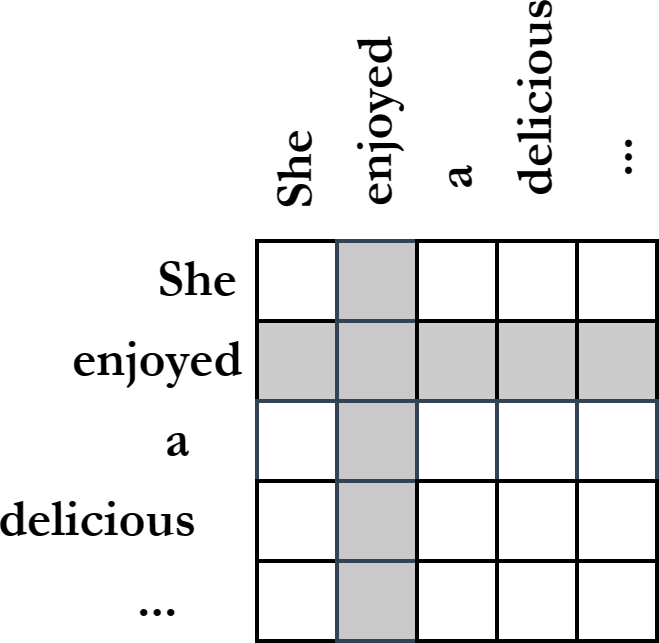
<div>

In [ ]:
bert_encoder = BERTEncoder(num_layers=2, hidden_size=128, num_heads=2, ff_dim=2048).to(device)

In [ ]:
print("Embeddings shape: ", output_emb.shape)
print("Attention mask shape: ", s_mask.shape)
print("Padding mask shape: ", s_padding_mask.shape)
output_encoder = bert_encoder(output_emb, s_mask, s_padding_mask)
print("Encoder output shape: ", output_encoder.shape)

Embeddings shape:  torch.Size([1, 512, 128])
Attention mask shape:  torch.Size([1, 512])
Padding mask shape:  torch.Size([1, 512])
Encoder output shape:  torch.Size([1, 512, 128])


Almost done. To define the whole BERT model we need to stick the last two pieces together. Changing the input and output as follows:

- Input: A sequence of token IDs
- Output: A sequence of contextualized embeddings

In [ ]:
class BERTModel(nn.Module):
    def __init__(self, vocab_size, seq_len, num_layers, hidden_size, num_heads, ff_dim):
        super(BERTModel, self).__init__()
        self.embeddings = BERTEmbeddings(vocab_size, hidden_size, seq_len)
        self.encoder = BERTEncoder(num_layers, hidden_size, num_heads, ff_dim)
    def forward(self, input_ids, attention_mask, padding_mask):
        embedding_output = self.embeddings(input_ids)
        encoder_output = self.encoder(embedding_output, attention_mask, padding_mask)
        return encoder_output

In [ ]:
bert_model = BERTModel(tokenizer.get_vocab_size(), seq_len=512, num_layers=2, hidden_size=128, num_heads=2, ff_dim=2048).to(device)

In [ ]:
print("Input shape : ", s_input.shape)
print("Attention mask shape: ", s_mask.shape)
print("Padding mask shape: ", s_padding_mask.shape)
bert_output = bert_model(s_input, s_mask, s_padding_mask)
print("BERT output shape: ", bert_output.shape)

Input shape :  torch.Size([1, 512])
Attention mask shape:  torch.Size([1, 512])
Padding mask shape:  torch.Size([1, 512])
BERT output shape:  torch.Size([1, 512, 128])


In summary, as we prepare to train our model for the Masked Language Model (MLM) task, it is essential to introduce a final layer that takes the `hidden_size` embedding and generates an output vector of the identical size as the `vocab_size`. This design empowers us to identify the token that corresponds to the word most likely to occur with the highest probability. Essentially, this final layer serves as a crucial component in predicting the most probable words in the language model.

In [ ]:
class BERTMaskedLM(nn.Module):
    def __init__(self, vocab_size, seq_len, num_layers, hidden_size, num_heads, ff_dim):
        super(BERTMaskedLM, self).__init__()
        self.bert = BERTModel(vocab_size, seq_len, num_layers, hidden_size, num_heads, ff_dim)
        self.prediction = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
    def forward(self, input_ids, attention_mask, padding_mask):
        encoder_output = self.bert(input_ids, attention_mask, padding_mask)
        preds = self.prediction(encoder_output)
        output = self.softmax(preds)
        return output

In [ ]:
model = BERTMaskedLM(vocab_size=tokenizer.get_vocab_size(), seq_len=512, num_layers=2, hidden_size=128, num_heads=2, ff_dim=2048).to(device)

In [ ]:
output = model(s_input, s_mask, s_padding_mask)
print("Output shape: ", output.shape)

Output shape:  torch.Size([1, 512, 3808])


In [ ]:
model = BERTMaskedLM(vocab_size=tokenizer.get_vocab_size(), seq_len=512, num_layers=2, hidden_size=128, num_heads=2, ff_dim=2048)
criterion = nn.NLLLoss().to(device) # Negative Log Likelihood
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.015)
model.to(device)

def train(model, optimizer, loss_function, train_dataloader, device):
    model.train()
    avg_train_loss = 0
    for step, batch in enumerate(train_dataloader):
        inputs, masks, padding_masks, targets = tuple(b.to(device) for b in batch)
        model.zero_grad()
        outputs = model(inputs, masks, padding_masks)
        loss = loss_function(outputs.view(-1, tokenizer.get_vocab_size()), targets.view(-1))
        avg_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = avg_train_loss / len(train_dataloader)
    return model, avg_train_loss

In [ ]:
epochs = 20

for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]:")
    model, train_loss = train(model, optimizer, criterion, dataloader, device)
    print(f"Train Loss: {train_loss:.4f}")

Epoch [1/20]:
Train Loss: 5.8218
Epoch [2/20]:
Train Loss: 5.7482
Epoch [3/20]:
Train Loss: 5.6827
Epoch [4/20]:
Train Loss: 5.6377
Epoch [5/20]:
Train Loss: 5.5958
Epoch [6/20]:
Train Loss: 5.5633
Epoch [7/20]:
Train Loss: 5.5564
Epoch [8/20]:
Train Loss: 5.5456
Epoch [9/20]:
Train Loss: 5.5243
Epoch [10/20]:
Train Loss: 5.5170
Epoch [11/20]:
Train Loss: 5.4988
Epoch [12/20]:
Train Loss: 5.4865
Epoch [13/20]:
Train Loss: 5.4794
Epoch [14/20]:
Train Loss: 5.4733
Epoch [15/20]:
Train Loss: 5.4601
Epoch [16/20]:
Train Loss: 5.4670
Epoch [17/20]:
Train Loss: 5.4634
Epoch [18/20]:
Train Loss: 5.4492
Epoch [19/20]:
Train Loss: 5.4523
Epoch [20/20]:
Train Loss: 5.4502


In [ ]:
def mask_sample(sentence):
    sentence_copy = list(sentence)  # Create a new list that is a copy of sentence

    # Create the input_ids
    input_ids = sentence_copy  # Append the new list

    # Create the attention mask
    # The attention mask should have True for tokens that sohould mask
    attention_mask = [False if token != 1 else True for token in sentence_copy]

    # Create the padding mask
    # The padding mask should have a 1 for padding tokens and a 0 for non-padding tokens.
    padding_mask = [True if token == 3 else False for token in sentence_copy]

    return input_ids, attention_mask, padding_mask

In [ ]:
def predict_top_k(sentence, top_k=3):
    # encode sample
    encoded_sample = tokenizer.encode(sentence)
    input_ids, attention_mask, padding_mask = mask_sample(encoded_sample.ids)

    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    masks_tensor = torch.tensor(attention_mask, dtype=torch.bool).unsqueeze(0).to(device)
    padding_tensor = torch.tensor(padding_mask, dtype=torch.bool).unsqueeze(0).to(device)

    model.eval()
    output = model(input_tensor, masks_tensor, padding_tensor)

    # Return the index of the [MASK] token
    true_index = torch.nonzero(masks_tensor.squeeze())[0]

    # Get the indices of the top-k tokens with the maximum probabilities
    top_k_indices = torch.topk(output.squeeze()[true_index, :], top_k).indices

    print(top_k_indices)
    # Initialize a list to store the results
    results = []

    for i in range(top_k):
        max_index = top_k_indices[0][i].item()

        # Create a copy of the input_ids to work with
        output_ids = input_ids.copy()

        # Replace the [MASK] token with the max_index
        output_ids[true_index] = max_index

        # Decode the output_ids and add to the results list
        decoded_str = tokenizer.decode(output_ids)
        results.append(decoded_str)

    return results

In [ ]:
# sentence = "the kid is [MASK] in the yard."
sentence = "she is [MASK] in the yard."
# sentence = "she said that i was [MASK] one."
top_k_predictions = predict_top_k(sentence, top_k=10)

for i, prediction in enumerate(top_k_predictions):
    print(f"Prediction {i+1}: {prediction}")

tensor([[ 6,  9, 26, 11, 10, 15, 13, 12, 14, 37]], device='cuda:0')
Prediction 1: she is , in the yard .
Prediction 2: she is ' in the yard .
Prediction 3: she is n in the yard .
Prediction 4: she is to in the yard .
Prediction 5: she is the in the yard .
Prediction 6: she is i in the yard .
Prediction 7: she is her in the yard .
Prediction 8: she is she in the yard .
Prediction 9: she is a in the yard .
Prediction 10: she is had in the yard .


# More to Learn

Although we already finished to implement an pedagogic version of the original BERT model, there's still a lot more to learn. Including how to **tune** this model for our specific tasks. Another simple type of **positional encoding** technique using $sin()$ and $cos()$ functions. And most importantly, how a **Transformer decoder** works.

## Fine tunning BERT

The task to which we can fine-tune BERT is with NSP.

In [ ]:
class BERTModel(nn.Module):
    def __init__(self, vocab_size, seq_len, num_layers, hidden_size, num_heads, ff_dim):
        super(BERTModel, self).__init__()
        self.embeddings = BERTEmbeddings(vocab_size, hidden_size, seq_len)
        self.encoder = BERTEncoder(num_layers, hidden_size, num_heads, ff_dim)
        self.pooler = nn.Linear(hidden_size, hidden_size)
    def forward(self, input_ids, attention_mask, padding_mask):
        embedding_output = self.embeddings(input_ids)
        encoder_output = self.encoder(embedding_output, attention_mask, padding_mask)
        # print(encoder_output.shape)
        pooled_output = self.pooler(encoder_output[:,0,:])
        return encoder_output, pooled_output

In [ ]:
class BERTMaskedLM(nn.Module):
    def __init__(self, vocab_size, seq_len, num_layers, hidden_size, num_heads, ff_dim):
        super(BERTMaskedLM, self).__init__()
        self.bert = BERTModel(vocab_size, seq_len, num_layers, hidden_size, num_heads, ff_dim)
        self.prediction = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
    def forward(self, input_ids, attention_mask, padding_mask):
        encoder_output, pooled_output = self.bert(input_ids, attention_mask, padding_mask)
        preds = self.prediction(encoder_output)
        output = self.softmax(preds)
        return output

## Positional Encoding

Unlike RNN, Transformers has no recurrence mechanism. All tokens are fed in parallel, which reduces training time and helps to learn long term dependencies.

However, the order of the words is important because the position of the words helps to understand the meaning of the sentence.

To add this information to the transformer, the original authors propose a positional encoding matrix. To compute this matrix, a sinusoidal function is used according to the following formula:

$$
P(\text{pos}, 2i)=\sin \left( \frac{\text{pos}}{1000^{2i/d_{model}}} \right)
$$

$$
P(\text{pos}, 2i+1)=\cos \left( \frac{\text{pos}}{1000^{2i/d_{model}}} \right)
$$

<div>
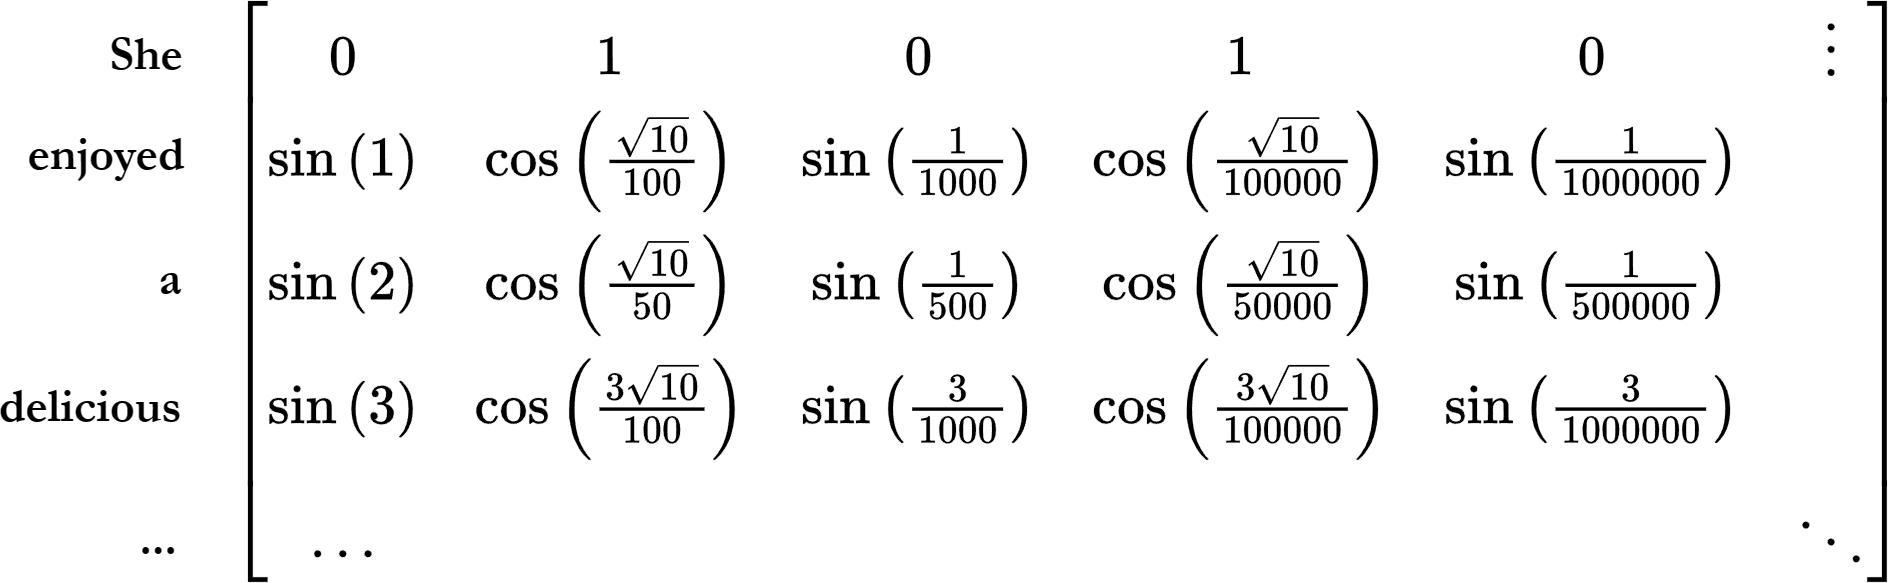
</div>

Then, before entering the first encoder, the position encoding matrix is added to the input matrix.

## Transformer Decoder

The decoder takes the encoder's representation and converts it into new one. For example, in the context of machine translation between English and French, the encoder takes the sentences in English and creates a series of embeddings. From this representation, the decoder creates the target sentences in French.

<div>
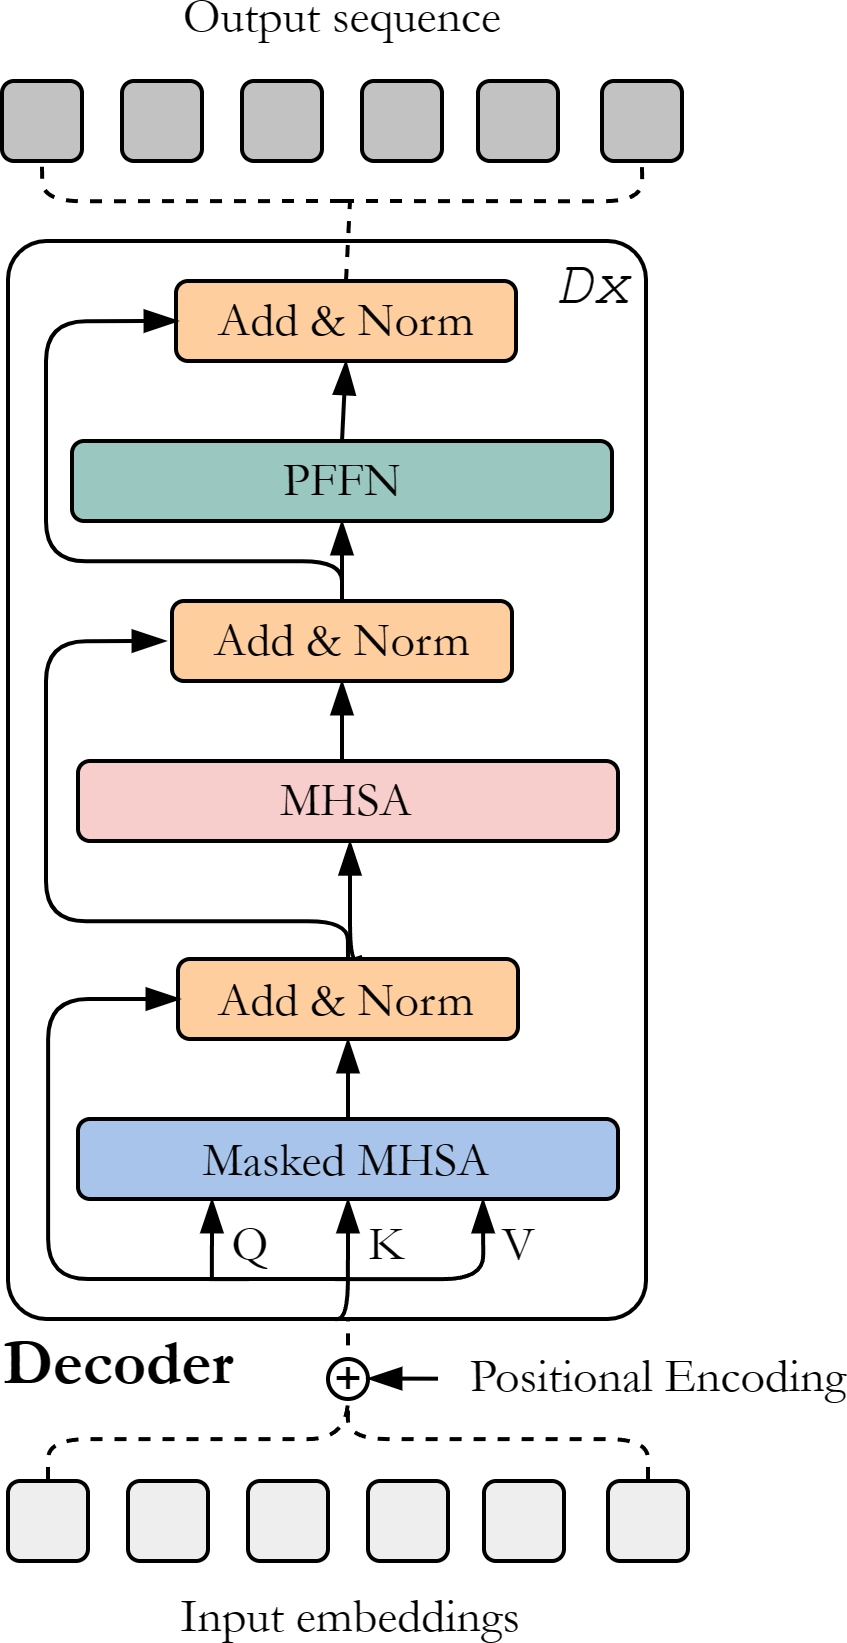
</div>

This marks the conclusion of the tutorial. If you come across any errors or have suggestions for improvement, please don't hesitate to reach out to the authors. Your feedback is greatly appreciated. Additionally, the plan to expand the tutorial with a functional and educational version of **GPT** is an exciting prospect and promises to enhance your understanding of the topic. Stay tuned to the github page. Thank you for your engagement and dedication to improving knowledge in this field.